# P3 Concevez une application au service de la santé publique 

L'agence <span style='color:blue'> <a href = "http://www.santepubliquefrance.fr/">"*Santé publique France*" </a></span> a lancé un appel à projets pour trouver des idées innovantes d’applications en lien avec l'alimentation. <br>
Vous souhaitez y participer et proposer une idée d’application.

Le jeu de données <font color='orange'>Open Food Facts</font> est disponible sur le <a href = "https://world.openfoodfacts.org/">site officiel</a> (ou disponible à <a href ="https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/parcours-data-scientist/P2/fr.openfoodfacts.org.products.csv.zip">ce lien</a> en téléchargement).
<br>
Les variables sont définies à <a href = "https://world.openfoodfacts.org/data/data-fields.txt">cette adresse</a>

Les champs sont séparés en quatre sections :

- Les informations générales sur la fiche du produit : nom, date de modification, etc.
- Un ensemble de tags : catégorie du produit, localisation, origine, etc.
- Les ingrédients composant les produits et leurs additifs éventuels.
- Des informations nutritionnelles : quantité en grammes d’un nutriment pour 100 grammes du produit.

Notre idée est de créer une application mobile nommé livebetterandlonger

Cette application permettra au utilisateur d'ameliorer leur alimentaion, en leur proposant lors de l'achat des course d'obtenir une liste de produit similaire plus sain, c'est à dire en terme possedant un meilleur nutriscore. 


Comment:
lors de la selection d'un aliment, grace à son smartphone le client scannera le code barre de l'aliment, et obtiendra une liste de produit ordonnée par qualité nutritive au moins aussi interressant que le produit scanné.

Ce notebook a pour vocation à détailler le processus de nettoyage et de traitement necessaire pour la mise en place de notre application lookalike.

Les données sont toutes issues de l'initiative Open Food Facts dans le cadre de l'appel à projets de l'Agence Santé Publique France.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
import os

import missingno as msno

In [2]:
%%time
if os.path.exists("fr.openfoodfacts.org.products.csv"):
    openfoodfacts = pd.read_csv("fr.openfoodfacts.org.products.csv",sep='\t',low_memory=False)

CPU times: total: 14.8 s
Wall time: 14.9 s


prendre 1 echant en parametre / 
figer typ de chaq col

In [3]:
openfoodfacts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320772 entries, 0 to 320771
Columns: 162 entries, code to water-hardness_100g
dtypes: float64(106), object(56)
memory usage: 396.5+ MB


Le fichier comtient 106 variables numeriques et 56 varriables catégoriques.
Il y a trop de données pour tout afficher dans une cellule resultant de la methode info().
Nous etudirons les colonnes de type 'object' dans un premier temps.

In [4]:
pd.options.display.max_columns=60
openfoodfacts[openfoodfacts.columns[(openfoodfacts.dtypes==object) ].to_list()].describe().T

count  unique  \
code                                        320749  320749   
url                                         320749  320749   
creator                                     320770    3535   
created_t                                   320769  189567   
created_datetime                            320763  189568   
last_modified_t                             320772  180495   
last_modified_datetime                      320772  180495   
product_name                                303010  221347   
generic_name                                 52795   38584   
quantity                                    104819   13826   
packaging                                    78960   14547   
packaging_tags                               78961   12064   
brands                                      292360   58784   
brands_tags                                 292352   50253   
categories                                   84410   36982   
categories_tags                              84389   21142   
categories_fr                                84411   21152   
origins                                      22190    4840   
origins_tags                                 22153    4372   
manufacturing_places                         36501    7308   
manufacturing_places_tags                    36495    6736   
labels                                       46559   18114   
labels_tags                                  46644   13653   
labels_fr                                    46666   13655   
emb_codes                                    29306    8462   
emb_codes_tags                               29303    8158   
first_packaging_code_geo                     18803    1602   
cities                                          23       3   
cities_tags                                  20320    2572   
purchase_places                              58193    5120   
stores                                       51722    3259   
countries                                   320492    1434   
countries_tags                              320492     725   
countries_fr                                320492     722   
ingredients_text                            248962  205520   
allergens                                    28344   12939   
allergens_fr                                    19      19   
traces                                       24353    8378   
traces_tags                                  24329    3578   
traces_fr                                    24352    3584   
serving_size                                211331   25423   
additives                                   248905  196069   
additives_tags                              154680   41537   
additives_fr                                154680   41537   
ingredients_from_palm_oil_tags                4835      14   
ingredients_that_may_be_from_palm_oil_tags   11696     160   
nutrition_grade_fr                          221210       5   
pnns_groups_1                                91513      14   
pnns_groups_2                                94491      42   
states                                      320726    1021   
states_tags                                 320726    1021   
states_fr                                   320726    1021   
main_category                                84366    3543   
main_category_fr                             84366    3543   
image_url                                    75836   75836   
image_small_url                              75836   75836   

                                                                                          top  \
code                                                                            0000000003087   
url                                         http://world-fr.openfoodfacts.org/produit/0000...   
creator                                                                       usda-ndb-import   
created_t                                                                          1489077120   
created_datetime         

In [5]:
def test_na_nunique(col1,col2):
    '''
    Test number of Missing Value et number unique value
    '''
    return(col1.nunique() < col2.nunique() and abs(col1.notna().sum() - col2.notna().sum() ) <100)

def drop_duplicated_col(df):
    '''
    return list columns redundant to drop
    '''
    col_to_drop = []
    
    for col in df.columns :

        # les dates
        if len(col.split('_'))>=2 and col.split('_')[-1] == 't':  
            col_to_drop.append(col.replace('_t','_datetime'))


        if len(col.split('_'))==1 and col+'_fr' in openfoodfacts and col+'_tags' in openfoodfacts:
            # si 'fr' better than ''
            col_to_drop.extend(np.where(test_na_nunique(df[col+'_fr'] , df[col]), 
                                        np.where(test_na_nunique( df[col+'_fr'] , df[col+'_tags'] ),
                                                 [col,col+'_tags'],   # si 'fr'> '_tags' 
                                                 [col,col+'_fr']      # si 'fr'< '_tags' 
                                                ),
                                        # si 'fr' not better than ''
                                        np.where(test_na_nunique(df[col] , df[col+'_tags'] ),
                                                 [col+'_tags',col+'_fr'],
                                                 [col ,col+'_fr']
                                                )
                                       )
                              )
        elif len(col.split('_'))==1 and (col+'_fr' in openfoodfacts or col+'_tags' in openfoodfacts):

            if col+'_fr' in openfoodfacts:  
                col_to_drop.extend(np.where(test_na_nunique(df[col+'_fr'] , df[col]),
                                            [col],   # si 'fr'> ''
                                            [col+'_fr']      # si 'fr'< '' 
                                           )
                                  )

            elif col+'_tags' in openfoodfacts:
                # si 'fr' better than ''
                col_to_drop.extend(np.where(test_na_nunique(df[col+'_tags'] , df[col]),
                                            [col],   # si 'fr'> ''
                                            [col+'_tags']      # si 'fr'< '' 
                                           )
                                  )
        elif len(col.split('_'))>=2 and col +'_fr' in openfoodfacts or col+'_tags' in openfoodfacts:
            
            if (col+'_fr' in openfoodfacts) :
                col_to_drop.extend(np.where(test_na_nunique(df[col ] , df[col+'_fr']),
                                            [col+ '_fr'],   # si 'fr'> ''
                                            [col ]      # si 'fr'< '' 
                                           )
                                  )

            elif (col +'_tags' in openfoodfacts) :
                # si 'fr' better than ''
                col_to_drop.extend(np.where(test_na_nunique(df[col + '_tags'] , df[col]),
                                            [col],   # si 'fr'> ''
                                            [col +'_tags']      # si 'fr'< '' 
                                           )
                                  )
 
            
    return col_to_drop

In [6]:
list_col_to_drop = drop_duplicated_col(df = openfoodfacts)
list_col_to_drop

['created_datetime',
 'last_modified_datetime',
 'packaging',
 'brands',
 'categories',
 'categories_fr',
 'origins',
 'manufacturing_places',
 'labels',
 'labels_fr',
 'emb_codes',
 'cities_tags',
 'countries',
 'countries_tags',
 'allergens_fr',
 'traces',
 'traces_fr',
 'additives',
 'additives_fr',
 'ingredients_from_palm_oil_tags',
 'ingredients_that_may_be_from_palm_oil_tags',
 'states',
 'states_fr',
 'main_category']

In [7]:
data_cleaned = openfoodfacts.drop(columns=list_col_to_drop).copy()

In [8]:
data_cleaned.head()

code                                                url  \
0  0000000003087  http://world-fr.openfoodfacts.org/produit/0000...   
1  0000000004530  http://world-fr.openfoodfacts.org/produit/0000...   
2  0000000004559  http://world-fr.openfoodfacts.org/produit/0000...   
3  0000000016087  http://world-fr.openfoodfacts.org/produit/0000...   
4  0000000016094  http://world-fr.openfoodfacts.org/produit/0000...   

                      creator   created_t last_modified_t  \
0  openfoodfacts-contributors  1474103866      1474103893   
1             usda-ndb-import  1489069957      1489069957   
2             usda-ndb-import  1489069957      1489069957   
3             usda-ndb-import  1489055731      1489055731   
4             usda-ndb-import  1489055653      1489055653   

                     product_name generic_name quantity packaging_tags  \
0              Farine de blé noir          NaN      1kg            NaN   
1  Banana Chips Sweetened (Whole)          NaN      NaN            NaN   
2                         Peanuts          NaN      NaN            NaN   
3          Organic Salted Nut Mix          NaN      NaN            NaN   
4                 Organic Polenta          NaN      NaN            NaN   

       brands_tags categories_tags origins_tags manufacturing_places_tags  \
0  ferme-t-y-r-nao             NaN          NaN                       NaN   
1              NaN             NaN          NaN                       NaN   
2     torn-glasser             NaN          NaN                       NaN   
3        grizzlies             NaN          NaN                       NaN   
4   bob-s-red-mill             NaN          NaN                       NaN   

  labels_tags emb_codes_tags first_packaging_code_geo cities purchase_places  \
0         NaN            NaN                      NaN    NaN             NaN   
1         NaN            NaN                      NaN    NaN             NaN   
2         NaN            NaN                      NaN    NaN             NaN   
3         NaN            NaN                      NaN    NaN             NaN   
4         NaN            NaN                      NaN    NaN             NaN   

  stores countries_fr                                   ingredients_text  \
0    NaN       France                                                NaN   
1    NaN   États-Unis  Bananas, vegetable oil (coconut oil, corn oil ...   
2    NaN   États-Unis  Peanuts, wheat flour, sugar, rice flour, tapio...   
3    NaN   États-Unis  Organic hazelnuts, organic cashews, organic wa...   
4    NaN   États-Unis                                    Organic polenta   

  allergens traces_tags     serving_size  no_nutriments  additives_n  \
0       NaN         NaN              NaN            NaN          NaN   
1       NaN         NaN     28 g (1 ONZ)            NaN          0.0   
2       NaN         NaN  28 g (0.25 cup)            NaN          0.0   
3       NaN         NaN  28 g (0.25 cup)            NaN          0.0   
4       NaN         NaN  35 g (0.25 cup)            NaN          0.0   

  additives_tags  ingredients_from_palm_oil_n  ingredients_from_palm_oil  \
0            NaN                          NaN                        NaN   
1            NaN                          0.0                        NaN   
2            NaN                          0.0                        NaN   
3            NaN                          0.0                        NaN   
4            NaN                          0.0                        NaN   

   ingredients_that_may_be_from_palm_oil_n  ...  biotin_100g  \
0                                      NaN  ...          NaN   
1                                      0.0  ...          NaN   
2                                      0.0  ...          NaN   
3                                      0.0  ...          NaN   
4                                      0.0  ...          NaN   

   pantothenic-acid_100g silica_100g bicarbonate_100g potassium_100g  \
0                    NaN 

In [9]:
nbLigne, nbCol = data_cleaned.shape

In [10]:
print ("Le dataset compte {} lignes et {} colonnes".format( nbLigne , nbCol ))

Le dataset compte 320772 lignes et 138 colonnes


### Etude du nombre de valeurs manquantes

In [11]:
pd.set_option("display.max_rows", 200) #parametre le nombre de ligne affichable dans dataframe pandas
pd.set_option("expand_frame_repr", True) #permet de deplier les colonnes cachées
pd.set_option("display.max_columns",200 ) #permet d'afficher jusqu'à 200 colonnes dans une cellule

In [12]:
print('Au total le dataset possede {} valeurs manquantes. \nCe qui represante {:.2%} des valeurs du dataset'.format(data_cleaned.isna().sum().sum(),data_cleaned.isna().sum().sum()/(nbCol*nbLigne)))

Au total le dataset possede 35128921 valeurs manquantes. 
Ce qui represante 79.36% des valeurs du dataset


In [13]:
def compute_nb_mising_values(data):
    """
    Cree un dataframe pandas qui contient le nombre de valeurs par colonnes de l'argument data
    """
    valeurs = {}
    
    for col in data.columns:
        valeurs[col] = []
        valeurs[col].append(round((data[col].notna().sum()/data.shape[0])*100,2))
        valeurs[col].append(data[col].isna().sum())
        
    return pd.DataFrame.from_dict(data=valeurs, orient='index',
                                  columns = ["Taux de valeurs non nulles", "Nombre de valeurs manquantes"]
                                 ).sort_values(by="Nombre de valeurs manquantes",ascending=True)

In [14]:
compute_nb_mising_values(data_cleaned)

Taux de valeurs non nulles  \
last_modified_t                                              100.00   
creator                                                      100.00   
created_t                                                    100.00   
code                                                          99.99   
url                                                           99.99   
states_tags                                                   99.99   
countries_fr                                                  99.91   
product_name                                                  94.46   
brands_tags                                                   91.14   
energy_100g                                                   81.40   
proteins_100g                                                 81.03   
salt_100g                                                     79.65   
sodium_100g                                                   79.64   
ingredients_text                                              77.61   
additives_n                                                   77.61   
ingredients_that_may_be_from_palm_oil_n                       77.61   
ingredients_from_palm_oil_n                                   77.61   
sugars_100g                                                   76.37   
fat_100g                                                      76.03   
carbohydrates_100g                                            75.94   
saturated-fat_100g                                            71.56   
nutrition_grade_fr                                            68.96   
nutrition-score-uk_100g                                       68.96   
nutrition-score-fr_100g                                       68.96   
serving_size                                                  65.88   
fiber_100g                                                    62.63   
additives_tags                                                48.22   
cholesterol_100g                                              44.92   
trans-fat_100g                                                44.67   
calcium_100g                                                  43.97   
vitamin-c_100g                                                43.91   
iron_100g                                                     43.79   
vitamin-a_100g                                                42.88   
quantity                                                      32.68   
pnns_groups_2                                                 29.46   
pnns_groups_1                                                 28.53   
categories_tags                                               26.31   
main_category_fr                                              26.30   
packaging_tags                                                24.62   
image_url                                                     23.64   
image_small_url                                               23.64   
purchase_places                                               18.14   
generic_name                                                  16.46   
stores                                                        16.12   
labels_tags                                                   14.54   
manufacturing_places_tags                                     11.38   
emb_codes_tags                                                 9.14   
allergens                                                      8.84   
potassium_100g                                                 7.72   
traces_tags                                                    7.58   
polyunsaturated-fat_100g                                       7.13   
monounsaturated-fat_100g                                       7.12   
origins_tags                                                   6.91   
first_packaging_code_geo                                       5.86   
vitamin-pp_100g                                                3.66   
vitamin-b1_100g                                                3.

On voit que 23 produits ne possède pas de code bar.

In [15]:
data_cleaned[data_cleaned.code.isnull()][['generic_name']]

generic_name
189068  Lait entier, fruits : fraise (20 %), mangue (1...
189103  _Lait_ entier (59,5 %), _lait_ écrémé concentr...
189109  Lait entier 69.5 %, fruits : fraise 10 %, mang...
189119   _Lait_ entier (78%), fruits : mangue, abricot...
189152  _Lait_ écrémé, _lait_ écrémé concentré ou en p...
189160  _Lait_ écrémé, fruits : fraise (12 %), cerise ...
189162  _Lait_ écrémé, _lait_ écrémé concentré ou en p...
189168  _Lait_ entier (59,5 %), _lait_ écrémé concentr...
189242  _Lait_ entier, rhubarbe (8 %), sucre (8 %), la...
189244  _Lait_ entier, ananas (8 %), sucre (7,1 %), _l...
189248                                        lAllFElt...
189250  _lait_ entier (73,6%), fruits : rhubarbe, figu...
189260  _Lait_ écrémé, fraise 7.5%, _lait_ écrémé conc...
189262  _Lait_ écrémé, cerise (8,0 %), _lait_ écrémé c...
189269  INGRÉDIENTS : _lait_ écrémé, abricot (8,5%), p...
189272  _Lait_ écrémé, abricot (8,5%), pêche (8,2%), c...
189345  _Lait_ entier (80,3%), sucre (8,2% en moyenne)...
189362  _lait_ demi-écrémé, _lait_ écrémé concentré ou...
189364                                                NaN
189379  _Lait_ entier (78,1%), sucre (8,5%), _lait_ éc...
189404  _lait_ entier, sucre (9,6% en moyenne), fruits...
189406  _lait_ entier, sucre (9,7% en moyenne), fruits...
189417  _Lait_ écrémé, _lait_ écrémé concentré ou en p...

Ce sont des produits laitiers. Peut etre qu'il faut les supprimer.

In [16]:
data_cleaned = data_cleaned.loc[~data_cleaned.code.isna()]

In [17]:
nbLigne, nbCol = data_cleaned.shape
nbLigne, nbCol

(320749, 138)

In [18]:
compute_nb_mising_values(data_cleaned)

Taux de valeurs non nulles  \
code                                                         100.00   
url                                                          100.00   
created_t                                                    100.00   
last_modified_t                                              100.00   
creator                                                      100.00   
states_tags                                                   99.99   
countries_fr                                                  99.91   
product_name                                                  94.46   
brands_tags                                                   91.15   
energy_100g                                                   81.41   
proteins_100g                                                 81.03   
salt_100g                                                     79.66   
sodium_100g                                                   79.65   
ingredients_that_may_be_from_palm_oil_n                       77.61   
ingredients_from_palm_oil_n                                   77.61   
additives_n                                                   77.61   
ingredients_text                                              77.61   
sugars_100g                                                   76.37   
fat_100g                                                      76.04   
carbohydrates_100g                                            75.94   
saturated-fat_100g                                            71.57   
nutrition-score-uk_100g                                       68.97   
nutrition_grade_fr                                            68.97   
nutrition-score-fr_100g                                       68.97   
serving_size                                                  65.88   
fiber_100g                                                    62.63   
additives_tags                                                48.22   
cholesterol_100g                                              44.92   
trans-fat_100g                                                44.68   
calcium_100g                                                  43.98   
vitamin-c_100g                                                43.92   
iron_100g                                                     43.79   
vitamin-a_100g                                                42.89   
quantity                                                      32.67   
pnns_groups_2                                                 29.46   
pnns_groups_1                                                 28.53   
categories_tags                                               26.31   
main_category_fr                                              26.30   
packaging_tags                                                24.62   
image_small_url                                               23.64   
image_url                                                     23.64   
purchase_places                                               18.14   
generic_name                                                  16.45   
stores                                                        16.12   
labels_tags                                                   14.54   
manufacturing_places_tags                                     11.37   
emb_codes_tags                                                 9.14   
allergens                                                      8.83   
potassium_100g                                                 7.72   
traces_tags                                                    7.59   
polyunsaturated-fat_100g                                       7.13   
monounsaturated-fat_100g                                       7.12   
origins_tags                                                   6.90   
first_packaging_code_geo                                       5.86   
vitamin-pp_100g                                                3.65   
vitamin-b1_100g                                                3.

In [19]:
data_cleaned.dropna(axis='columns' , thresh= round(nbLigne * 0.0005),inplace = True)
compute_nb_mising_values( data_cleaned )

Taux de valeurs non nulles  \
code                                                         100.00   
url                                                          100.00   
created_t                                                    100.00   
last_modified_t                                              100.00   
creator                                                      100.00   
states_tags                                                   99.99   
countries_fr                                                  99.91   
product_name                                                  94.46   
brands_tags                                                   91.15   
energy_100g                                                   81.41   
proteins_100g                                                 81.03   
salt_100g                                                     79.66   
sodium_100g                                                   79.65   
ingredients_that_may_be_from_palm_oil_n                       77.61   
ingredients_text                                              77.61   
additives_n                                                   77.61   
ingredients_from_palm_oil_n                                   77.61   
sugars_100g                                                   76.37   
fat_100g                                                      76.04   
carbohydrates_100g                                            75.94   
saturated-fat_100g                                            71.57   
nutrition_grade_fr                                            68.97   
nutrition-score-fr_100g                                       68.97   
nutrition-score-uk_100g                                       68.97   
serving_size                                                  65.88   
fiber_100g                                                    62.63   
additives_tags                                                48.22   
cholesterol_100g                                              44.92   
trans-fat_100g                                                44.68   
calcium_100g                                                  43.98   
vitamin-c_100g                                                43.92   
iron_100g                                                     43.79   
vitamin-a_100g                                                42.89   
quantity                                                      32.67   
pnns_groups_2                                                 29.46   
pnns_groups_1                                                 28.53   
categories_tags                                               26.31   
main_category_fr                                              26.30   
packaging_tags                                                24.62   
image_small_url                                               23.64   
image_url                                                     23.64   
purchase_places                                               18.14   
generic_name                                                  16.45   
stores                                                        16.12   
labels_tags                                                   14.54   
manufacturing_places_tags                                     11.37   
emb_codes_tags                                                 9.14   
allergens                                                      8.83   
potassium_100g                                                 7.72   
traces_tags                                                    7.59   
polyunsaturated-fat_100g                                       7.13   
monounsaturated-fat_100g                                       7.12   
origins_tags                                                   6.90   
first_packaging_code_geo                                       5.86   
vitamin-pp_100g                                                3.65   
vitamin-b1_100g                                                3.

In [20]:
print('Avec un seuil de {} lignes {} ont été supprimées et maintenant le dataset possède {} colonnes'.format(round(nbLigne * 0.0005),(nbCol-data_cleaned.shape[1]),data_cleaned.shape[1]))

Avec un seuil de 160 lignes 53 ont été supprimées et maintenant le dataset possède 85 colonnes


In [21]:
nbLigne, nbCol = data_cleaned.shape
nbLigne, nbCol

(320749, 85)

### Etudes des Doublons de la cle primaire/ du dataset

In [22]:
print('Le dataset possedent {} lignes de doublons.'.format(data_cleaned.duplicated().sum()))

Le dataset possedent 0 lignes de doublons.


In [23]:
print('Le taux de doublons de valeurs est de {} %.'.format(100 - round(data_cleaned.code.nunique()*100/data_cleaned.shape[0],2)) )

Le taux de doublons de valeurs est de 0.0 %.


On ne trouve pas de valeurs manquantes.
Il y a-t'il des erreurs?

In [24]:
data_cleaned.code.str.replace('[a-zA-Z]','A',regex=True).str.replace('[0-9]','N',regex=True).value_counts()

NNNNNNNNNNNNN                                302985
NNNNNNNN                                      13851
NNNNNNNNNNN                                    2322
NNNNNNNNNNNN                                    825
NNNNNNNNNNNNNN                                  253
NNNNNNNNNN                                      136
NNNNNNN                                          96
NNNNNN                                           67
NNNN                                             34
NNNNNNNNNNNNNNN                                  31
NNNNNNNNNNNNNNNNNNNNNNNN                         31
NNNNN                                            20
NNNNNNNNNNNNNNNNNN                               20
NNNNNNNNN                                        18
NNNNNNNNNNNNNNNN                                 13
NNN                                               8
NNNNNNNNNNNNNNNNNNNNNN                            7
NN                                                7
NNNNNNNNNNNNNNNNNNNNNNNNNN                        5
N           

In [25]:
print('{} % des codes sont maintenant confondu avec un autre code'.format(round(1- data_cleaned.code.str.zfill(41).nunique() / data_cleaned.code.nunique(),4) ))

0.0005 % des codes sont maintenant confondu avec un autre code


In [26]:
print("La variable 'product name' est composée de {} valeurs unique avant qu'aucun traitement ne soit appliqué.".format(openfoodfacts.product_name.nunique()))

La variable 'product name' est composée de 221347 valeurs unique avant qu'aucun traitement ne soit appliqué.


In [27]:
print("Nous réduisons de {:.2%} le nombre de valeurs uniques après conversion en minuscule \net de {:.2%} après conversion en minuscule et suppression des ponctuation"\
      .format(round(1-openfoodfacts.product_name.str.lower().nunique()/openfoodfacts.product_name.nunique(),4),
              round(1-openfoodfacts.product_name.str.lower().str.replace('[:punct:]','',regex=True).nunique()/openfoodfacts.product_name.nunique(),4)  
             ) 
     )


Nous réduisons de 3.11% le nombre de valeurs uniques après conversion en minuscule 
et de 3.47% après conversion en minuscule et suppression des ponctuation


In [28]:
openfoodfacts[openfoodfacts.product_name.str.lower().str.replace('[:punct:]','',regex=True).duplicated()].sort_values('product_name')[['code','product_name']].head(10)

code                   product_name
294518  7613269752103                               
315118  8714789999784                               
185562       26173184               Asparagus Spears
33952   0036800499423                        #Error!
33951   0036800499416                        #Error!
114524  0300258900122  0 Calorie Sweetener, Original
76690   0071580100732                1 % Lowfat Milk
113342    02114029726                1 % Lowfat Milk
119671  0631656560541            1 Clean Protein Bar
183046  2297324022049              1 Cuisse de dinde

</br>

</br>

# Etude des types de variables

In [29]:
pd.options.display.max_rows,pd.options.display.max_columns

(200, 200)

In [30]:
nomColonnes = pd.DataFrame({'Colonnes':data_cleaned.columns})
nomColonnes.T

0    1        2          3                4             5   \
Colonnes  code  url  creator  created_t  last_modified_t  product_name   

                    6         7               8            9   \
Colonnes  generic_name  quantity  packaging_tags  brands_tags   

                       10            11                         12  \
Colonnes  categories_tags  origins_tags  manufacturing_places_tags   

                   13              14                        15  \
Colonnes  labels_tags  emb_codes_tags  first_packaging_code_geo   

                       16      17            18                19         20  \
Colonnes  purchase_places  stores  countries_fr  ingredients_text  allergens   

                   21            22           23              24  \
Colonnes  traces_tags  serving_size  additives_n  additives_tags   

                                   25  \
Colonnes  ingredients_from_palm_oil_n   

                                               26                  27  \
Colonnes  ingredients_that_may_be_from_palm_oil_n  nutrition_grade_fr   

                     28             29           30                31  \
Colonnes  pnns_groups_1  pnns_groups_2  states_tags  main_category_fr   

                 32               33           34                    35  \
Colonnes  image_url  image_small_url  energy_100g  energy-from-fat_100g   

                36                  37                        38  \
Colonnes  fat_100g  saturated-fat_100g  monounsaturated-fat_100g   

                                39                40  \
Colonnes  polyunsaturated-fat_100g  omega-3-fat_100g   

                                 41                42              43  \
Colonnes  alpha-linolenic-acid_100g  omega-6-fat_100g  trans-fat_100g   

                        44                  45           46            47  \
Colonnes  cholesterol_100g  carbohydrates_100g  sugars_100g  lactose_100g   

                   48            49          50             51         52  \
Colonnes  starch_100g  polyols_100g  fiber_100g  proteins_100g  salt_100g   

                   53            54              55              56  \
Colonnes  sodium_100g  alcohol_100g  vitamin-a_100g  vitamin-d_100g   

                      57              58              59               60  \
Colonnes  vitamin-e_100g  vitamin-k_100g  vitamin-c_100g  vitamin-b1_100g   

                       61               62               63               64  \
Colonnes  vitamin-b2_100g  vitamin-pp_100g  vitamin-b6_100g  vitamin-b9_100g   

                    65                66           67                     68  \
Colonnes  folates_100g  vitamin-b12_100g  biotin_100g  pantothenic-acid_100g   

                      69            70               71         72  \
Colonnes  potassium_100g  calcium_100g  phosphorus_100g  iron_100g   

                      73         74           75              76  \
Colonnes  magnesium_100g  zinc_100g  copper_100g  manganese_100g   

                     77           78                           79  \
Colonnes  selenium_100g  iodine_100g  fruits-vegetables-nuts_100g   

                                        80          81                     82  \
Colonnes  collagen-meat-protein-ratio_100g  cocoa_100g  carbon-footprint_100g   

                               83                       84  
Colonnes  nutrition-score-fr_100g  nutrition-score-uk_100g

In [31]:
openfoodfacts.columns[52:54]

Index(['nutrition_grade_uk', 'nutrition_grade_fr'], dtype='object')

In [32]:
# Categoriser les types de colonnes
# info general
general_information = [x for x in nomColonnes.Colonnes.values.tolist() if x in ['code', 'url', 'creator', 'created_t', 'created_datetime', 'last_modified_t', 'last_modified_datetime', 'product_name', 'generic_name', 'quantity']]

# tags
tags = [x for x in nomColonnes.Colonnes.values.tolist() if x in ['packaging', 'packaging_tags', 'brands', 'brands_tags', 'categories', 'categories_tags', 'categories_fr', 
                                                                 'origins', 'origins_tags', 'manufacturing_places', 'manufacturing_places_tags','emb_codes',
                                                                 'emb_codes_tags', 'first_packaging_code_geo', 'cities_tags', 'purchase_places', 'stores', 
                                                                 'countries', 'countries_tags', 'countries_fr']]

# les ingredients
ingredients = ['ingredients_text', 'allergens', 'traces_tags']

# misc_data
misc_data = ['serving_size', 'additives_n', 'additives_tags', 'ingredients_from_palm_oil_n',
             'ingredients_that_may_be_from_palm_oil_n', 'nutrition_grade_fr', 'pnns_groups_1', 'pnns_groups_2', 'states_tags',
             'main_category_fr', 'image_url', 'image_small_url']

#Les scores nutritionnelles
score_foot_print = ['nutrition_grade_uk', 'nutrition_grade_fr','carbon-footprint_100g', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g']

# les labels
labels = ["labels_tags"]

#Les valeurs nutritionnelles
nutrition_facts = [x for x in nomColonnes.Colonnes.values.tolist() if x[-5:]=='_100g' and x not in score_foot_print]

#Remplir colonnes type_de_données
nomColonnes['type_de_colonne'] = ''

nomColonnes.type_de_colonne[nomColonnes.Colonnes.isin(general_information)] = "general_information"
nomColonnes.type_de_colonne[nomColonnes.Colonnes.isin(tags)] = "tags"
nomColonnes.type_de_colonne[nomColonnes.Colonnes.isin(ingredients)] = "ingredients"
nomColonnes.type_de_colonne[nomColonnes.Colonnes.isin(misc_data)] = "misc_data"
nomColonnes.type_de_colonne[nomColonnes.Colonnes.isin(nutrition_facts)] = "nutrition_facts"
nomColonnes.type_de_colonne[nomColonnes.Colonnes.isin(score_foot_print)] = "score_foot_print"
nomColonnes.type_de_colonne[nomColonnes.Colonnes.isin(labels)] = "labels"

In [33]:
nomColonnes = nomColonnes\
.merge(right= compute_nb_mising_values(data_cleaned).reset_index(),right_on='index',left_on ="Colonnes" ,
       how='left')\
.drop(columns=['index'])

nomColonnes.T

0                    1   \
Colonnes                                     code                  url   
type_de_colonne               general_information  general_information   
Taux de valeurs non nulles                  100.0                100.0   
Nombre de valeurs manquantes                    0                    0   

                                               2                    3   \
Colonnes                                  creator            created_t   
type_de_colonne               general_information  general_information   
Taux de valeurs non nulles                  100.0                100.0   
Nombre de valeurs manquantes                    2                    0   

                                               4                    5   \
Colonnes                          last_modified_t         product_name   
type_de_colonne               general_information  general_information   
Taux de valeurs non nulles                  100.0                94.46   
Nombre de valeurs manquantes                    0                17762   

                                               6                    7   \
Colonnes                             generic_name             quantity   
type_de_colonne               general_information  general_information   
Taux de valeurs non nulles                  16.45                32.67   
Nombre de valeurs manquantes               267976               215949   

                                          8            9                10  \
Colonnes                      packaging_tags  brands_tags  categories_tags   
type_de_colonne                         tags         tags             tags   
Taux de valeurs non nulles             24.62        91.15            26.31   
Nombre de valeurs manquantes          241788        28397           236360   

                                        11                         12  \
Colonnes                      origins_tags  manufacturing_places_tags   
type_de_colonne                       tags                       tags   
Taux de valeurs non nulles             6.9                      11.37   
Nombre de valeurs manquantes        298618                     284276   

                                       13              14  \
Colonnes                      labels_tags  emb_codes_tags   
type_de_colonne                    labels            tags   
Taux de valeurs non nulles          14.54            9.14   
Nombre de valeurs manquantes       274105          291447   

                                                    15               16  \
Colonnes                      first_packaging_code_geo  purchase_places   
type_de_colonne                                   tags             tags   
Taux de valeurs non nulles                        5.86            18.14   
Nombre de valeurs manquantes                    301946           262579   

                                  17            18                19  \
Colonnes                      stores  countries_fr  ingredients_text   
type_de_colonne                 tags          tags       ingredients   
Taux de valeurs non nulles     16.12         99.91             77.61   
Nombre de valeurs manquantes  269050           280             71810   

                                       20           21            22  \
Colonnes                        allergens  traces_tags  serving_size   
type_de_colonne               ingredients  ingredients     misc_data   
Taux de valeurs non nulles           8.83         7.59         65.88   
Nombre de valeurs manquantes       292424       296420        109441   

                                       23              24  \
Colonnes                      additives_n  additives_tags   
type_de_colonne                 misc_data       misc_data   
Taux de valeurs non nulles          77.61           48.22   
Nombre de valeurs manquantes        71810          166069   

                                                       25  \
Colonnes                      ingre

</br>

</br>

</br>

</br>

## Supprimer les Variables redondantes

In [34]:
col_to_drop = []
colgarder = []

### les valeurs manquantes

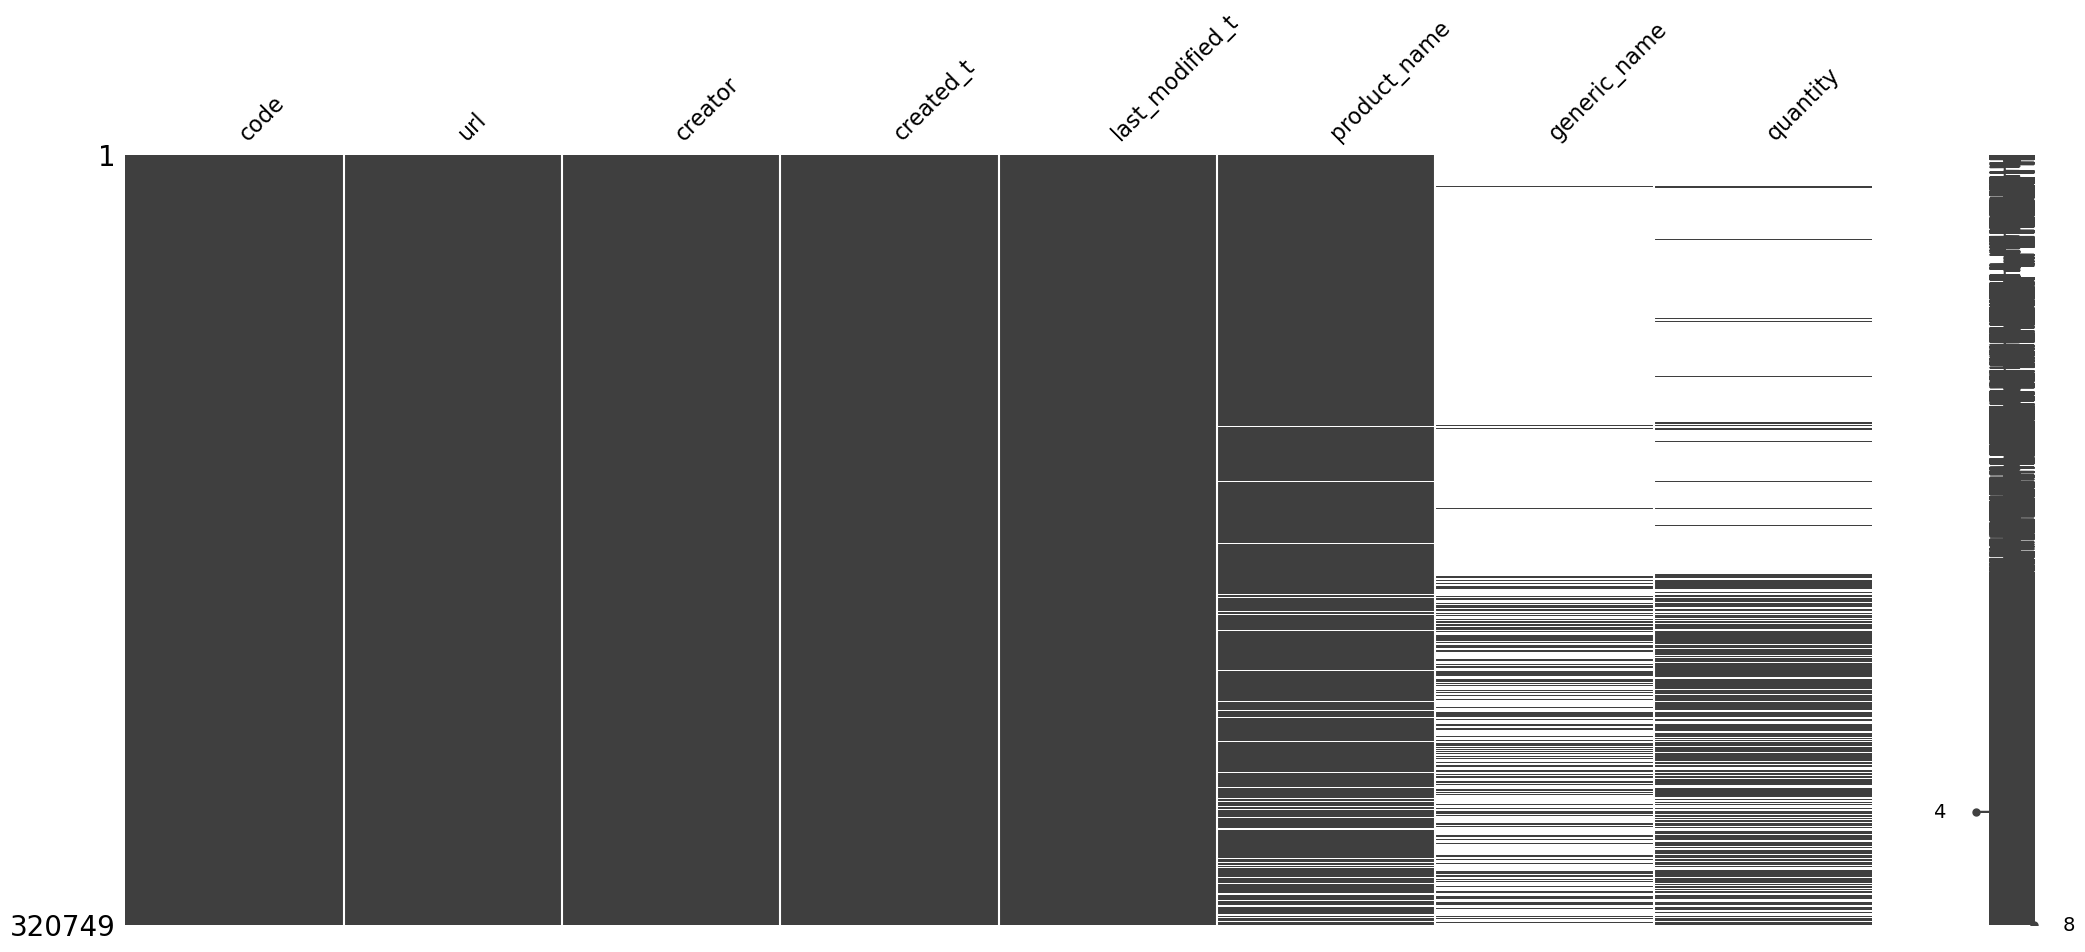

In [35]:
# les variables general_information
msno.matrix(data_cleaned.loc[:,data_cleaned.columns[data_cleaned.columns.isin(general_information)]]);

In [36]:
data_cleaned.loc[:,data_cleaned.columns[data_cleaned.columns.isin(general_information)]].isna().sum()/nbLigne

code               0.000000
url                0.000000
creator            0.000006
created_t          0.000000
last_modified_t    0.000000
product_name       0.055377
generic_name       0.835469
quantity           0.673265
dtype: float64

</br>

</br>

</br>

In [37]:
# general_information
col_to_drop += ['generic_name','url','creator', 'created_t', 'last_modified_t']
colgarder += ['code','product_name','quantity']

#Maj general_information
[general_information.remove(x) for x in col_to_drop]
general_information

['code', 'product_name', 'quantity']

</br>

</br>

</br>

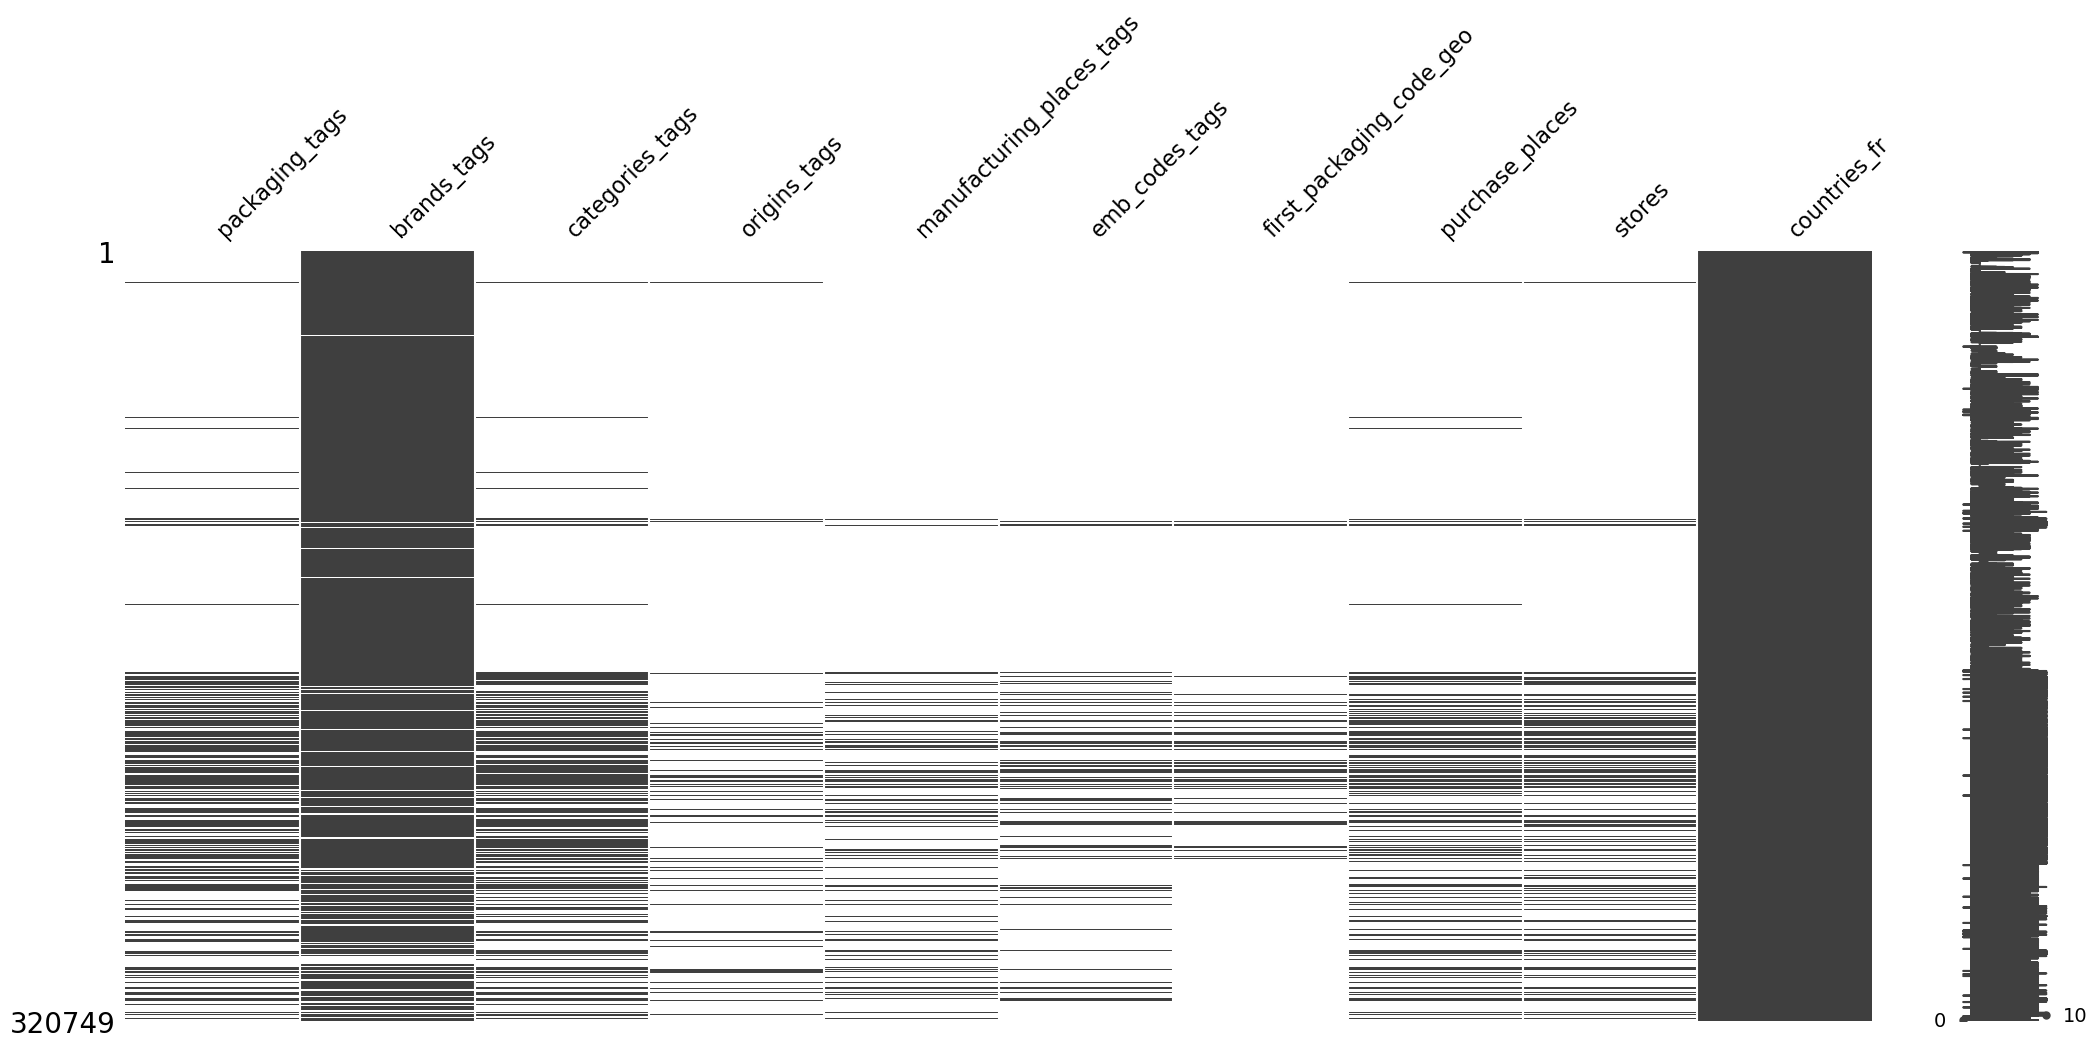

In [38]:
# les variables tags
msno.matrix(data_cleaned.loc[:,data_cleaned.columns[data_cleaned.columns.isin(tags)]]);

In [39]:
data_cleaned.loc[:,data_cleaned.columns[data_cleaned.columns.isin(tags)]].isna().sum()/nbLigne

packaging_tags               0.753823
brands_tags                  0.088533
categories_tags              0.736900
origins_tags                 0.931002
manufacturing_places_tags    0.886288
emb_codes_tags               0.908645
first_packaging_code_geo     0.941378
purchase_places              0.818643
stores                       0.838818
countries_fr                 0.000873
dtype: float64

categories_fr, main_categorie et categories_fr sont rempli de la meme façon.
Les produits ne possédant dinfos pour la variables categories ne possedent pas d'infos pour la variables main_category

In [40]:
# tags
col_to_drop += [ 'packaging_tags','brands_tags', 'categories_tags',
                'origins_tags','manufacturing_places_tags', 
                'emb_codes_tags','first_packaging_code_geo',
                'purchase_places','stores','countries_fr',
                #'cities',
                #'cities_tags','countries','countries_tags',
                #'emb_codes', 
                #'categories',
                 ]


#Maj tags
[tags.remove(x) for x in [ 'packaging_tags','brands_tags', 'categories_tags',
                'origins_tags','manufacturing_places_tags', 
                'emb_codes_tags','first_packaging_code_geo',
                'purchase_places','stores','countries_fr',]]
tags

[]

</br>

</br>

</br>

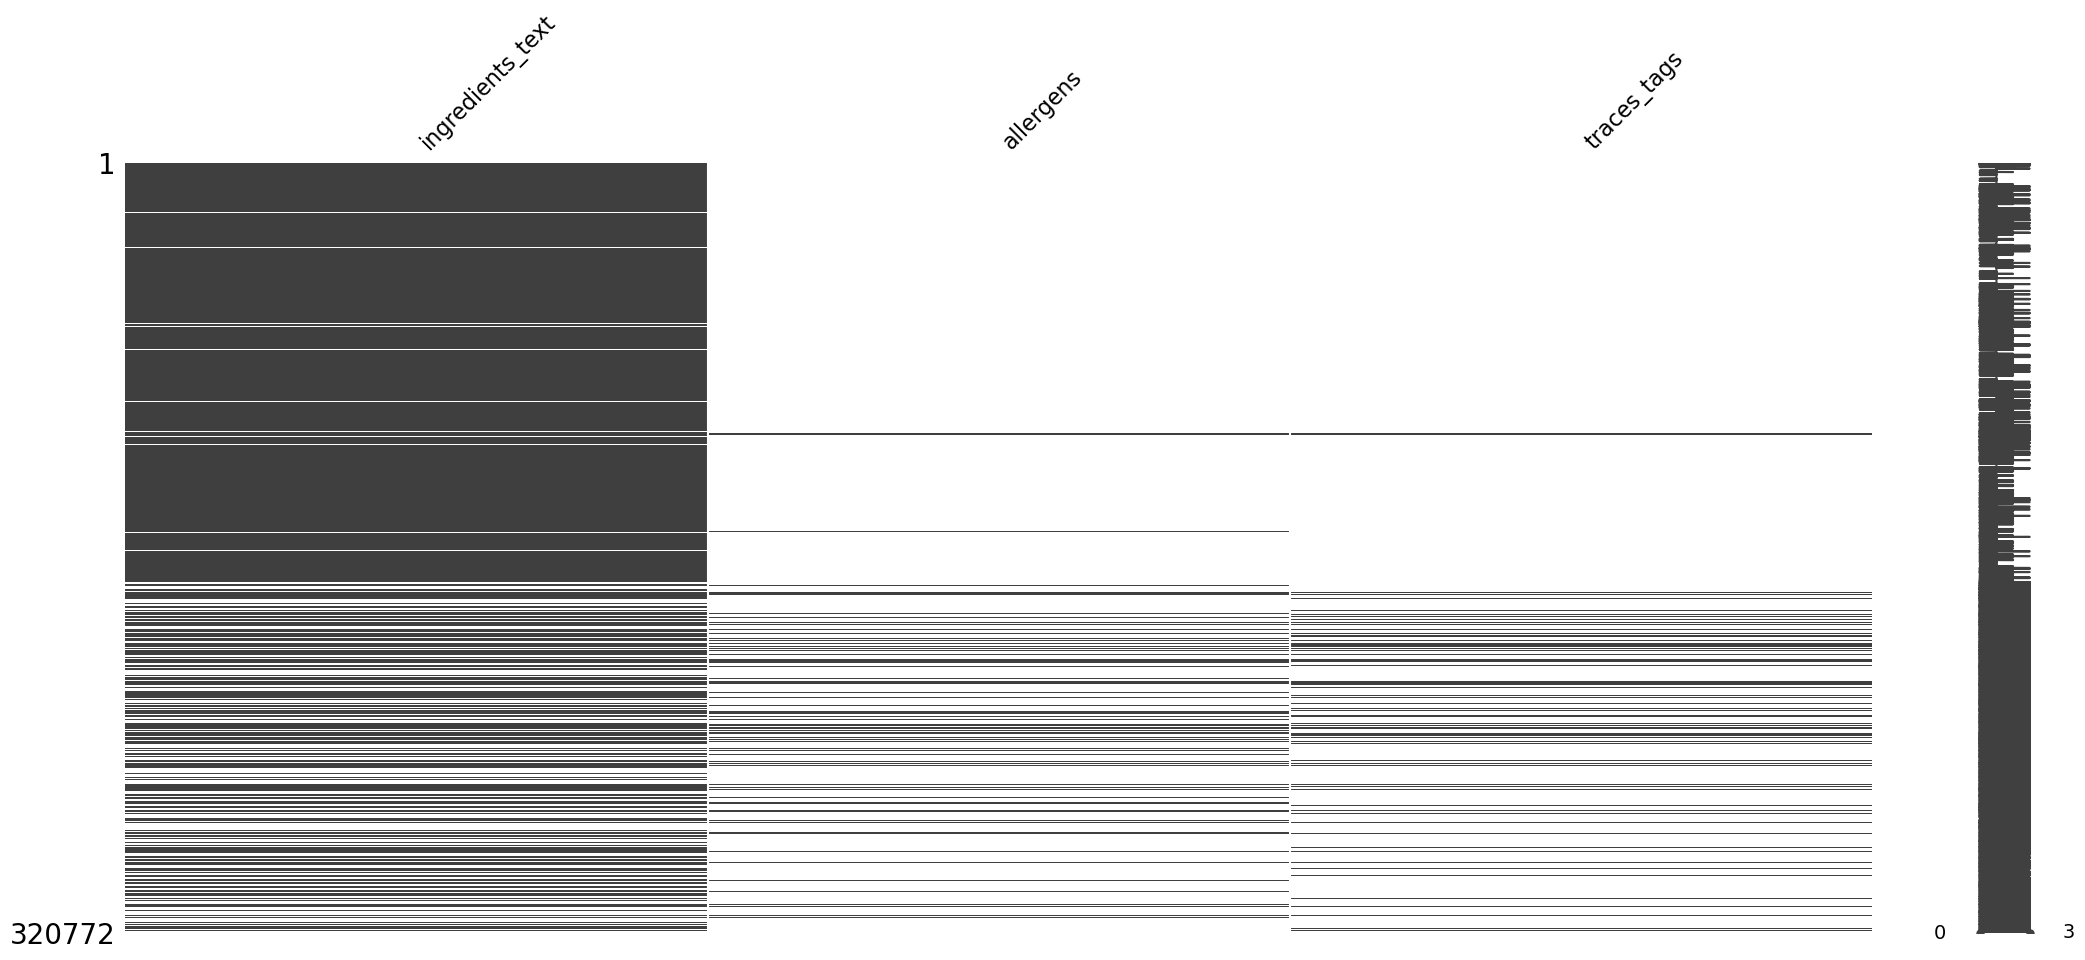

In [41]:
#les variables ingredients
msno.matrix(openfoodfacts.loc[:,openfoodfacts.columns[openfoodfacts.columns.isin(ingredients)]]);

In [42]:
openfoodfacts[ingredients].notna().sum()/nbLigne

ingredients_text    0.776189
allergens           0.088368
traces_tags         0.075851
dtype: float64

In [43]:
# ingredients
col_to_drop += ['ingredients_text','allergens', 'traces_tags']
#colgarder += ['ingredients_text']

#Maj tags
[ingredients.remove(x) for x in [ 'ingredients_text','allergens', 'traces_tags']]
ingredients

[]

</br>

</br>

</br>

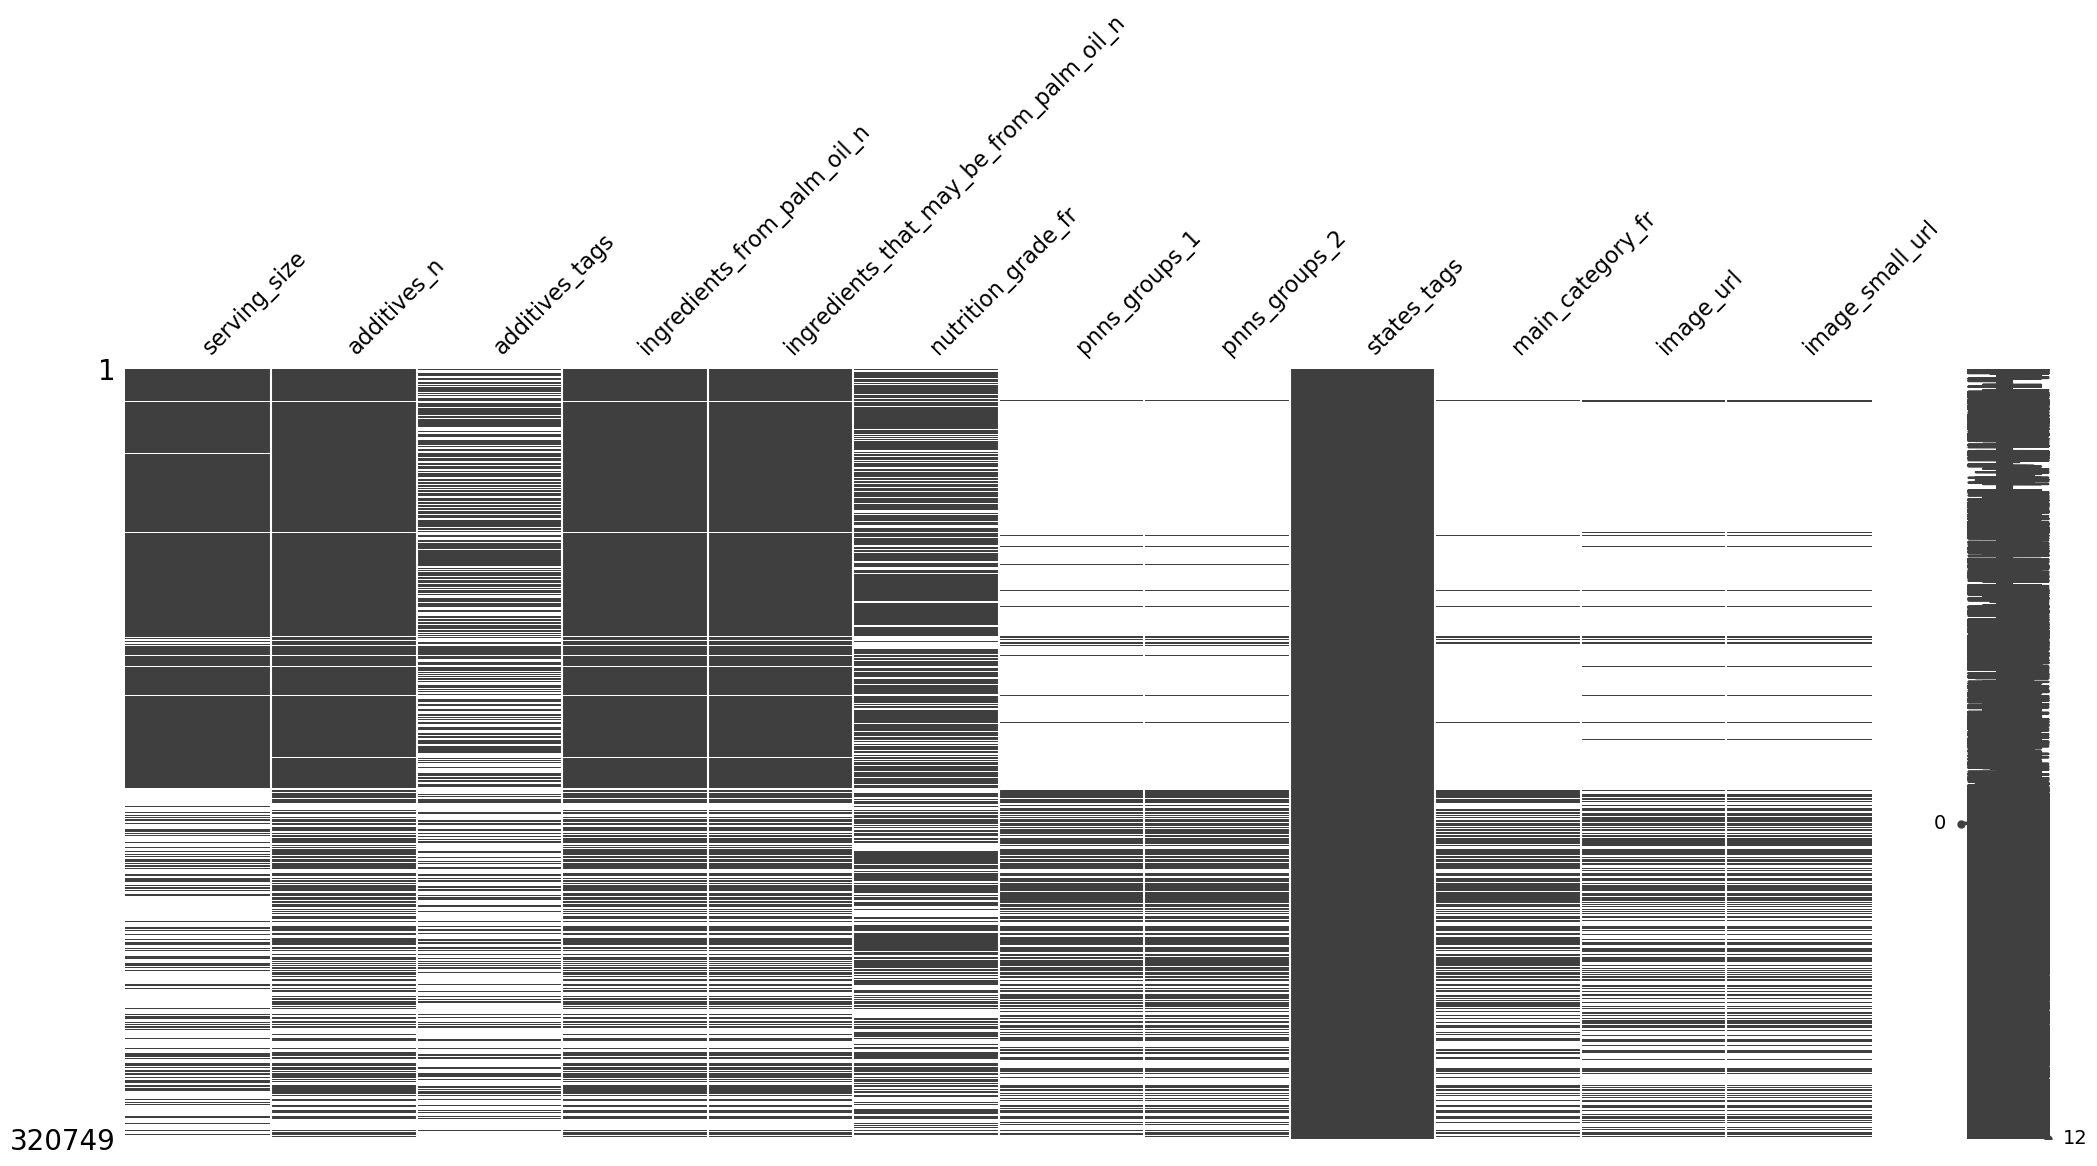

In [44]:
#les variables misc_data
msno.matrix(data_cleaned.loc[:,data_cleaned.columns[data_cleaned.columns.isin(misc_data)]]);

In [45]:
misc_data

['serving_size',
 'additives_n',
 'additives_tags',
 'ingredients_from_palm_oil_n',
 'ingredients_that_may_be_from_palm_oil_n',
 'nutrition_grade_fr',
 'pnns_groups_1',
 'pnns_groups_2',
 'states_tags',
 'main_category_fr',
 'image_url',
 'image_small_url']

In [46]:
pd.set_option('max_colwidth', None)

In [47]:
data_cleaned[['pnns_groups_1','pnns_groups_2']].notna().sum()/nbLigne

pnns_groups_1    0.285310
pnns_groups_2    0.294595
dtype: float64

In [48]:
data_cleaned[['pnns_groups_1','pnns_groups_2','main_category_fr']].describe()

pnns_groups_1 pnns_groups_2 main_category_fr
count          91513         94491            84366
unique            14            42             3543
top          unknown       unknown         Boissons
freq           22624         22624             6054

In [49]:
data_cleaned[['pnns_groups_1','pnns_groups_2']].drop_duplicates().sort_values('pnns_groups_1')

pnns_groups_1                     pnns_groups_2
10316                 Beverages  Artificially sweetened beverages
10358                 Beverages                      Fruit juices
65421                 Beverages                     Fruit nectars
226                   Beverages               Sweetened beverages
188                   Beverages             Non-sugared beverages
628        Cereals and potatoes                           Cereals
9779       Cereals and potatoes                 Breakfast cereals
23712      Cereals and potatoes                          Potatoes
177        Cereals and potatoes                             Bread
182        Cereals and potatoes                           Legumes
601             Composite foods                          Sandwich
185             Composite foods             Pizza pies and quiche
463             Composite foods                    One-dish meals
648              Fat and sauces                              Fats
239              Fat and sauces              Dressings and sauces
17433            Fish Meat Eggs                    Processed meat
10746            Fish Meat Eggs                  Fish and seafood
10372            Fish Meat Eggs                              Eggs
186              Fish Meat Eggs                              Meat
596       Fruits and vegetables                            Fruits
11299     Fruits and vegetables                      Dried fruits
174       Fruits and vegetables                        Vegetables
564       Fruits and vegetables                             Soups
29164   Milk and dairy products                    Dairy desserts
16560   Milk and dairy products                         Ice cream
637     Milk and dairy products                   Milk and yogurt
695     Milk and dairy products                            Cheese
1649               Salty snacks                        Appetizers
2324               Salty snacks                              Nuts
178178             Salty snacks          Salty and fatty products
568               Sugary snacks                Chocolate products
187               Sugary snacks                            Sweets
175               Sugary snacks                Biscuits and cakes
218764     cereals-and-potatoes                           legumes
181366     cereals-and-potatoes                           cereals
175455    fruits-and-vegetables                            fruits
494       fruits-and-vegetables                        vegetables
281268             salty-snacks                              nuts
66153             sugary-snacks                          pastries
46                      unknown                           unknown
0                           NaN                               NaN
591                         NaN               Alcoholic beverages
112591                      NaN                      Tripe dishes

In [198]:
# unknown
data_cleaned.loc[data_cleaned['pnns_groups_2']=='unknown','pnns_groups_2'] = np.nan
data_cleaned.loc[data_cleaned['pnns_groups_1']=='unknown','pnns_groups_1'] = np.nan

# remplacer les '-' par ' ' et transformer toutes valeurs en minuscules
data_cleaned.pnns_groups_2 = data_cleaned.pnns_groups_2.str.replace('-',' ',regex=True).str.lower()
data_cleaned.pnns_groups_1 = data_cleaned.pnns_groups_1.str.replace('-',' ',regex=True).str.lower()

<AxesSubplot:title={'center':'Camember pnns_groups_2'}, ylabel='pnns_groups_2'>

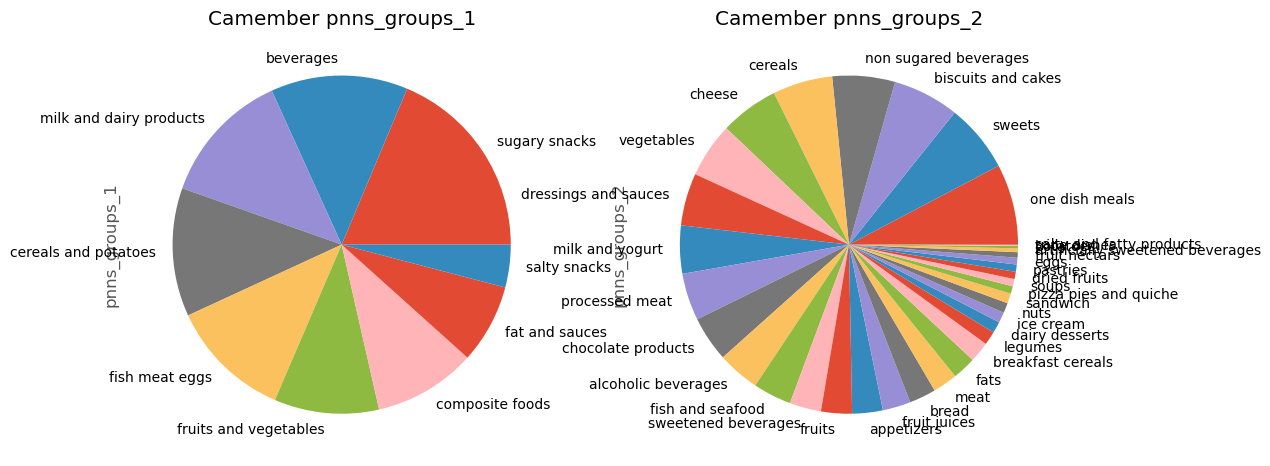

In [322]:
# pie plot
fig, axes = plt.subplots(nrows=1, ncols=2,  figsize=(12, 6))

axes[0].set_title('Camember pnns_groups_1')
data_cleaned.pnns_groups_1.value_counts().plot(kind='pie',ax =  axes[0],xlabel = 'red')
axes[0].xaxis.label.set_color('red')
axes[1].set_title('Camember pnns_groups_2')
data_cleaned.pnns_groups_2.value_counts().plot(kind='pie',ax =  axes[1])

In [51]:
# creation colonne "ingredients_from_palm_oil_nb"

In [52]:
# misc_data
col_to_drop += ['additives_tags','states_tags','image_url', 'image_small_url']


colgarder += ['serving_size','additives_n', 'ingredients_from_palm_oil_n',
              'ingredients_that_may_be_from_palm_oil_n', 'nutrition_grade_fr', 
              'pnns_groups_1', 'pnns_groups_2', 'main_category_fr']

#Maj tags
[misc_data.remove(x) for x in ['additives_tags','states_tags','image_url', 'image_small_url']]
misc_data

['serving_size',
 'additives_n',
 'ingredients_from_palm_oil_n',
 'ingredients_that_may_be_from_palm_oil_n',
 'nutrition_grade_fr',
 'pnns_groups_1',
 'pnns_groups_2',
 'main_category_fr']

</br>

</br>

</br>

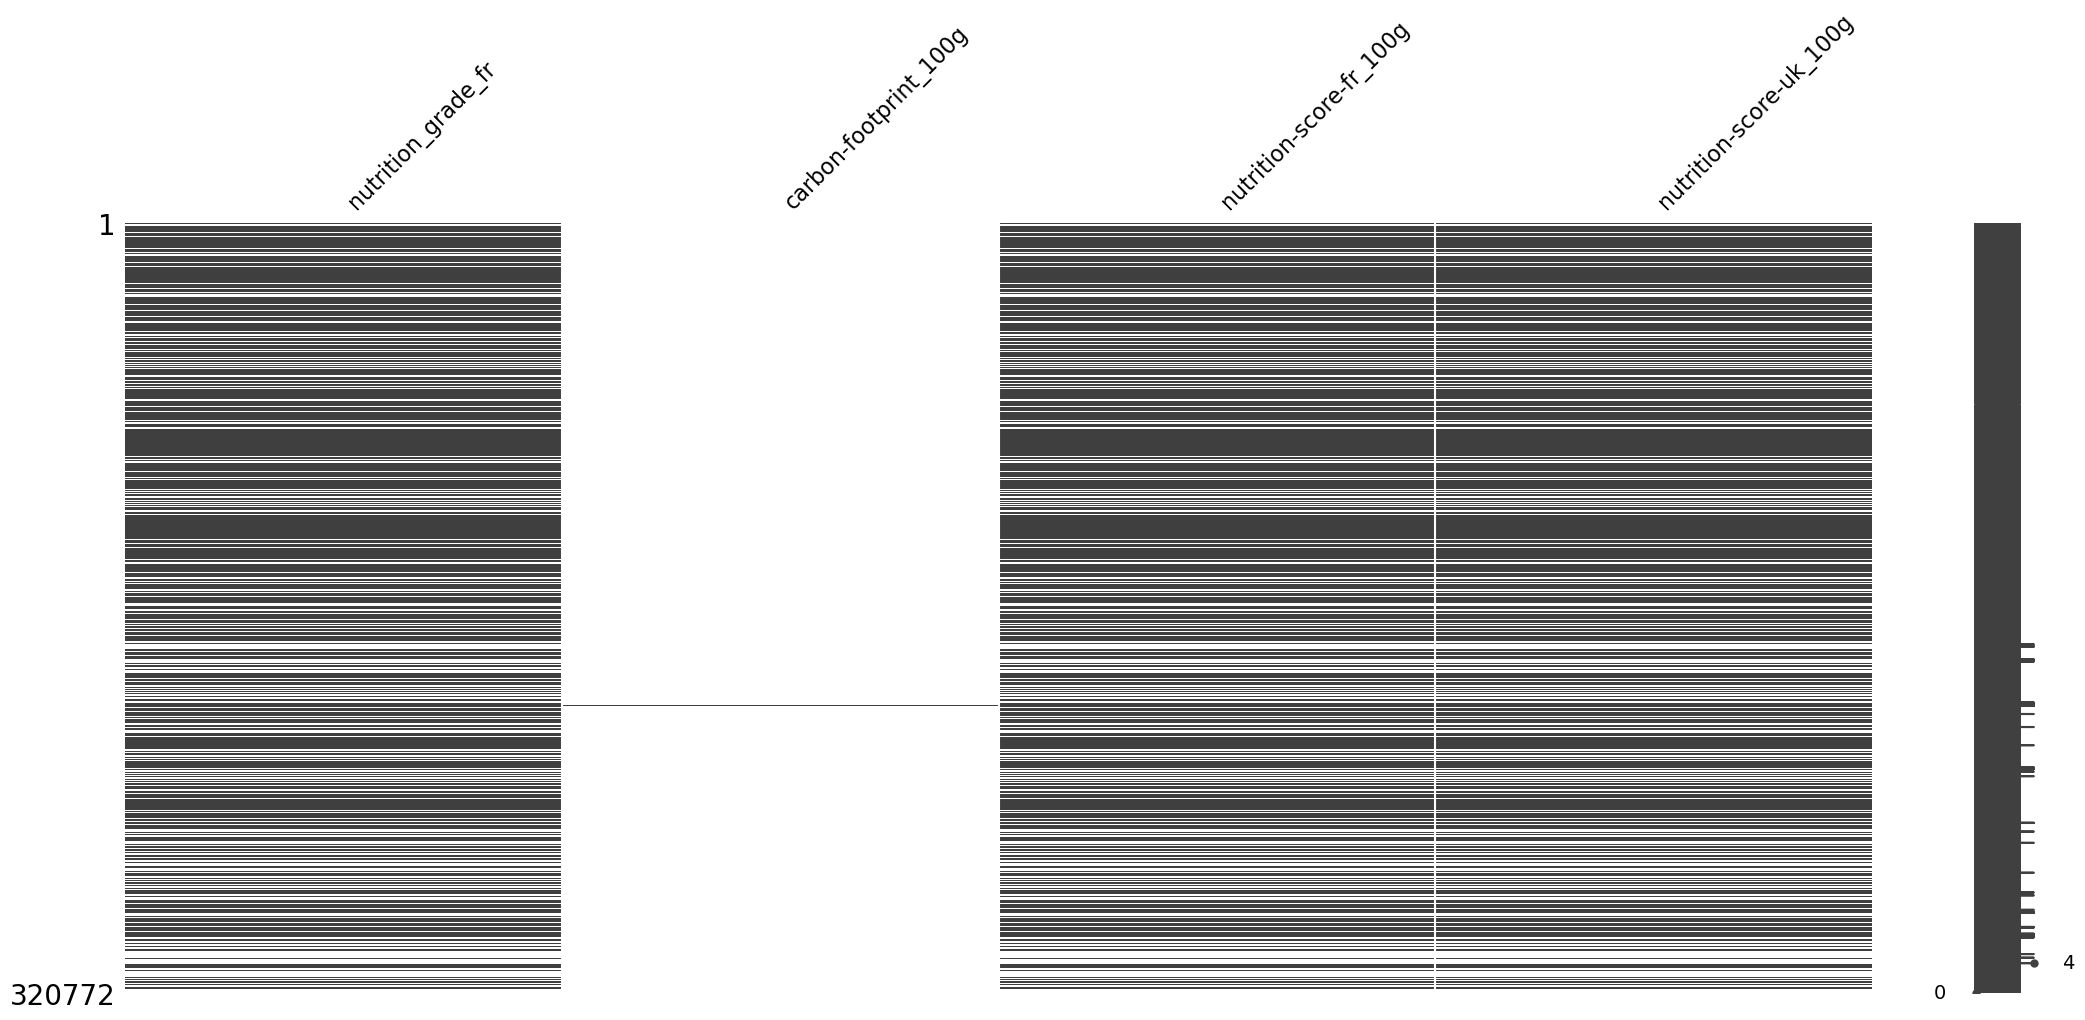

In [53]:
# les variables score_foot_print
msno.matrix(openfoodfacts.loc[:,data_cleaned.columns[data_cleaned.columns.isin(score_foot_print)]]);

In [54]:
data_cleaned.loc[:,data_cleaned.columns[data_cleaned.columns.isin(score_foot_print)]].isna().sum()/nbLigne

nutrition_grade_fr         0.310333
carbon-footprint_100g      0.999164
nutrition-score-fr_100g    0.310333
nutrition-score-uk_100g    0.310333
dtype: float64

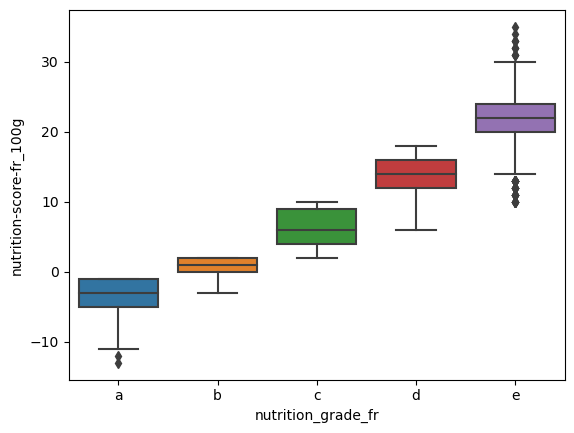

In [55]:
#data_cleaned[[ 'nutrition-score-fr_100g', 'data_cleaned.nutrition_grade_fr']].boxplot()
sns.boxplot(y='nutrition-score-fr_100g',
            x='nutrition_grade_fr',
            data=openfoodfacts.sample(10000).sort_values(by='nutrition_grade_fr'));

In [56]:
# score_foot_print
col_to_drop += ['nutrition_grade_uk','carbon-footprint_100g', 'nutrition-score-uk_100g']

colgarder += ['nutrition_grade_fr', 'nutrition-score-fr_100g']

#Maj tags
[score_foot_print.remove(x) for x in ['nutrition_grade_uk','carbon-footprint_100g', 'nutrition-score-uk_100g']]
score_foot_print

['nutrition_grade_fr', 'nutrition-score-fr_100g']

</br>

</br>

</br>

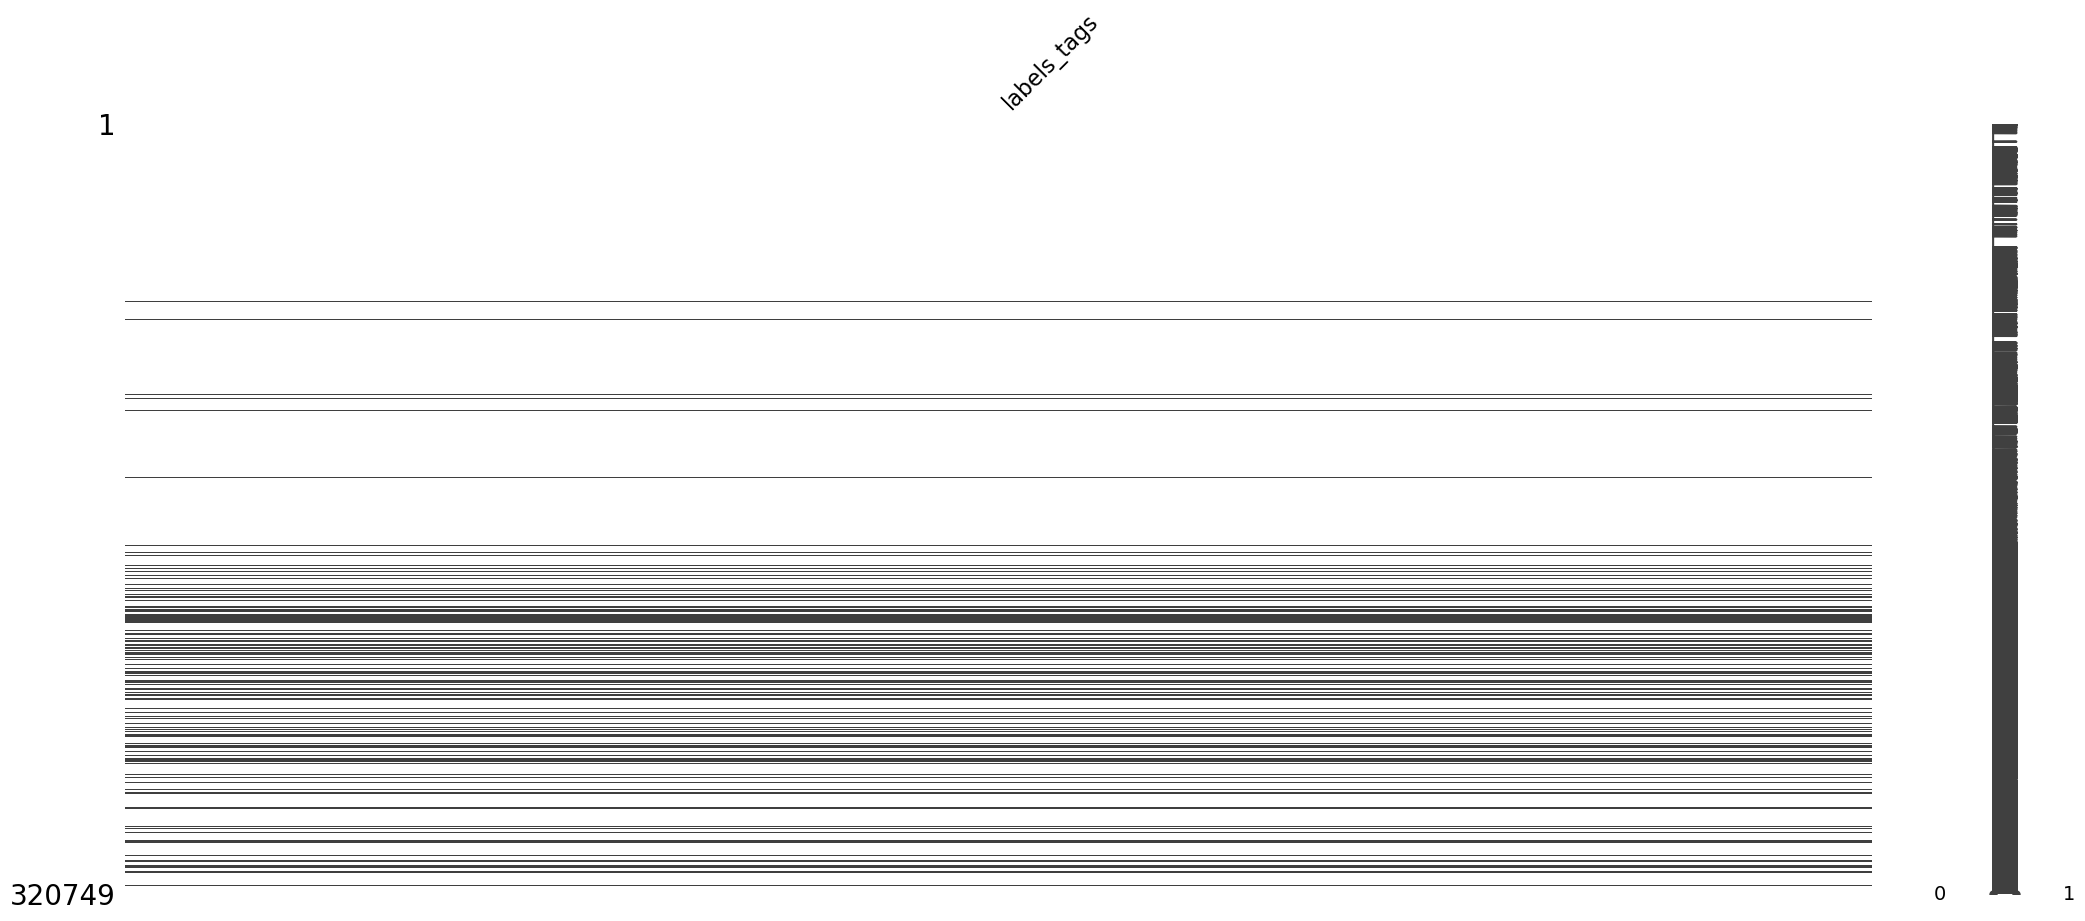

In [57]:
# les variables score_foot_print
msno.matrix(data_cleaned.loc[:,data_cleaned.columns[data_cleaned.columns.isin(labels)]]);

In [58]:
data_cleaned[data_cleaned.labels_tags.notna()][data_cleaned.columns[data_cleaned.columns.isin(labels)]].describe()

labels_tags
count                                                   46644
unique                                                  13653
top     en:organic,en:eu-organic,fr:ab-agriculture-biologique
freq                                                     5311

In [59]:
data_cleaned['presenceDeLabels'] = data_cleaned.labels_tags.notna()*1


# MAJ du DF nomColonnes
nomColonnes = pd.concat([nomColonnes,pd.DataFrame({'Colonnes':'presenceDeLabels',
                                                   'type_de_colonne':'score_foot_print',
                                                   'Nombre de valeurs manquantes':data_cleaned.presenceDeLabels.isna().sum()},
                                                 index = [data_cleaned.presenceDeLabels.isna().sum()])], 
                        axis=0)

In [60]:
# labels

# Variables à supprimer
col_to_drop += ['labels_tags']

# Variables à conserver
colgarder += ['presenceDeLabels']



#Maj tags
labels = ['presenceDeLabels']
labels

['presenceDeLabels']

</br>

</br>

</br>

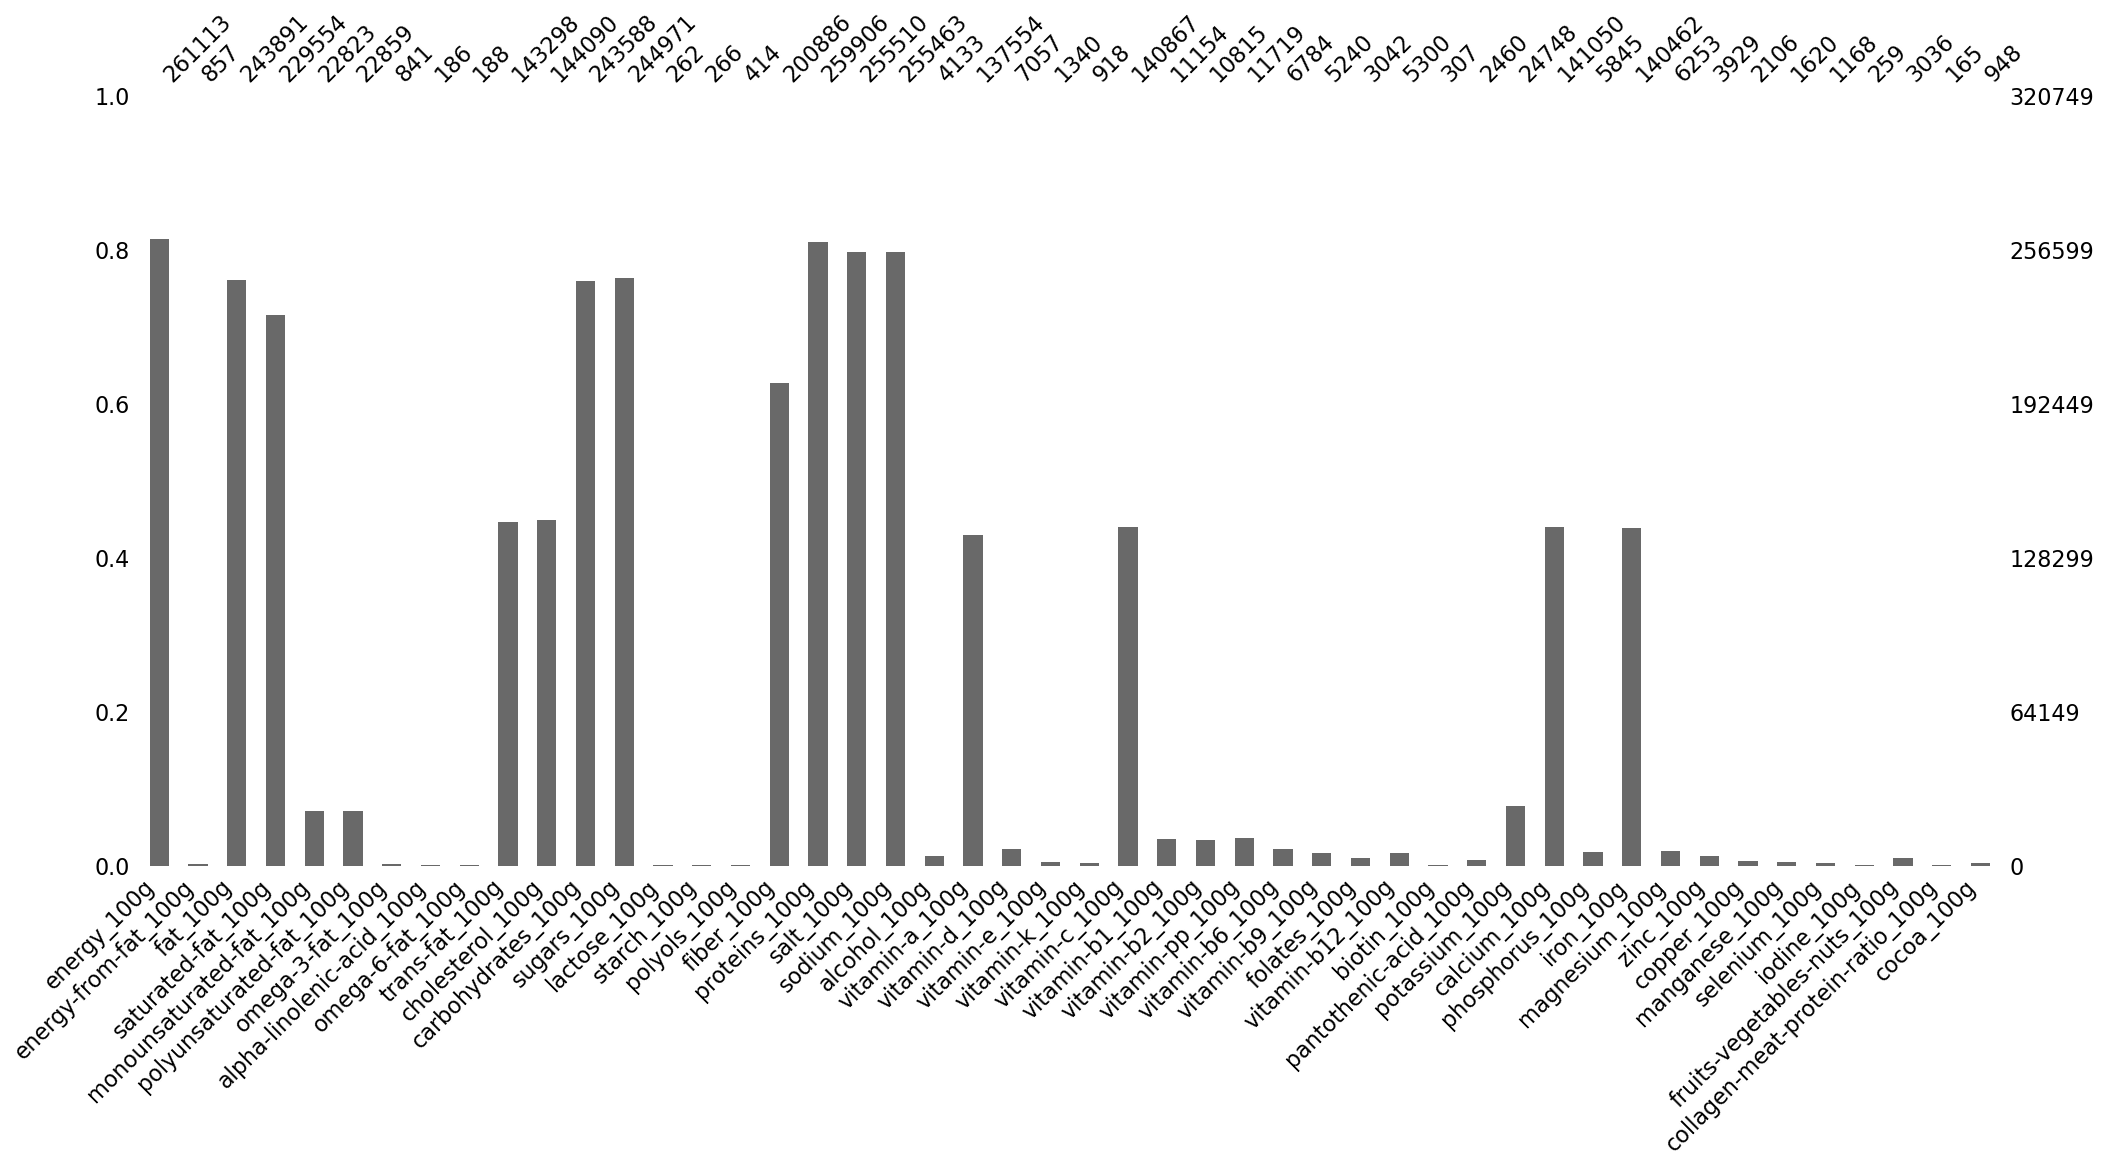

In [61]:
# nutrition_facts
msno.bar(data_cleaned.loc[:,data_cleaned.columns[data_cleaned.columns.isin(nutrition_facts)] ]);

In [62]:
pd.DataFrame(data_cleaned.loc[:,data_cleaned.columns[data_cleaned.columns.isin(nutrition_facts)] ].isna().sum()/nbLigne).T\
.style.background_gradient(cmap='Blues').format("{:.2%}")

In [63]:
nomColonnes

Colonnes      type_de_colonne  \
0                                      code  general_information   
1                                       url  general_information   
2                                   creator  general_information   
3                                 created_t  general_information   
4                           last_modified_t  general_information   
5                              product_name  general_information   
6                              generic_name  general_information   
7                                  quantity  general_information   
8                            packaging_tags                 tags   
9                               brands_tags                 tags   
10                          categories_tags                 tags   
11                             origins_tags                 tags   
12                manufacturing_places_tags                 tags   
13                              labels_tags               labels   
14                           emb_codes_tags                 tags   
15                 first_packaging_code_geo                 tags   
16                          purchase_places                 tags   
17                                   stores                 tags   
18                             countries_fr                 tags   
19                         ingredients_text          ingredients   
20                                allergens          ingredients   
21                              traces_tags          ingredients   
22                             serving_size            misc_data   
23                              additives_n            misc_data   
24                           additives_tags            misc_data   
25              ingredients_from_palm_oil_n            misc_data   
26  ingredients_that_may_be_from_palm_oil_n            misc_data   
27                       nutrition_grade_fr     score_foot_print   
28                            pnns_groups_1            misc_data   
29                            pnns_groups_2            misc_data   
30                              states_tags            misc_data   
31                         main_category_fr            misc_data   
32                                image_url            misc_data   
33                          image_small_url            misc_data   
34                              energy_100g      nutrition_facts   
35                     energy-from-fat_100g      nutrition_facts   
36                                 fat_100g      nutrition_facts   
37                       saturated-fat_100g      nutrition_facts   
38                 monounsaturated-fat_100g      nutrition_facts   
39                 polyunsaturated-fat_100g      nutrition_facts   
40                         omega-3-fat_100g      nutrition_facts   
41                alpha-linolenic-acid_100g      nutrition_facts   
42                         omega-6-fat_100g      nutrition_facts   
43                           trans-fat_100g      nutrition_facts   
44                         cholesterol_100g      nutrition_facts   
45                       carbohydrates_100g      nutrition_facts   
46                              sugars_100g      nutrition_facts   
47                             lactose_100g      nutrition_facts   
48                              starch_100g      nutrition_facts   
49                             polyols_100g      nutrition_facts   
50                               fiber_100g      nutrition_facts   
51                            proteins_100g      nutrition_facts   
52                                salt_100g      nutrition_facts   
53                              sodium_100g      nutrition_facts   
54                             alcohol_100g      nutrition_facts   
55                           vitamin-a_100g      nutrition_facts   
56                           vitamin-d_100g      nutrition_facts   
57                           vitamin-e_100g      nutrition_facts   
58                     

Au total le jeu de données contient 48 colonnes contenant des informations sur les valeurs nutritives. 
Parmi ces colonnes, 33 sont composées de plus de 60% de valeurs manquantes


''

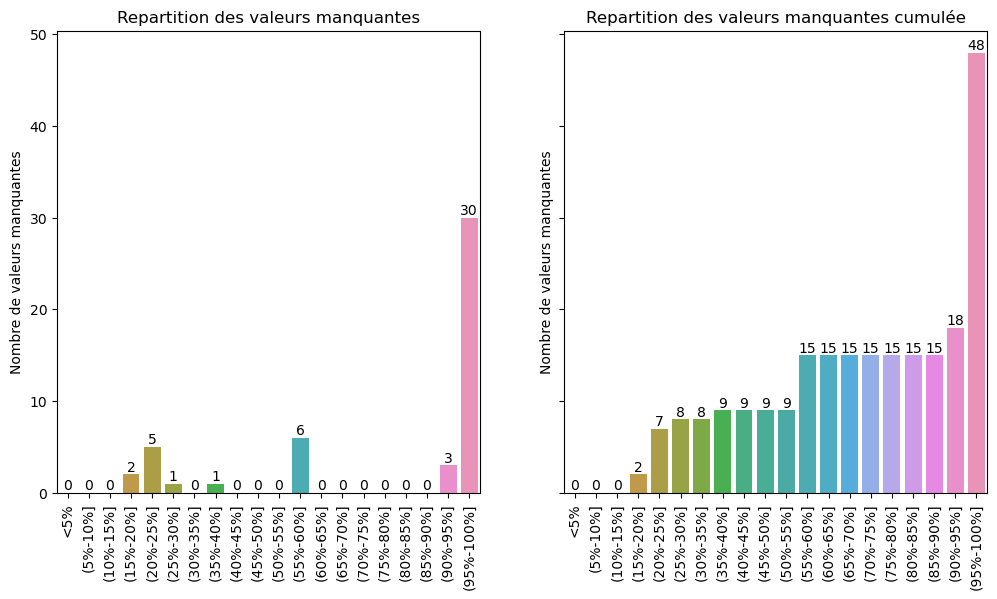

In [64]:
threshold_ = 0.6
print('Au total le jeu de données contient {} colonnes contenant des informations sur les valeurs nutritives. \nParmi ces colonnes, {} sont composées de plus de {pourc:.0%} de valeurs manquantes'
      .format((nomColonnes.type_de_colonne=='nutrition_facts').sum(),
              (data_cleaned.loc[:,data_cleaned.columns[data_cleaned.columns.isin(nutrition_facts)] ].isna().sum()>=nbLigne*threshold_).sum(),pourc=threshold_
              ))

nbin = 20
interbin = 100/nbin

xlab = ['<{:.0f}%'.format(interbin) if i==0 else '({:.0f}%-{:.0f}%]'.format(i*interbin,(i+1)*interbin) for i in range(nbin)]
ycut = pd.cut(nomColonnes[nomColonnes.type_de_colonne=='nutrition_facts']['Nombre de valeurs manquantes']/nbLigne, 
                     [ i/nbin for i in range(nbin+1)], # ajoute 1 pour obtenir la derniere tranche
                     include_lowest=False).value_counts().sort_index()

fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(12, 6))

axes[0].set_title('Repartition des valeurs manquantes')
sns.barplot(x=ycut.index, y=ycut,ax=axes[0] )
axes[0].set_xticks(range(nbin))   # Attention cette fois on ajoute pas +1
axes[0].set_xticklabels(xlab, rotation=90)
axes[0].bar_label(axes[0].containers[0])

axes[1].set_title('Repartition des valeurs manquantes cumulée')
sns.barplot(x=ycut.index, y=ycut.cumsum(),ax=axes[1] )
axes[1].set_xticks(range(nbin))# Attention cette fois on ajoute pas +1
axes[1].set_xticklabels(xlab, rotation=90)
axes[1].bar_label(axes[1].containers[0])

;

In [65]:
# nutrition_facts

print('le seuil ',threshold_)
for col,typc,nNa in zip(nomColonnes.Colonnes,
                        nomColonnes.type_de_colonne,
                        nomColonnes['Nombre de valeurs manquantes']) :
    if typc =='nutrition_facts':
        if nNa >= (nbLigne * threshold_): # suppr col qui possèdent 95% de valeurs nulles
            col_to_drop.append(col)
        else:
            colgarder.append(col)

le seuil  0.6


In [66]:
colgarder

['code',
 'product_name',
 'quantity',
 'serving_size',
 'additives_n',
 'ingredients_from_palm_oil_n',
 'ingredients_that_may_be_from_palm_oil_n',
 'nutrition_grade_fr',
 'pnns_groups_1',
 'pnns_groups_2',
 'main_category_fr',
 'nutrition_grade_fr',
 'nutrition-score-fr_100g',
 'presenceDeLabels',
 'energy_100g',
 'fat_100g',
 'saturated-fat_100g',
 'trans-fat_100g',
 'cholesterol_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'fiber_100g',
 'proteins_100g',
 'salt_100g',
 'sodium_100g',
 'vitamin-a_100g',
 'vitamin-c_100g',
 'calcium_100g',
 'iron_100g']

In [67]:
print('Parmi les {} colonnes, nous en supprimons {} et gardons {}'.format(nbCol,len(col_to_drop),len(colgarder) ) )

Parmi les 85 colonnes, nous en supprimons 59 et gardons 29


In [68]:
# A-t-on oublié certaines colonnes
listOublie = [x  for x in data_cleaned.columns if x not in col_to_drop+colgarder ]
print('Combien de variables ont été oubliées: ',len(listOublie) )

Combien de variables ont été oubliées:  0


</br>

## Etude des correlations

In [69]:
data_cleaned[colgarder].corr()\
.style.background_gradient(cmap = sns.color_palette("blend:red,green", as_cmap=True),axis=None)

#### Les matieres grasses

In [70]:
data_cleaned[['fat_100g', 'saturated-fat_100g','trans-fat_100g']].notna().sum()

fat_100g              243891
saturated-fat_100g    229554
trans-fat_100g        143298
dtype: int64

In [71]:
colgarder.remove("saturated-fat_100g")
colgarder.remove('trans-fat_100g')
col_to_drop.extend(['saturated-fat_100g','trans-fat_100g'])

#### le sel et le sodium

In [72]:
saltSodiumX = data_cleaned[['salt_100g' , 'sodium_100g']].dropna()
a = round(saltSodiumX.cov().iloc[0,1]/(saltSodiumX.cov().iloc[1,1]),4)
b = round(saltSodiumX.salt_100g.mean()- a*saltSodiumX.sodium_100g.mean(),4)

a,b

(2.54, 0.0)

La formule:
$Y_{salt-100g} = 2.54 * X_{sodium-100g}$

In [73]:
compute_nb_mising_values(data_cleaned[['salt_100g', 'sodium_100g']])
#.notna().sum()

Taux de valeurs non nulles  Nombre de valeurs manquantes
salt_100g                         79.66                         65239
sodium_100g                       79.65                         65286

In [74]:
colgarder.remove("sodium_100g")
col_to_drop.extend(['sodium_100g'])

#### Les autres colonnes qui n'ont pas de lien avec notre problème


In [75]:
colgarder = [x for x in colgarder if x not in ['additives_n','ingredients_from_palm_oil_n','ingredients_that_may_be_from_palm_oil_n','presenceDeLabels']]
col_to_drop.extend(['additives_n','ingredients_from_palm_oil_n','ingredients_that_may_be_from_palm_oil_n','presenceDeLabels'])

In [76]:
data_cleaned[colgarder].sample(5)

code  \
167511  0861496000031   
36391   0039759156065   
291702  7613033048074   
250743  3700663000399   
146323  0789707720144   

                                                       product_name quantity  \
167511                Jica Chips, Crispy Baked Root Veggie, Cheddar      NaN   
36391                          Roasted & Salted Cashews With Pepper      NaN   
291702                                              Kartoffelcreme     120 g   
250743  Les Assaisonnettes - La Tonique - Gingembre, Curcuma Citron    36 cl   
146323                    Power Greens Loaded With Spinach And Kale      NaN   

        serving_size nutrition_grade_fr   pnns_groups_1         pnns_groups_2  \
167511  26 g (1 BAG)                  d             NaN                   NaN   
36391   28 g (1 ONZ)                  d             NaN                   NaN   
291702         250 g                  c             NaN                   NaN   
250743           NaN                  c  fat and sauces  dressings and sauces   
146323  85 g (2 cup)                  a             NaN                   NaN   

       main_category_fr nutrition_grade_fr  nutrition-score-fr_100g  \
167511              NaN                  d                     13.0   
36391               NaN                  d                     13.0   
291702              NaN                  c                      3.0   
250743         Epicerie                  c                     10.0   
146323              NaN                  a                     -5.0   

        energy_100g  fat_100g  cholesterol_100g  carbohydrates_100g  \
167511       1770.0      9.62             0.019               73.08   
36391        2389.0     46.43             0.000               28.57   
291702        171.0      1.50               NaN                5.60   
250743       2000.0     51.00               NaN                2.30   
146323        121.0      0.00             0.000                3.53   

        sugars_100g  fiber_100g  proteins_100g  salt_100g  vitamin-a_100g  \
167511        23.08        19.2           7.69    1.22174        0.000000   
36391          7.14         3.6          17.86    0.63500        0.000000   
291702         2.20         0.3           1.00    0.84000             NaN   
250743         0.00         1.1           1.00    0.89000             NaN   
146323         0.00         2.4           3.53    0.22352        0.002647   

        vitamin-c_100g  calcium_100g  iron_100g  
167511          0.0000         0.231    0.00138  
36391           0.0000         0.071    0.00643  
291702             NaN           NaN        NaN  
250743             NaN           NaN        NaN  
146323          0.0565         0.094    0.00169

#### etude des unités de mesure

In [77]:
etude_test = data_cleaned[data_cleaned.columns[(~data_cleaned.columns.isin(nutrition_facts)) & (data_cleaned.columns.isin(colgarder))]]\
.drop(columns=['code','product_name','main_category_fr']).copy()

In [78]:
etude_test.columns

Index(['quantity', 'serving_size', 'nutrition_grade_fr', 'pnns_groups_1',
       'pnns_groups_2', 'nutrition-score-fr_100g'],
      dtype='object')

In [79]:
etude_test.serving_size[etude_test.serving_size.notna()].str.lower().str.replace('\\(.+[^(]\\)','',regex=True)\
.str.replace('[0-9]','',regex=True)\
.str.replace('[\\,\\*\\. ]','',regex=True)\
.str.replace(' ','',regex=True).value_counts().index[:5].to_list()+etude_test.quantity[etude_test.quantity.notna()].str.lower().str.replace('\\(.+[^(]\\)','',regex=True)\
.str.replace('[0-9]','',regex=True)\
.str.replace('[\\,\\*\\. ]','',regex=True)\
.str.replace(' ','',regex=True).value_counts().index[:10].to_list()

['g',
 'ml',
 'cl',
 'l',
 '',
 'g',
 'l',
 'ml',
 'cl',
 'kg',
 '',
 'gr',
 'oz',
 'xg',
 'ge']

In [80]:
data_cleaned[['quantity','url','serving_size']][etude_test.quantity.str.lower().str.replace('\\(.+[^(]\\)','',regex=True)\
.str.replace('[0-9]','',regex=True)\
.str.replace('[\\,\\*\\. ]','',regex=True)\
.str.replace(' ','',regex=True)=='xg'].sample(10)

quantity  \
111655      6x125g   
181435       4x90g   
226481  4 x 125 g.   
200175     25 X 2g   
234150       3x25g   
301004   3 x 200 g   
248082      2x125g   
203910   12 x 40 g   
248053    4 x 90 g   
250275      4x150g   

                                                                                                                   url  \
111655                       http://world-fr.openfoodfacts.org/produit/01466287/low-fat-red-fruits-yogurts-sainsbury-s   
181435                          http://world-fr.openfoodfacts.org/produit/20816971/pom-go-pomme-vergers-gourmands-lidl   
226481  http://world-fr.openfoodfacts.org/produit/3339520045251/pechalou-yaourts-au-lait-entier-aromatises-citron-vert   
200175                     http://world-fr.openfoodfacts.org/produit/3222472217183/the-noir-aromatise-bergamote-casino   
234150                                   http://world-fr.openfoodfacts.org/produit/3456300006315/grainergie-jardin-bio   
301004                              http://world-fr.openfoodfacts.org/produit/8000340876114/zuegg-nettare-di-albicocca   
248082                      http://world-fr.openfoodfacts.org/produit/3608580782254/tarte-tatin-aux-pommes-bonne-maman   
203910                                    http://world-fr.openfoodfacts.org/produit/3245412496509/briochette-carrefour   
248053                   http://world-fr.openfoodfacts.org/produit/3608580772507/dessert-pomme-fraise-framboise-andros   
250275            http://world-fr.openfoodfacts.org/produit/3700311820973/4-croissants-au-jambon-tous-les-jours-casino   

       serving_size  
111655         125g  
181435          NaN  
226481        125 g  
200175          NaN  
234150          NaN  
301004          NaN  
248082         125g  
203910         40 g  
248053          NaN  
250275         150g

In [81]:
unites = {
    #les liquides
    'l' : 'litre', 'ml': 'litre', 'cl': 'litre', 'litre': 'litre','litres': 'litre',
    'floz': 'litre', 'xcl':'litre','xml': 'litre', 'g/ml':'litre', 'le':'litre',
    
    # les aliments solides (ou mous)
    'kg': 'poids','g' : 'poids', 'gr': 'poids', 'oz': 'poids', 'xg': 'poids',  'ge': 'poids',
    'grammes': 'poids','г': 'poids',  'xg=g': 'poids', 'ozg': 'poids', 'grs': 'poids', 'lb': 'poids',
    
    # ceux qui peuvent etre definis
    'kg[x]': 'petit pot/yaourt', 'gml': 'bocal/conserve', 'mlg':'creme/sauce',
    
    # part ou portion de ensemble plus grand
    'sachets': 'unité','oeufs': 'unité','tranches': 'unité','x': 'unité',
    
}

unitesAbb = [
    #les liquides
    'l' , 'ml', 'cl', 'litre','litres', 'floz', 'xcl','xml', 'g/ml', 'le',
    
    # les aliments solides (ou mous)
    'kg','g' , 'gr', 'oz', 'xg',  'ge', 'grammes','г',  'xg=g', 'ozg', 'grs', 'lb',
    
    # ceux qui peuvent etre definis
    'kg[x]', 'gml', 'mlg',
    
    # part ou portion de ensemble plus grand
    'sachets','oeufs','tranches','x'
]

In [82]:
#creation colonnes unites mini
data_cleaned['unites_abb'] = [y if y in unitesAbb else x if x in unitesAbb else np.nan for x,y in zip(data_cleaned.quantity.str.lower().str.replace('\\(.+[^(]\\)','',regex=True)\
.str.replace('[0-9]','',regex=True)\
.str.replace('[\\,\\*\\. ]','',regex=True)\
.str.replace(' ','',regex=True),
                    data_cleaned.serving_size.str.lower().str.replace('\\(.+[^(]\\)','',regex=True)\
.str.replace('[0-9]','',regex=True)\
.str.replace('[\\,\\*\\. ]','',regex=True)\
.str.replace(' ','',regex=True) )]

#creation colonnes unites
data_cleaned['unites'] = [y if not y is np.nan else x for x,y in zip(data_cleaned.quantity.str.lower().str.replace('\\(.+[^(]\\)','',regex=True)\
.str.replace('[0-9]','',regex=True)\
.str.replace('[\\,\\*\\. ]','',regex=True)\
.str.replace(' ','',regex=True).map(unites),
                    data_cleaned.serving_size.str.lower().str.replace('\\(.+[^(]\\)','',regex=True)\
.str.replace('[0-9]','',regex=True)\
.str.replace('[\\,\\*\\. ]','',regex=True)\
.str.replace(' ','',regex=True).map(unites))]

<AxesSubplot:>

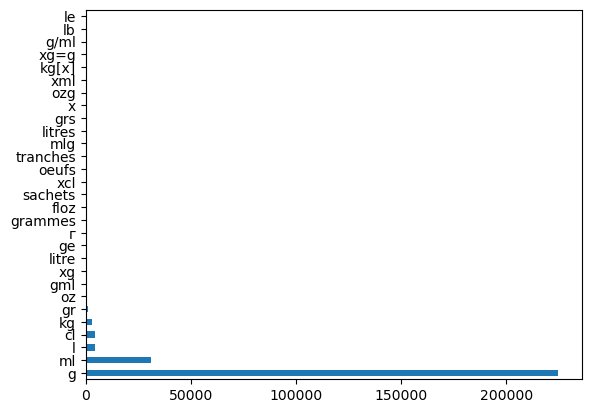

In [83]:
data_cleaned['unites_abb'].value_counts().plot(kind='barh')

<AxesSubplot:>

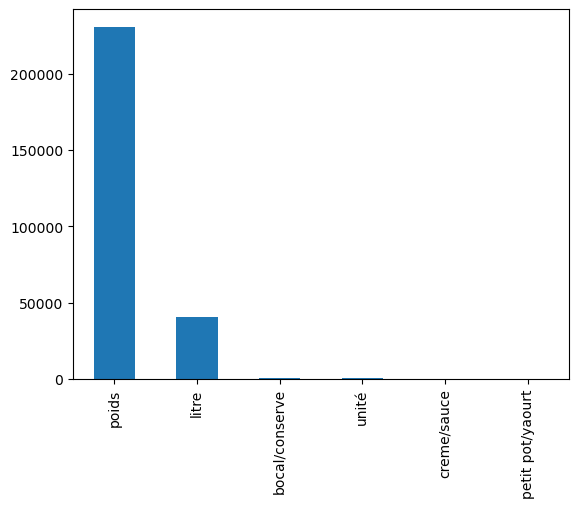

In [84]:
data_cleaned['unites'].value_counts().plot(kind='bar')

In [85]:
# get dummies
data_cleaned[['bocal/conserve','creme/sauce','litre','petit pot/yaourt','poids','unité']] = pd.get_dummies(data_cleaned.unites)

In [86]:
colgarder += ['bocal/conserve','creme/sauce','litre','petit pot/yaourt','poids','unité']

In [87]:
del etude_test

</br>

</br>

## Gestion des outliers

#### les boxplots

In [88]:
numCol = data_cleaned[colgarder].select_dtypes(include=[np.number]).columns.tolist()

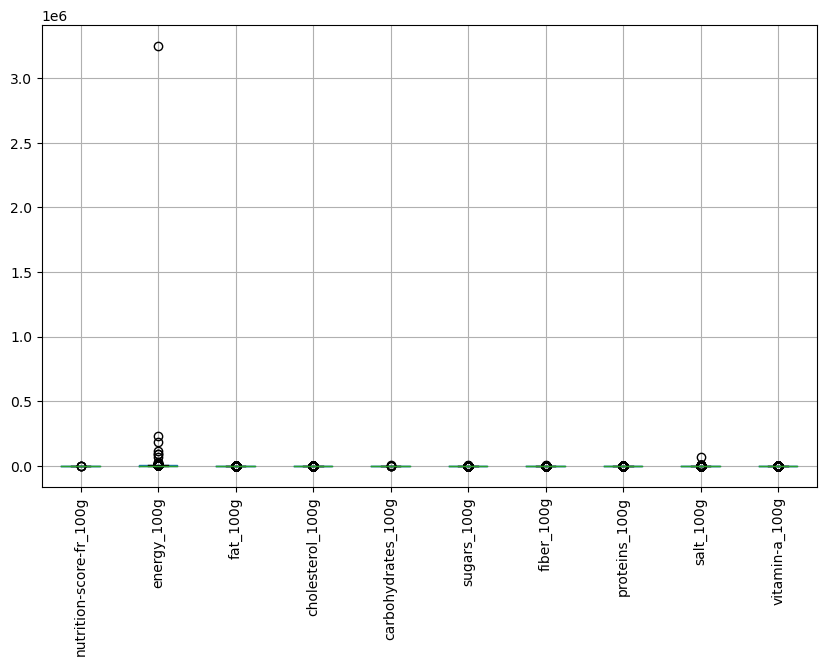

In [89]:
colNumTested = [colgarder[i] for i,colk in enumerate(numCol)  ]
data_cleaned[colNumTested].boxplot(rot=90,figsize = (10,6))
del colNumTested;

In [90]:
data_cleaned[data_cleaned.energy_100g==data_cleaned.energy_100g.max()][['energy_100g','url']]

energy_100g  \
212928    3251373.0   

                                                                             url  
212928  http://world-fr.openfoodfacts.org/produit/3257983143096/pois-casses-cora

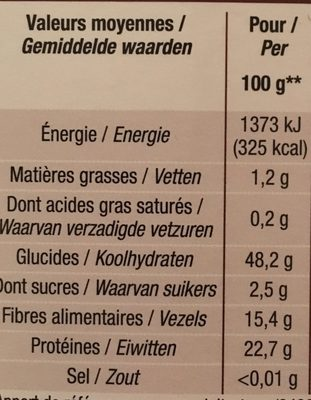

In [91]:
data_cleaned.loc[data_cleaned.code=='3257983143096','energy_100g'] = 1373
data_cleaned.loc[data_cleaned.code=='8710573641501','energy_100g'] = 2312
data_cleaned.loc[data_cleaned.code=='3661405001053','energy_100g'] = 764
data_cleaned.loc[data_cleaned.code=='0201203040026','energy_100g'] = 3700
data_cleaned.loc[data_cleaned.code=='0619309100979','energy_100g'] = 92

#### Les valeurs négatives

In [92]:
data_cleaned[numCol].apply(lambda x : x<0).sum()

nutrition-score-fr_100g    35706
energy_100g                    0
fat_100g                       0
cholesterol_100g               0
carbohydrates_100g             0
sugars_100g                    7
fiber_100g                     1
proteins_100g                  3
salt_100g                      0
vitamin-a_100g                 1
vitamin-c_100g                 1
calcium_100g                   0
iron_100g                      1
bocal/conserve                 0
creme/sauce                    0
litre                          0
petit pot/yaourt               0
poids                          0
unité                          0
dtype: int64

In [93]:
for col in ['sugars_100g','fiber_100g','proteins_100g','vitamin-a_100g','vitamin-c_100g','iron_100g']:
    print(data_cleaned[data_cleaned[col]<0].url,col)

8582                                                                     http://world-fr.openfoodfacts.org/produit/0011213420608/grade-a-fancy-chopped-spinach-spartan
18209                                                       http://world-fr.openfoodfacts.org/produit/0021130493432/select-spicy-red-bell-pepper-pasta-sauce-signature
117739                                                                      http://world-fr.openfoodfacts.org/produit/0608866999263/hummous-black-truffle-the-wild-pea
146284                                                             http://world-fr.openfoodfacts.org/produit/0789280259062/crackers-partners-a-tasteful-choice-company
150858    http://world-fr.openfoodfacts.org/produit/0813922021028/italianavera-tomato-sauce-with-gaeta-olives-sicilian-capers-olives-sicilian-capers-italiana-vera-srl
164030                                                                         http://world-fr.openfoodfacts.org/produit/0856336001538/organic-pumpkin-seeds-cb-s-nut

In [94]:
# sugars_100g
data_cleaned.loc[data_cleaned.code=='0011213420608','sugars_100g'] = 1.2
data_cleaned.loc[data_cleaned.code=='0021130493432','sugars_100g'] = 2.4
data_cleaned.loc[data_cleaned.code=='0608866999263','sugars_100g'] = 0
data_cleaned.loc[data_cleaned.code=='0789280259062','sugars_100g'] = 6.67 
data_cleaned.loc[data_cleaned.code=='0813922021028','sugars_100g'] = 3.75
data_cleaned.loc[data_cleaned.code=='0856336001538','sugars_100g'] = 0
data_cleaned.loc[data_cleaned.code=='3161716740011','sugars_100g'] = 0.5

# fiber_100g
data_cleaned.loc[data_cleaned.code=='0028400231053','fiber_100g'] = np.nan

# proteins_100g
data_cleaned.loc[data_cleaned.code=='0036800416727','proteins_100g'] = 17.86
data_cleaned.loc[data_cleaned.code=='04029816','proteins_100g'] = np.nan
data_cleaned.loc[data_cleaned.code=='0875208001230','proteins_100g'] = 0

# vitamin-a_100g
data_cleaned.loc[data_cleaned.code=='0072392312726','vitamin-a_100g'] = np.nan

# vitamin-c_100g
data_cleaned.loc[data_cleaned.code=='0041262272323','vitamin-c_100g'] = 0

# iron_100g
data_cleaned.loc[data_cleaned.code=='8850781702899','iron_100g'] = np.nan

</br>

#### Analisons les outliers, plus en profondeurs

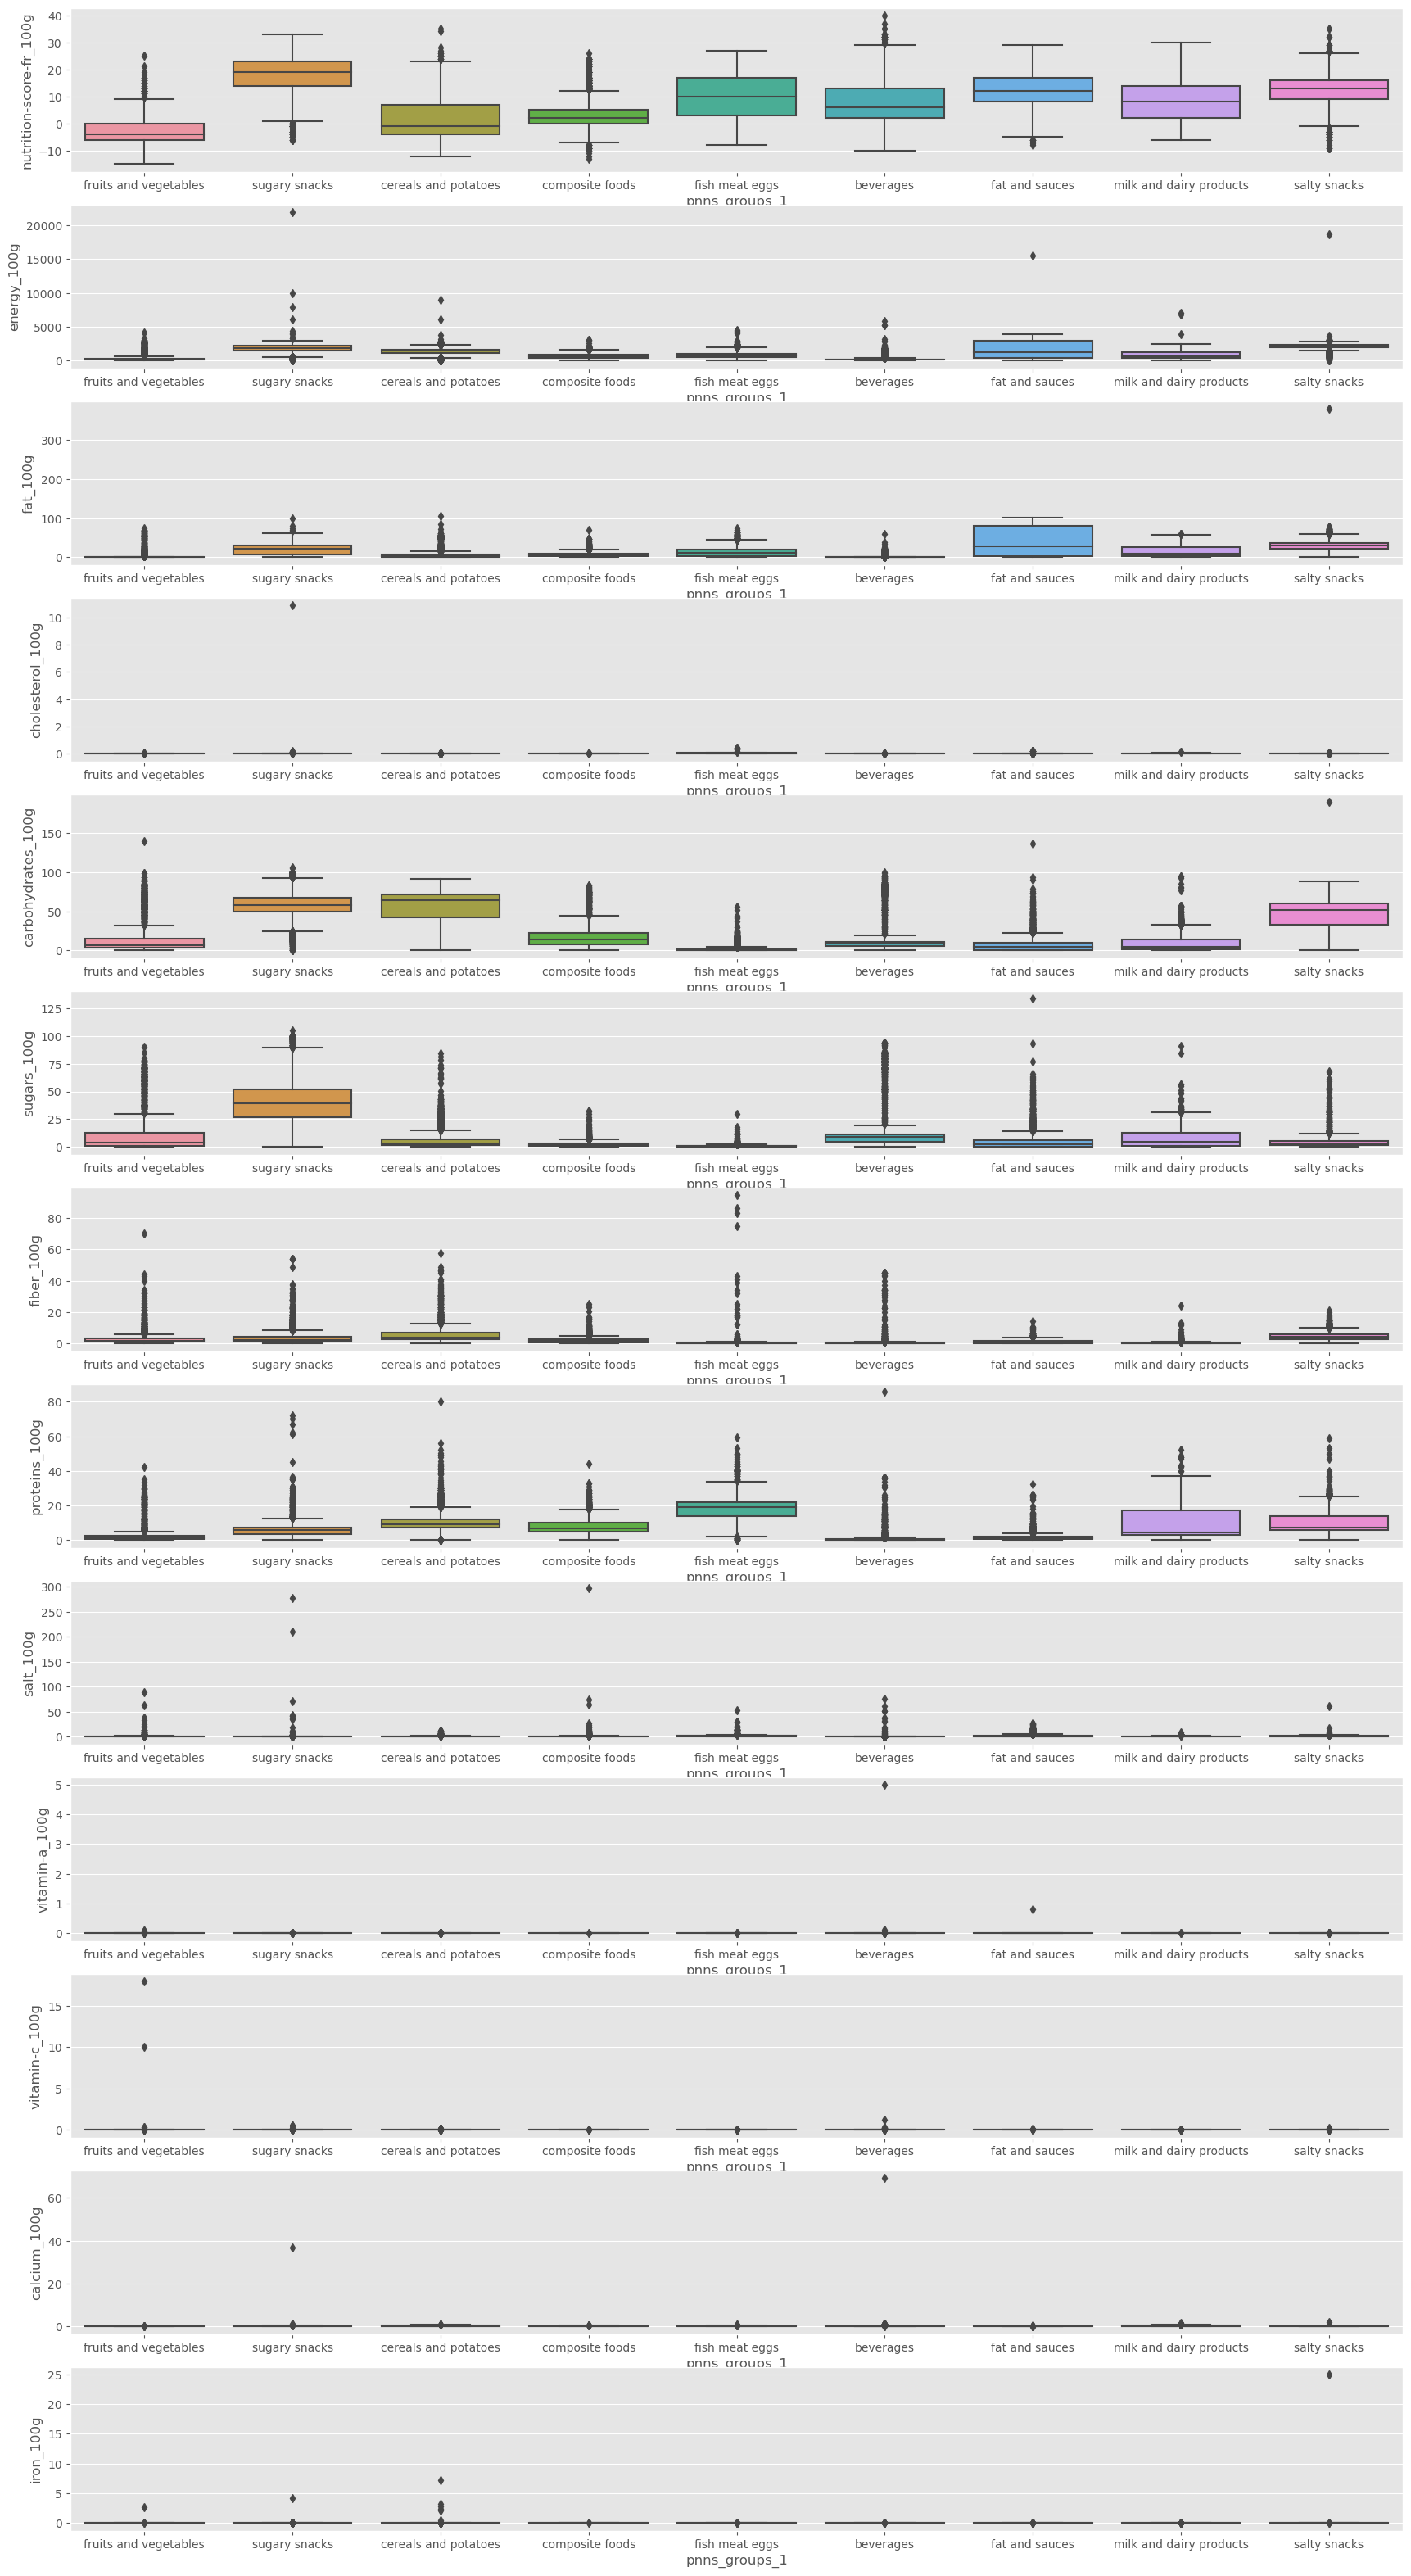

In [95]:
imp = 0
plt.style.use('ggplot')
fig,axes = plt.subplots(nrows = 13,ncols = 1,figsize=(21,40))
for i,col in enumerate( numCol ):
    if data_cleaned[col].dtypes in ['float64','int32']:
        sns.boxplot(x= 'pnns_groups_1',y= col,data = data_cleaned,ax=axes[i-imp])
        #axes.flatten()[i-imp].set_title(col)
        
    else:
        imp += 1
    

</br>

#### Etude de la distribution des variables numeriques

In [97]:
from scipy import stats

df_normalite = pd.DataFrame()
list_col = []
list_Shapiro = []
list_kstest = []

for i,col in enumerate([x for x in numCol if '_100g' in x]):
    list_col.append(col)
    list_Shapiro.append(stats.shapiro(data_cleaned[col].dropna())[1])
    list_kstest.append(stats.kstest(data_cleaned[col].dropna(), 'norm')[1])
    
df_normalite['Colonne'] = list_col
df_normalite['pvalue_Shapiro'] = list_Shapiro
df_normalite['pvalue_Kolmogorov-Smirnov'] = list_kstest

df_normalite

C:\Users\eleor\anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Colonne  pvalue_Shapiro  pvalue_Kolmogorov-Smirnov
0   nutrition-score-fr_100g             0.0                        0.0
1               energy_100g             0.0                        0.0
2                  fat_100g             0.0                        0.0
3          cholesterol_100g             0.0                        0.0
4        carbohydrates_100g             0.0                        0.0
5               sugars_100g             0.0                        0.0
6                fiber_100g             0.0                        0.0
7             proteins_100g             0.0                        0.0
8                 salt_100g             0.0                        0.0
9            vitamin-a_100g             0.0                        0.0
10           vitamin-c_100g             0.0                        0.0
11             calcium_100g             0.0                        0.0
12                iron_100g             0.0                        0.0

<div class="alert alert-block alert-warning">
Aucunes de ces colonnes ne suivent la distribution d'une loi normal.
</br>
Donc definir que les valeurs outliers sont les valeurs plus grandes que 3 n'est pas exacte.
(95% des valeurs d'une distribution normale se situe entre -1.96 et 1.96 et 99% des valeurs d'une distribution normale se situe entre -3 et 3)

</br></br>
Nous traiterons les outliers grace à l'écart intercartile
</div>

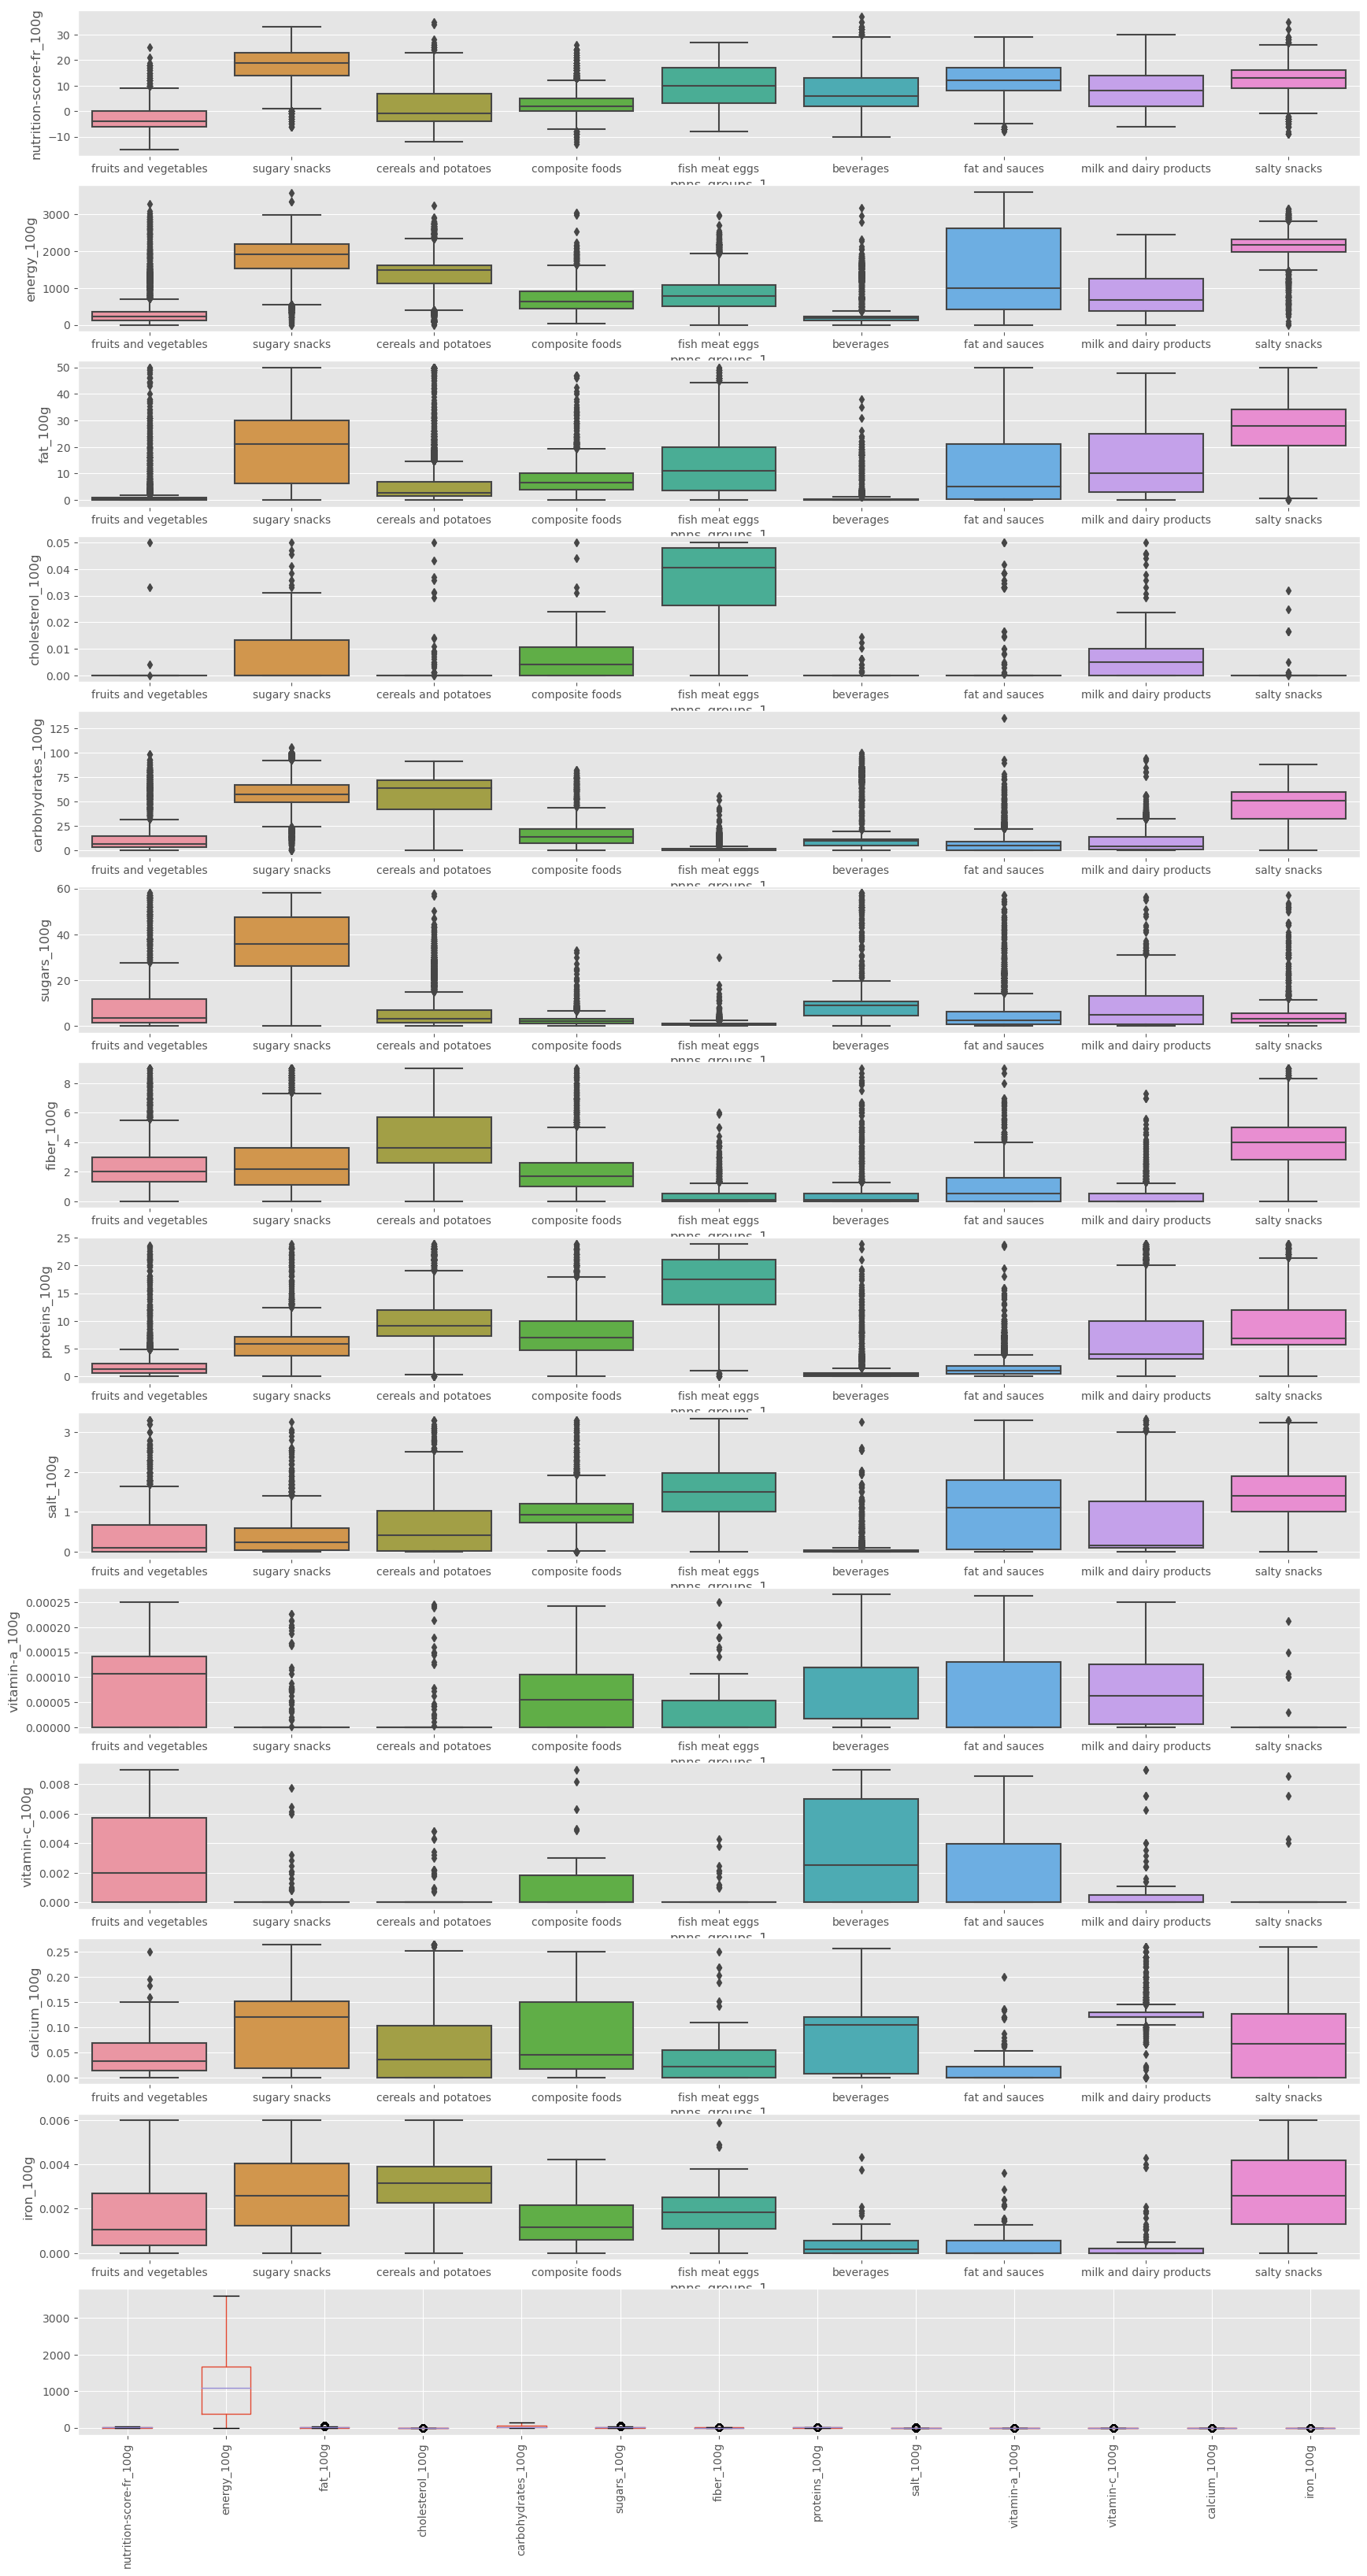

In [98]:
imp = 0
plt.style.use('ggplot')
fig,axes = plt.subplots(nrows = 14,ncols = 1,figsize=(21,40))
for i,col in enumerate( numCol ):
    if '_100g' in col:
        
        #On calcule Q1 et Q3
        q1,q3=data_cleaned[col].quantile(q=0.25),data_cleaned[col].quantile(q=0.75)

        #On calcule l'écart interquartile (IQR)
        IQR=q3-q1

        #On calcule la borne inférieure à l'aide du Q1 et de l'écart interquartile
        borne_inf = q1-1.5*IQR

        #On calcule la borne supérieure à l'aide du Q3 et de l'écart interquartile
        borne_sup = q3 +1.5*IQR

        #On garde les valeurs à l'intérieur de la borne inférieure et supérieure
        data_cleaned.loc[data_cleaned[col]>borne_sup,col] = np.nan
        data_cleaned.loc[data_cleaned[col]<borne_inf,col] = np.nan
        
        sns.boxplot(x= 'pnns_groups_1',y= col,data = data_cleaned,ax=axes[i-imp])
        #axes.flatten()[i-imp].set_title(col)
        
    else:
        imp += 1
        
colNumTested = [colk for i,colk in enumerate(numCol) if '_100g' in colk ]
data_cleaned[colNumTested].boxplot(rot=90,figsize = (10,6))
del colNumTested;

### Densité de distribution

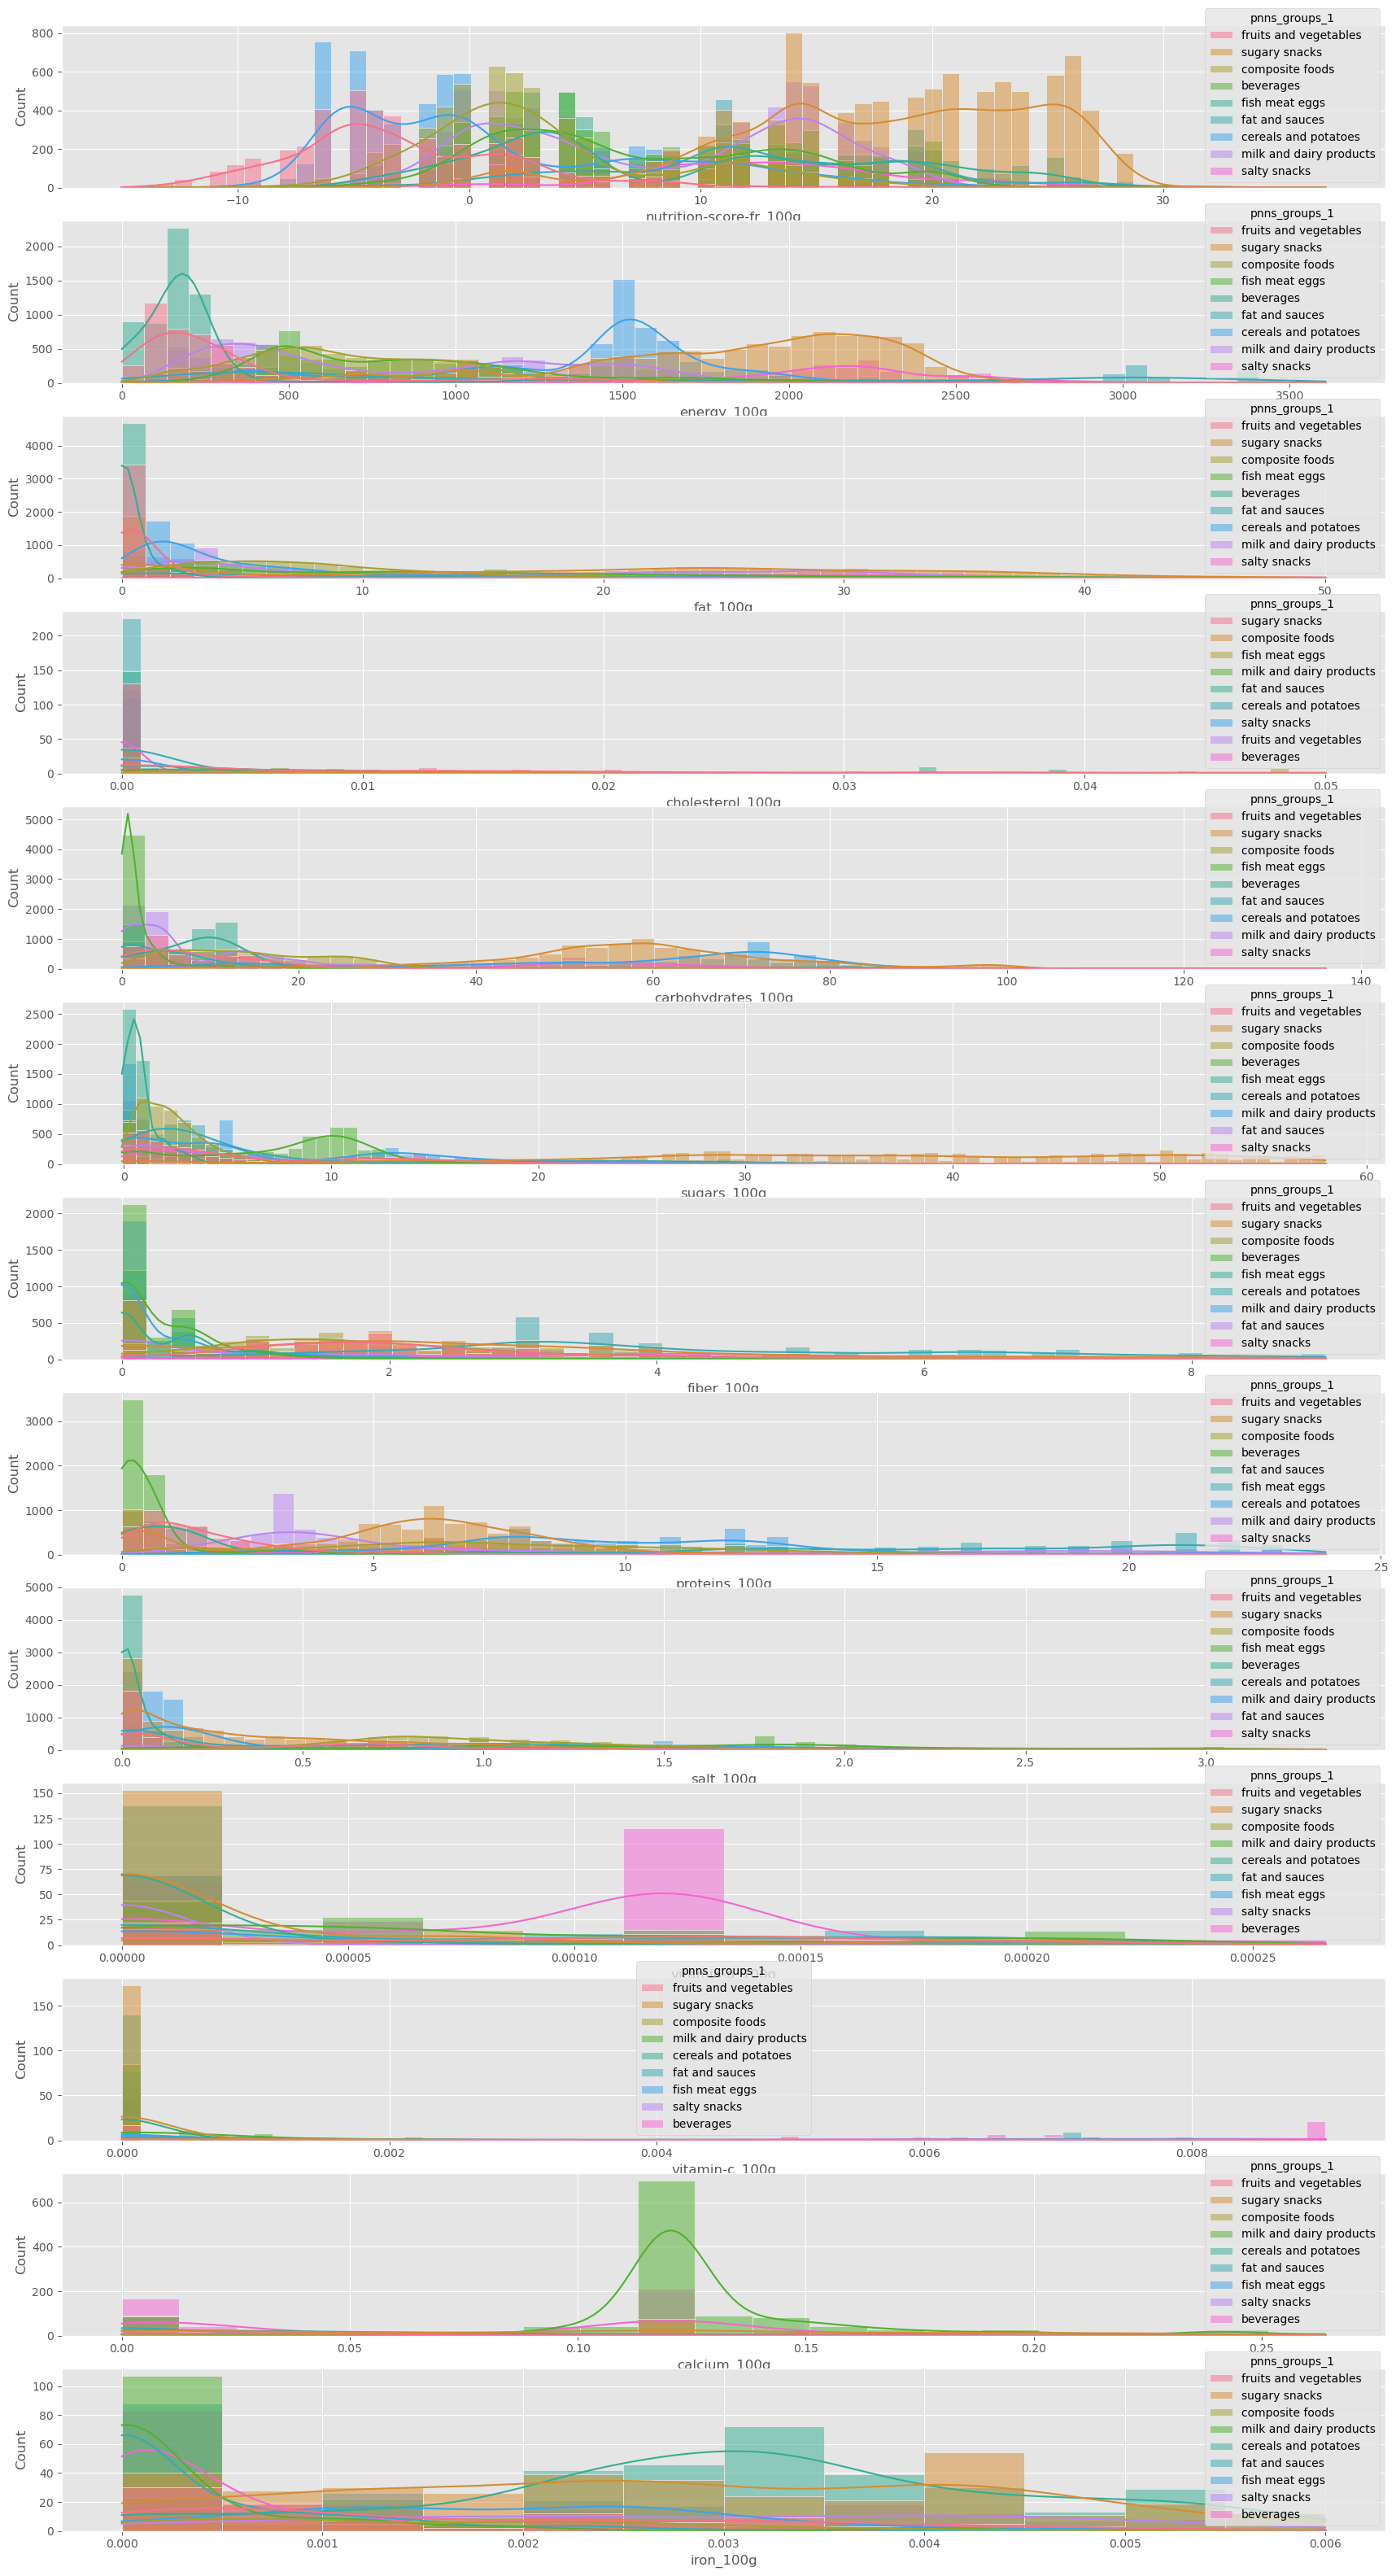

In [100]:
# Densité de distribution
from scipy import stats

#define figure
#fig = plt.figure(figsize=(40,60))
imp = 0
plt.style.use('ggplot')
fig,axes = plt.subplots(nrows = 13,ncols = 1,figsize=(21,40))
for i,col in enumerate([x for x in numCol if '_100g' in x]):
    #print(col,'  :  ',data_cleaned[[col,"pnns_groups_1"]].dropna().shape)
    if all(data_cleaned[[col,"pnns_groups_1"]].dropna()[col]==0):
        imp+=1
        continue
    sns.histplot(data = data_cleaned[[col,"pnns_groups_1"]].dropna(), 
                 x = col, 
                 kde = True, 
                 hue = "pnns_groups_1",
                 ax=axes[i-imp]
                )


</br>

</br>

## Imputation des valeurs manquantes

##### train test na data

In [133]:
na_df = data_cleaned[numCol].dropna().copy().values
idNan = np.arange(na_df.size)
idNan = np.random.choice(idNan, size=round((na_df.shape[0] * na_df.shape[1])*0.2), replace=False)

Xna = na_df.ravel()
Xna = np.array([ np.nan if i in idNan else x for i,x in enumerate(Xna) ]).reshape(na_df.shape)

In [124]:
na_df.ravel()

array(['0000001938067', 'Chaussons tressés aux pommes', '1.200 kg', ...,
       0, 1, 0], dtype=object)

<div class="alert alert-block alert-info">Score a battre</div>

In [330]:
print("L'érreur quadratique d'une imputation par la moyenne est de ", np.sum((np.mean(na_df.ravel()) - na_df.ravel())**2/len(na_df.ravel()) ) )
print("L'érreur median absolu d'une imputation par la moyenne est de ", np.sum(abs(na_df.ravel() - na_df.ravel())/len(na_df.ravel()) ) )

NameError: name 'na_df' is not defined

##### KNN Imputer

In [139]:
%%time
import numpy as np
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5, weights="distance")
XimputeKNN = imputer.fit_transform(Xna)

CPU times: total: 10min 2s
Wall time: 8min 3s


In [141]:
print("L'érreur quadratique moyenne est de ", np.sum((XimputeKNN.ravel() - na_df.ravel())**2/len(na_df.ravel()) ) )
print("L'érreur median Absolue est de ", np.sum(abs(XimputeKNN.ravel() - na_df.ravel())/len(na_df.ravel()) ) )

L'érreur quadratique moyenne est de  2584.6581171455514


##### expérimental Imputer

In [137]:
%%time
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(Xna)
IterativeImputer(random_state=0)
# the model learns that the second feature is double the first
XimputeExperi = np.round(imp.transform(Xna))

C:\Users\eleor\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


CPU times: total: 55.9 s
Wall time: 14.4 s


In [138]:
print("L'érreur quadratique moyenne est de ", np.sum((XimputeExperi.ravel() - na_df.ravel())**2/len(na_df.ravel()) ) )
print("L'érreur median Absolue est de ", np.sum(abs(XimputeExperi.ravel() - na_df.ravel())/len(na_df.ravel()) ) )

L'érreur quadratique moyenne est de  444.3601076199097


<div class="alert alert-block alert-info">
    L'imputer experimental est plus efficace avec des temps d'execution plus petit
</div>

In [200]:
imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(data_cleaned[numCol])
IterativeImputer(random_state=0,verbose=True)
# the model learns that the second feature is double the first
data_cleaned.loc[:,numCol] = np.round(imp.transform(data_cleaned[numCol]))

In [143]:
del na_df,idNan,Xna

In [161]:
compute_nb_mising_values(data_cleaned)

Taux de valeurs non nulles  \
code                                                         100.00   
cholesterol_100g                                             100.00   
carbohydrates_100g                                           100.00   
poids                                                        100.00   
fiber_100g                                                   100.00   
proteins_100g                                                100.00   
salt_100g                                                    100.00   
vitamin-a_100g                                               100.00   
fat_100g                                                     100.00   
vitamin-c_100g                                               100.00   
iron_100g                                                    100.00   
nutrition-score-fr_100g                                      100.00   
presenceDeLabels                                             100.00   
bocal/conserve                                               100.00   
creme/sauce                                                  100.00   
litre                                                        100.00   
petit pot/yaourt                                             100.00   
calcium_100g                                                 100.00   
energy_100g                                                  100.00   
sugars_100g                                                  100.00   
unité                                                        100.00   
url                                                          100.00   
last_modified_t                                              100.00   
created_t                                                    100.00   
creator                                                      100.00   
states_tags                                                   99.99   
countries_fr                                                  99.91   
product_name                                                  94.46   
brands_tags                                                   91.15   
unites_abb                                                    84.88   
unites                                                        84.88   
sodium_100g                                                   79.65   
additives_n                                                   77.61   
ingredients_from_palm_oil_n                                   77.61   
ingredients_that_may_be_from_palm_oil_n                       77.61   
ingredients_text                                              77.61   
saturated-fat_100g                                            71.57   
nutrition_grade_fr                                            68.97   
nutrition-score-uk_100g                                       68.97   
serving_size                                                  65.88   
additives_tags                                                48.22   
trans-fat_100g                                                44.68   
quantity                                                      32.67   
categories_tags                                               26.31   
main_category_fr                                              26.30   
packaging_tags                                                24.62   
image_small_url                                               23.64   
image_url                                                     23.64   
pnns_groups_2                                                 22.41   
pnns_groups_1                                                 21.48   
purchase_places                                               18.14   
generic_name                                                  16.45   
stores                                                        16.12   
labels_tags                                                   14.54   
manufacturing_places_tags                                     11.37   
emb_codes_tags                                                 9.

<div class="alert alert-block alert-info">
    Commen on le voit les colonnes numerique de notre dataset ne possède plus de données manquantes.
</div>

</br>

</br>

</br>

</br>

</br>

In [146]:
data_cleaned[colgarder].drop(columns=['code', 'product_name', 'quantity', 'serving_size', 'nutrition_grade_fr',
                                         'pnns_groups_1', 'main_category_fr','nutrition_grade_fr']).columns

Index(['pnns_groups_2', 'nutrition-score-fr_100g', 'energy_100g', 'fat_100g',
       'cholesterol_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g',
       'proteins_100g', 'salt_100g', 'vitamin-a_100g', 'vitamin-c_100g',
       'calcium_100g', 'iron_100g', 'bocal/conserve', 'creme/sauce', 'litre',
       'petit pot/yaourt', 'poids', 'unité'],
      dtype='object')

#### Reduction de dimension 

In [211]:
import functions_display_PCA

In [327]:
from sklearn.decomposition import PCA, KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn import preprocessing as prep

X = data_cleaned[colgarder].drop(columns=['code', 'product_name', 'quantity', 'serving_size', 'nutrition_grade_fr',
                                         'pnns_groups_1', 'main_category_fr','nutrition_grade_fr']).dropna().drop(columns='pnns_groups_2')

y = data_cleaned[colgarder].drop(columns=['code', 'product_name', 'quantity', 'serving_size', 'nutrition_grade_fr',
                                         'pnns_groups_1', 'main_category_fr','nutrition_grade_fr']).dropna().pnns_groups_2


# Centrage reduction - scaling step
std_scale = prep.StandardScaler()
X_scaled = std_scale.fit_transform(X)

# Principal Component Analysis
pca = PCA()
X_r = pca.fit(X_scaled).transform(X_scaled)

# LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
X_r2 = lda.fit(X_scaled, y).transform(X_scaled)

# QuadraticDiscriminantAnalysis
Qda = QuadraticDiscriminantAnalysis()
Qda.fit(X_scaled, y)

# KernelPCA
#kpca = KernelPCA(n_components=7, kernel='linear')
#X_kpca = kpca.fit_transform(X_scaled)

# Percentage of variance explained for each components
print(
    "explained variance ratio (all components): %s"
    % str(pca.explained_variance_ratio_)
)
#pd.DataFrame({'Variance expliqué':pca.explained_variance_ratio_*100}).plot(kind='bar');

explained variance ratio (all components): [2.51328020e-01 1.55341291e-01 1.18985378e-01 7.34931887e-02
 7.20546813e-02 7.15206068e-02 7.14164978e-02 6.55290019e-02
 4.28609396e-02 3.39481035e-02 2.22328230e-02 1.50478014e-02
 5.38331015e-03 8.58357393e-04 5.84777294e-34 9.08277415e-35
 4.05378616e-35 9.69123353e-36 6.40154949e-38]


#### Selection du nombre d'axe à conserver

- Regle de Kaiser en ACP normé: Conserver axes ssi λ > 1

In [278]:
print("Nombre d'axes conservés avec cette méthode: ",np.sum(pca.explained_variance_ratio_>1) )

Nombre d'axes conservés avec cette méthode:  0


- ébouli des valeurs propes

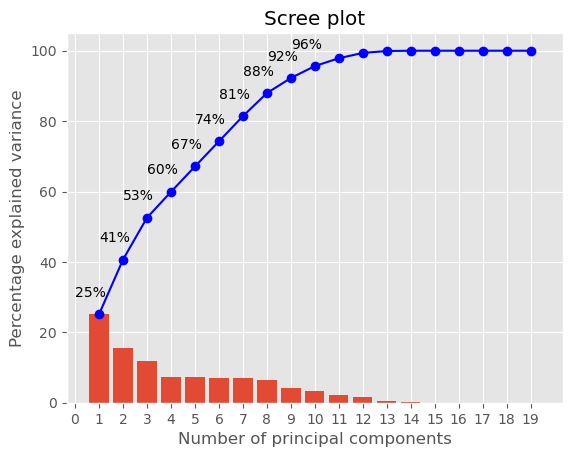

In [290]:
scree = pca.explained_variance_ratio_*100
plt.bar(np.arange(len(scree))+1, scree)
plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="blue",marker='o')

for i in np.arange(len(scree)-9):
    plt.text(i, scree.cumsum()[i]+5,s =str(round(scree.cumsum()[i]))+'%')   
plt.xlabel("Number of principal components")
plt.ylabel("Percentage explained variance")
plt.title("Scree plot")
plt.xticks(np.arange(len(scree)+1))
plt.show(block=False)

- Règle conserver axes ssi:
 $λ< (100/p)$ </br>
 Cette valeur représente la variabilité d'une variable brute apres centrage reduction.

In [289]:
print("Nombre d'axes conservés avec cette méthode: {}.\nCe qui représente {:.2%} des colonnes du début".format(np.sum(pca.explained_variance_ratio_*100<(100/X_scaled.shape[1])),
                                                                                                               np.sum(pca.explained_variance_ratio_*100<(100/X_scaled.shape[1]))/X_scaled.shape[1]) 
     )

Nombre d'axes conservés avec cette méthode: 11.
Ce qui représente 57.89% des colonnes du début


''

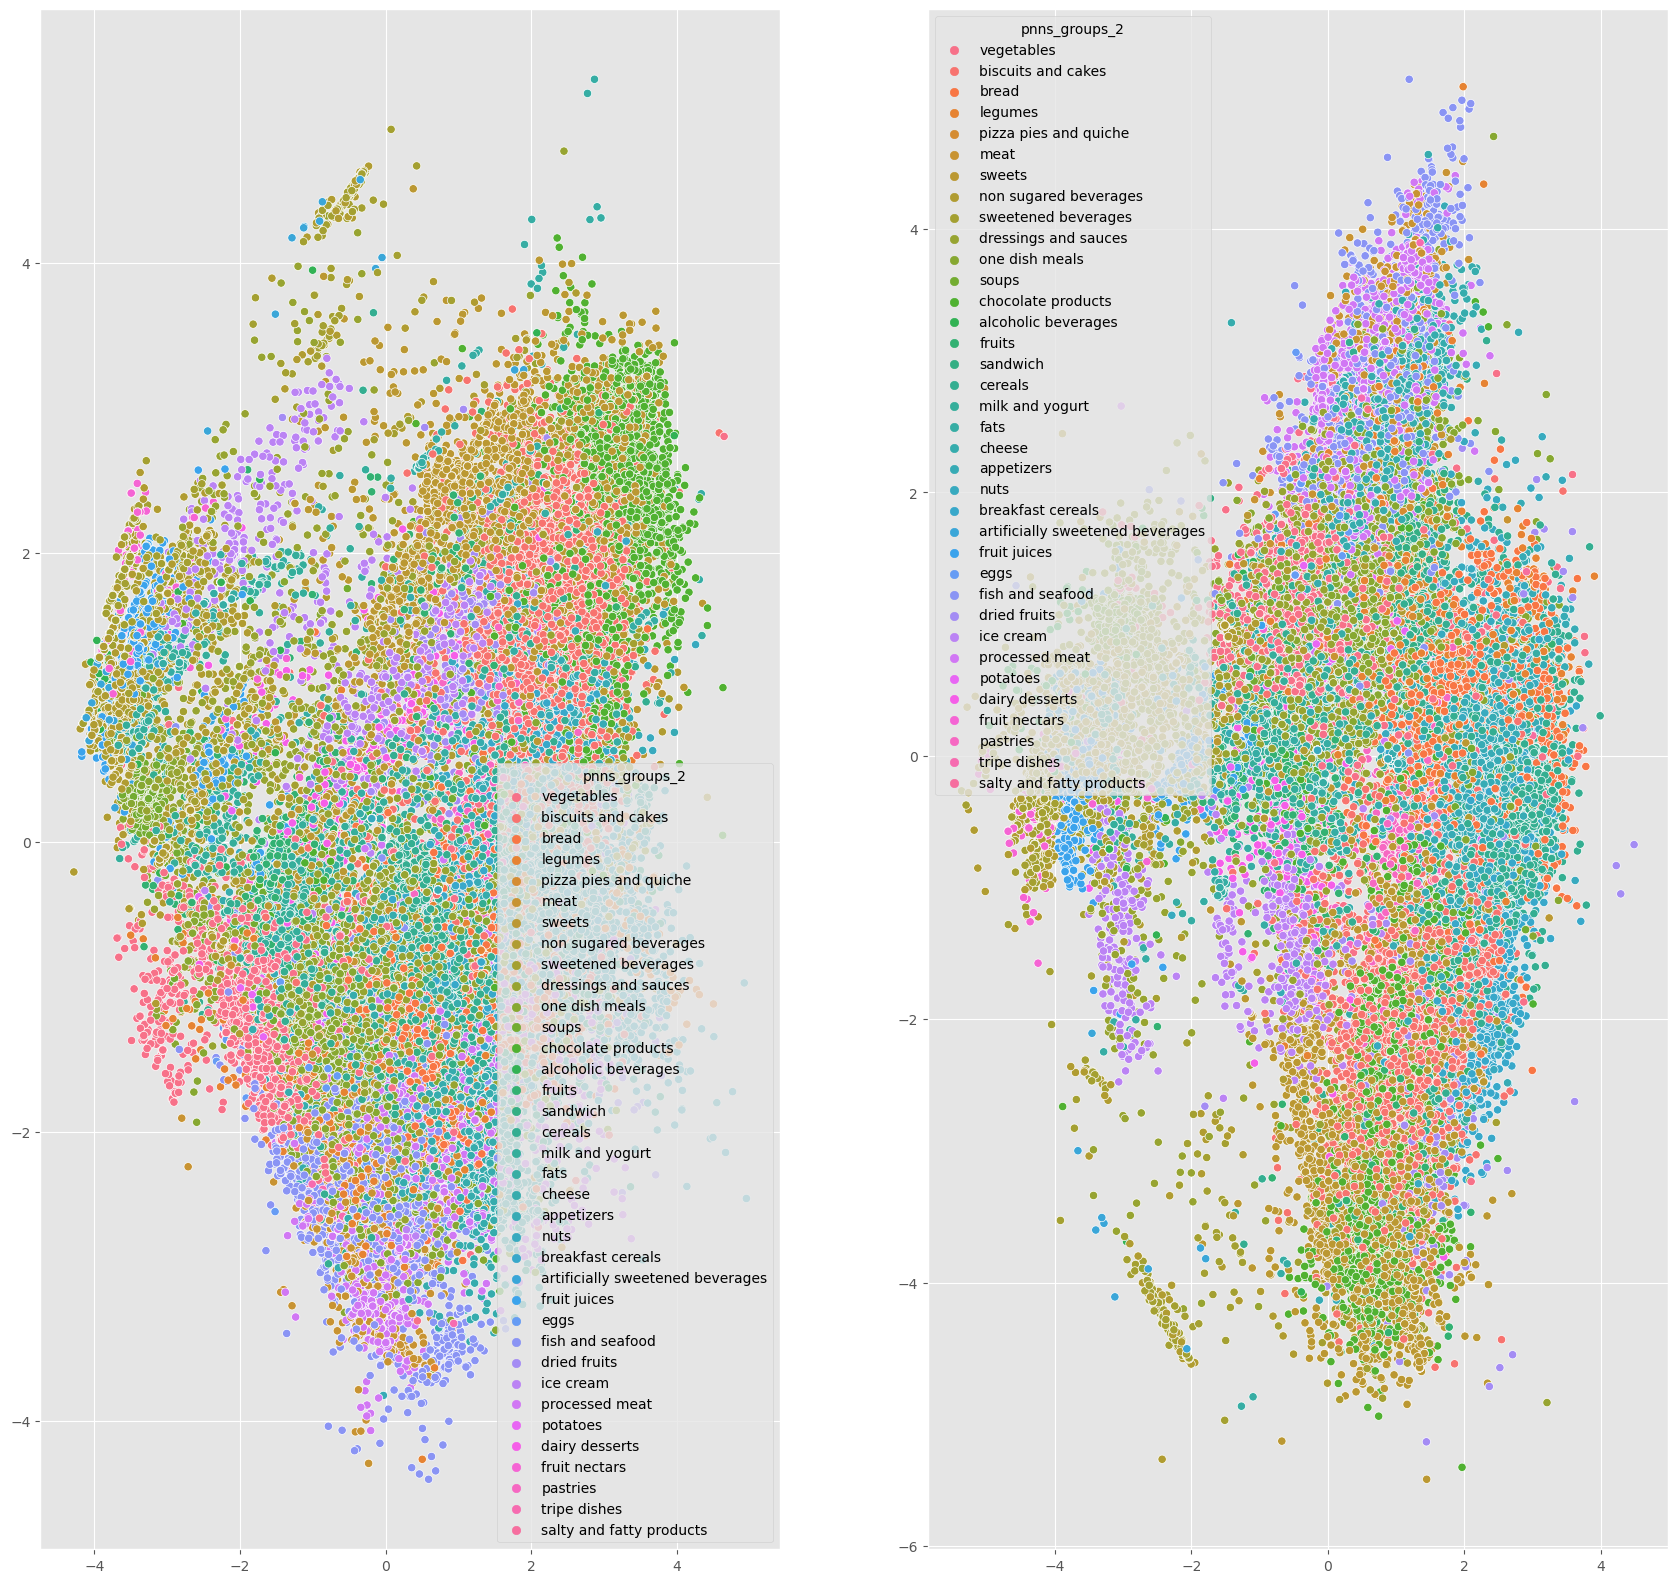

In [269]:
import warnings
warnings.filterwarnings("ignore")
fig,axes = plt.subplots(nrows = 1,ncols = 2,figsize=(21,20))
sns.scatterplot(X_r[:,0],X_r[:,1],hue=y,ax = axes[0])
sns.scatterplot(X_r2[:,0],X_r2[:,1],hue=y,ax = axes[1])
;

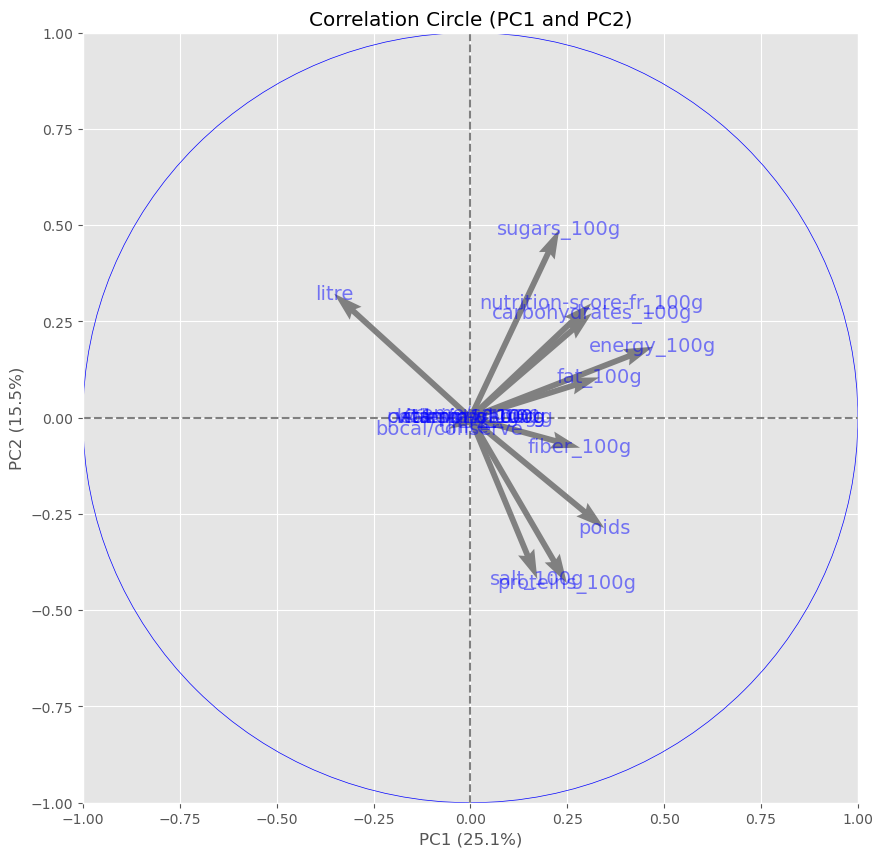

In [270]:
# Generate a correlation circle
pcs = pca.components_ 
display_circles(pcs, 19, pca=pca, axis_ranks=[(0,1)], labels = np.array(X.columns),) 

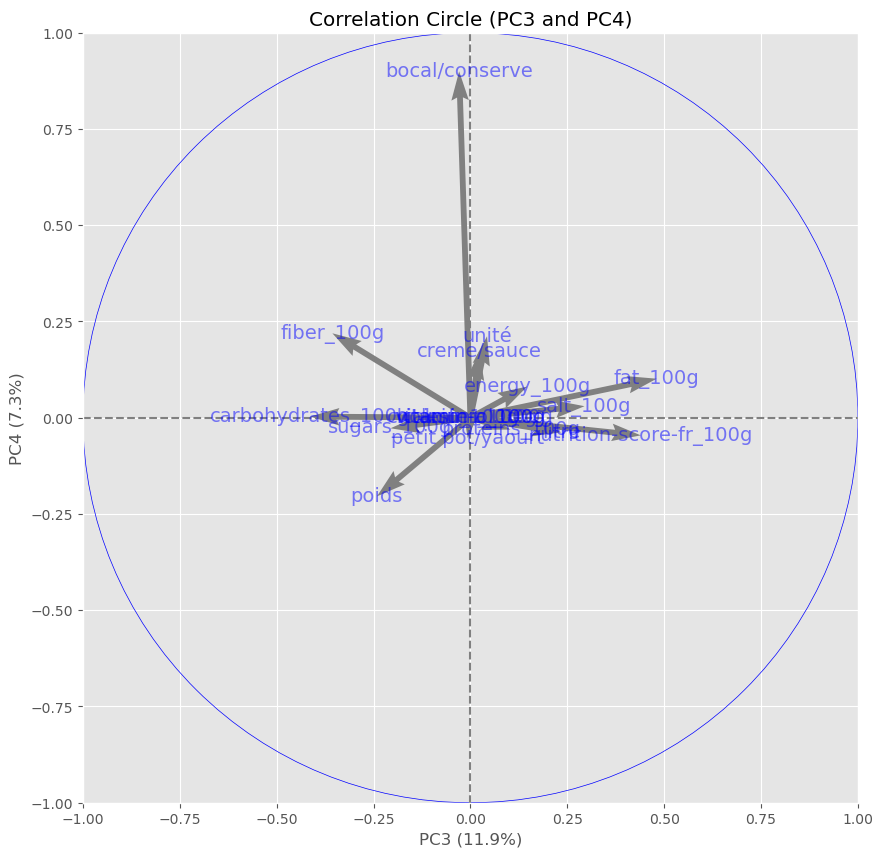

In [271]:
# Generate a correlation circle
pcs = pca.components_ 
display_circles(pcs, 19, pca=pca, axis_ranks=[(2,3)], labels = np.array(X.columns),) 

## Imputation de la variable cible pnns_groups_2

In [297]:
### LDA
from sklearn.model_selection import cross_val_score
resultLDA = cross_val_score(lda, X_r2[:,:11], y,  scoring='accuracy')
# report the mean performance
print('Accuracy: %.3f' % resultLDA.mean())

Accuracy: 0.454


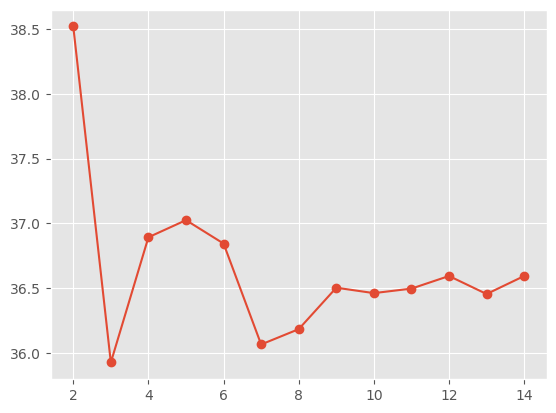

In [303]:
### KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_r[:,:11],  y, 
                                                    test_size = 0.2, # 20% du jeux de données réservé pour test la qualité du model
                                                    random_state = 0)
kmintest = 2
kmaxtotest = 15
errors = []
for k in range(kmintest,kmaxtotest):
    knn = KNeighborsClassifier(n_neighbors=k)
    
    # cross validation
    errors.append(100 * (1-knn.fit(X_train,y_train).score(X_test,y_test)) )
                         
plt.plot(range(kmintest,kmaxtotest),errors, 'o-')
plt.show()

In [324]:
%%time
resultKNN_mean = []
for k in [3,5,7]:
    for ncol in [3,8,11]:
        knn3 = KNeighborsClassifier(n_neighbors = k)
        resultKNN = cross_val_score(knn3, X_r2[:,:ncol], y,  scoring='accuracy').mean()
        # report the mean performance
        resultKNN_mean.append(resultKNN)

print(resultKNN_mean)

[0.47504363920140713, 0.6007059775582378, 0.5925939975789253, 0.5012028141560009, 0.6066895949206588, 0.6002608047022756, 0.5049736390326733, 0.6062859491882917, 0.5970047033772945]
CPU times: total: 58.3 s
Wall time: 58.4 s


In [312]:
%%time
resultKNN_mean = []
knnb = KNeighborsClassifier(n_neighbors = 5)
resultKNN = cross_val_score(knnb, X_r2[:,:8], y,  scoring='accuracy')
# report the mean performance
print('Accuracy: %.3f' % resultKNN.mean())

Accuracy: 0.607
CPU times: total: 9.23 s
Wall time: 9.26 s


In [329]:
X_scaled.shape

(71867, 19)

In [328]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
clf = Pipeline([
("kpca", KernelPCA(n_components=2)),
("log_reg", LogisticRegression())
])
param_grid = [{
    "kpca__gamma": np.linspace(0.03, 0.05, 10),
    "kpca__kernel": ["rbf", "sigmoid"]
}]
grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X_scaled, y)

ValueError: 
All the 60 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\eleor\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\eleor\anaconda3\lib\site-packages\sklearn\pipeline.py", line 378, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\eleor\anaconda3\lib\site-packages\sklearn\pipeline.py", line 336, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\eleor\anaconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\eleor\anaconda3\lib\site-packages\sklearn\pipeline.py", line 870, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "C:\Users\eleor\anaconda3\lib\site-packages\sklearn\decomposition\_kernel_pca.py", line 456, in fit_transform
    self.fit(X, **params)
  File "C:\Users\eleor\anaconda3\lib\site-packages\sklearn\decomposition\_kernel_pca.py", line 423, in fit
    K = self._get_kernel(X)
  File "C:\Users\eleor\anaconda3\lib\site-packages\sklearn\decomposition\_kernel_pca.py", line 303, in _get_kernel
    return pairwise_kernels(
  File "C:\Users\eleor\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py", line 2153, in pairwise_kernels
    return _parallel_pairwise(X, Y, func, n_jobs, **kwds)
  File "C:\Users\eleor\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py", line 1530, in _parallel_pairwise
    return func(X, Y, **kwds)
  File "C:\Users\eleor\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py", line 1273, in rbf_kernel
    K = euclidean_distances(X, Y, squared=True)
  File "C:\Users\eleor\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py", line 330, in euclidean_distances
    return _euclidean_distances(X, Y, X_norm_squared, Y_norm_squared, squared)
  File "C:\Users\eleor\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py", line 371, in _euclidean_distances
    distances = -2 * safe_sparse_dot(X, Y.T, dense_output=True)
  File "C:\Users\eleor\anaconda3\lib\site-packages\sklearn\utils\extmath.py", line 152, in safe_sparse_dot
    ret = a @ b
MemoryError: Unable to allocate 17.1 GiB for an array with shape (47911, 47911) and data type float64

--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\eleor\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\eleor\anaconda3\lib\site-packages\sklearn\pipeline.py", line 378, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\eleor\anaconda3\lib\site-packages\sklearn\pipeline.py", line 336, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\eleor\anaconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\eleor\anaconda3\lib\site-packages\sklearn\pipeline.py", line 870, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "C:\Users\eleor\anaconda3\lib\site-packages\sklearn\decomposition\_kernel_pca.py", line 456, in fit_transform
    self.fit(X, **params)
  File "C:\Users\eleor\anaconda3\lib\site-packages\sklearn\decomposition\_kernel_pca.py", line 423, in fit
    K = self._get_kernel(X)
  File "C:\Users\eleor\anaconda3\lib\site-packages\sklearn\decomposition\_kernel_pca.py", line 303, in _get_kernel
    return pairwise_kernels(
  File "C:\Users\eleor\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py", line 2153, in pairwise_kernels
    return _parallel_pairwise(X, Y, func, n_jobs, **kwds)
  File "C:\Users\eleor\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py", line 1530, in _parallel_pairwise
    return func(X, Y, **kwds)
  File "C:\Users\eleor\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py", line 1273, in rbf_kernel
    K = euclidean_distances(X, Y, squared=True)
  File "C:\Users\eleor\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py", line 330, in euclidean_distances
    return _euclidean_distances(X, Y, X_norm_squared, Y_norm_squared, squared)
  File "C:\Users\eleor\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py", line 371, in _euclidean_distances
    distances = -2 * safe_sparse_dot(X, Y.T, dense_output=True)
  File "C:\Users\eleor\anaconda3\lib\site-packages\sklearn\utils\extmath.py", line 152, in safe_sparse_dot
    ret = a @ b
MemoryError: Unable to allocate 17.1 GiB for an array with shape (47912, 47912) and data type float64

--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\eleor\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\eleor\anaconda3\lib\site-packages\sklearn\pipeline.py", line 378, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\eleor\anaconda3\lib\site-packages\sklearn\pipeline.py", line 336, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\eleor\anaconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\eleor\anaconda3\lib\site-packages\sklearn\pipeline.py", line 870, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "C:\Users\eleor\anaconda3\lib\site-packages\sklearn\decomposition\_kernel_pca.py", line 456, in fit_transform
    self.fit(X, **params)
  File "C:\Users\eleor\anaconda3\lib\site-packages\sklearn\decomposition\_kernel_pca.py", line 423, in fit
    K = self._get_kernel(X)
  File "C:\Users\eleor\anaconda3\lib\site-packages\sklearn\decomposition\_kernel_pca.py", line 303, in _get_kernel
    return pairwise_kernels(
  File "C:\Users\eleor\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py", line 2153, in pairwise_kernels
    return _parallel_pairwise(X, Y, func, n_jobs, **kwds)
  File "C:\Users\eleor\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py", line 1530, in _parallel_pairwise
    return func(X, Y, **kwds)
  File "C:\Users\eleor\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py", line 1238, in sigmoid_kernel
    K = safe_sparse_dot(X, Y.T, dense_output=True)
  File "C:\Users\eleor\anaconda3\lib\site-packages\sklearn\utils\extmath.py", line 152, in safe_sparse_dot
    ret = a @ b
MemoryError: Unable to allocate 17.1 GiB for an array with shape (47911, 47911) and data type float64

--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\eleor\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\eleor\anaconda3\lib\site-packages\sklearn\pipeline.py", line 378, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\eleor\anaconda3\lib\site-packages\sklearn\pipeline.py", line 336, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\eleor\anaconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\eleor\anaconda3\lib\site-packages\sklearn\pipeline.py", line 870, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "C:\Users\eleor\anaconda3\lib\site-packages\sklearn\decomposition\_kernel_pca.py", line 456, in fit_transform
    self.fit(X, **params)
  File "C:\Users\eleor\anaconda3\lib\site-packages\sklearn\decomposition\_kernel_pca.py", line 423, in fit
    K = self._get_kernel(X)
  File "C:\Users\eleor\anaconda3\lib\site-packages\sklearn\decomposition\_kernel_pca.py", line 303, in _get_kernel
    return pairwise_kernels(
  File "C:\Users\eleor\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py", line 2153, in pairwise_kernels
    return _parallel_pairwise(X, Y, func, n_jobs, **kwds)
  File "C:\Users\eleor\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py", line 1530, in _parallel_pairwise
    return func(X, Y, **kwds)
  File "C:\Users\eleor\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py", line 1238, in sigmoid_kernel
    K = safe_sparse_dot(X, Y.T, dense_output=True)
  File "C:\Users\eleor\anaconda3\lib\site-packages\sklearn\utils\extmath.py", line 152, in safe_sparse_dot
    ret = a @ b
MemoryError: Unable to allocate 17.1 GiB for an array with shape (47912, 47912) and data type float64


</br>

</br>

</br>

</br>

</br>

</br>

</br>

</br>

</br>

</br>

</br>

</br>

</br>

</br>

</br>

</br>

</br>

</br>

</br>

</br>

</br>

In [ ]:
ttt = [colgarder[i] for i,colk in enumerate(colgarder)  if (colk not in  ['nutrition-score-fr_100g','energy_100g','nutrition_grade_fr']) & (colk in nutrition_facts)]


for col in ttt:
    print(col)
    openfoodfacts.loc[openfoodfacts[col]>100,col] = np.nan
del ttt

In [ ]:
#On peut voir que la repartitions des données va de 0g à 120g pour une portion de tranche de 100g

In [ ]:
nutrition_facts

## Gestions des valeurs manquantes

In [ ]:
pd.set_option('max_colwidth',-1)

In [ ]:
#fillna

# nutrition_facts
openfoodfacts[nutrition_facts] = openfoodfacts[nutrition_facts].fillna(0,inplace=False)

In [ ]:

for i in nutrition_facts[:10]:
    openfoodfacts[[i]+['nutrition_grade_fr']].boxplot(by='nutrition_grade_fr', 
                                                                       column=i, 
                                                                       grid=False)

In [ ]:
#Ci dessous la liste des colonnes que l'on garde

In [ ]:
pd.options.display.max_rows=80
pd.DataFrame(openfoodfacts[openfoodfacts.columns[~openfoodfacts.columns.isin(nomColonnes.Colonnes[nomColonnes.type_de_colonne=='nutrition_facts'])]].notna().sum()/nbLigne)\
.style.background_gradient(cmap='Blues').format("{:.2%}")

## Creation dataframe etude

In [ ]:
df_openfoodfacts = openfoodfacts[colgarder]

if not os.path.exists('df_openfoodfacts.csv'):
    df_openfoodfacts.to_csv('df_openfoodfacts.csv',sep='\t',encoding='utf-8',index=False)

In [ ]:
#elargir la taille de la cellule
pd.set_option('max_colwidth', -1)

In [ ]:
openfoodfacts.loc[openfoodfacts.quantity.isna() & openfoodfacts.serving_size.notna()][['product_name','url','quantity','categories_fr','serving_size','additives_n','main_category_fr']]\
.sample(5)

In [ ]:
pd.DataFrame({'quantservcomp':[quant if not quant is np.nan else serv for quant,serv in zip(openfoodfacts.quantity,openfoodfacts.serving_size) ]}).isna().sum()/nbLigne

In [ ]:
openfoodfacts.ingredients_text.sample(5).str.split(',', expand=True)

In [ ]:
openfoodfacts[["main_category_fr",'categories_fr']].describe()

In [ ]:
#supprimer element entre parenthèse
(?<!m)

In [ ]:
openfoodfacts.ingredients_text[297693]

In [ ]:
openfoodfacts.ingredients_text.str.lower().replace('\\(   .+   (  ?<!\\(  )  \\)','',regex=True)[297693]

In [ ]:
openfoodfacts.ingredients_text.str\
.lower().str\
.replace('\\([^(]+\\)','',regex=True).str\
.split(',', expand=True).iloc[:,0].str\
.replace('organic','').str\
.replace('^ ','').describe()


In [ ]:
pd.options.display.max_rows=60

In [ ]:
openfoodfacts.columns[~openfoodfacts.columns.isin(nutrition_facts)].to_list()

In [ ]:
msno.matrix(df_openfoodfacts[df_openfoodfacts.columns[~df_openfoodfacts.columns.isin(nutrition_facts)].to_list()])

In [ ]:
msno.heatmap(df_openfoodfacts[['quantity','serving_size']])

</br>

</br>

</br>

### Supprimer les colonnes qui possèdent beaucoups de valeurs non nulles

In [ ]:
# Le % de valeurs manquantes et les colonnes à conserver
nomColonnes["%Na"] = nomColonnes['Nombre de valeurs manquantes']/nbLigne
nomColonnes["NoNa"] = (nbLigne - nomColonnes['Nombre de valeurs manquantes'])
nomColonnes["colASupp"] = nomColonnes.Colonnes.isin(col_to_drop)

In [ ]:
nomColonnes.colASupp[nomColonnes['Nombre de valeurs manquantes'] > (nbLigne * 0.95)] = True

In [ ]:
for x in nomColonnes.Colonnes[(nomColonnes.type_de_colonne=='nutrition_facts') & (nomColonnes.colASupp == True)]:
    nutrition_facts.remove(x)

In [ ]:
for nut in nutrition_facts:
    if nut in nomColonnes.Colonnes[(nomColonnes.type_de_colonne=='nutrition_facts') & (nomColonnes.colASupp == False)]:
        colgarder += [nut]

In [ ]:
nomColonnes[nomColonnes.colASupp==False].groupby(['type_de_colonne'])['%Na'].describe().T

In [ ]:
fig,axes = plt.subplots(nrows = 7,ncols = 1,figsize=(20,40))
for i,typcol in enumerate( nomColonnes.type_de_colonne.unique() ):
    sns.barplot(data = nomColonnes[nomColonnes.type_de_colonne==typcol], x = 'Colonnes' , y = '%Na',ax=axes[i])
    axes[i].title.set_text(typcol)
    axes[i]
    if len(nomColonnes.Colonnes[nomColonnes.type_de_colonne==typcol])>10:
        axes[i].tick_params(axis='x', rotation=60, labelsize=7)


In [ ]:
fig,axes = plt.subplots(nrows = 7,ncols = 1,figsize=(20,40))
for i,typcol in enumerate( nomColonnes.type_de_colonne.unique() ):
    sns.barplot(data = nomColonnes[nomColonnes.type_de_colonne==typcol], x = 'Colonnes' , y = '%Na',ax=axes[i])
    axes[i].title.set_text(typcol)
    axes[i]
    if len(nomColonnes.Colonnes[nomColonnes.type_de_colonne==typcol])>10:
        axes[i].tick_params(axis='x', rotation=60, labelsize=7)


In [ ]:
plt.figure(figsize=(12,4))
sns.barplot(x=pd.cut(x=nomColonnes['%Na'], bins=20).value_counts().index ,y = pd.cut(x=nomColonnes['%Na'], bins=20).value_counts())
plt.title('Répartition du nombre de valeurs manquantes')
plt.xticks(rotation = 90);

In [ ]:
[
 nomColonnes.colASupp[:50].sum(),
 nomColonnes.colASupp[50:100].sum(),
 nomColonnes.colASupp[100:130].sum(),
 nomColonnes.colASupp[130:162].sum()
]#32 24 5

In [ ]:
general_information + ingredients + misc_data + score_foot_print + tags + labels + nutrition_facts

In [ ]:
openfoodfacts[['ingredients_text']].iloc[198025].str.replace('\(.*\)','',regex=True)

In [ ]:
"eerr"

In [72]:
[x for x in openfoodfacts.columns if '_100g' in x]

['energy_100g',
 'energy-from-fat_100g',
 'fat_100g',
 'saturated-fat_100g',
 'butyric-acid_100g',
 'caproic-acid_100g',
 'caprylic-acid_100g',
 'capric-acid_100g',
 'lauric-acid_100g',
 'myristic-acid_100g',
 'palmitic-acid_100g',
 'stearic-acid_100g',
 'arachidic-acid_100g',
 'behenic-acid_100g',
 'lignoceric-acid_100g',
 'cerotic-acid_100g',
 'montanic-acid_100g',
 'melissic-acid_100g',
 'monounsaturated-fat_100g',
 'polyunsaturated-fat_100g',
 'omega-3-fat_100g',
 'alpha-linolenic-acid_100g',
 'eicosapentaenoic-acid_100g',
 'docosahexaenoic-acid_100g',
 'omega-6-fat_100g',
 'linoleic-acid_100g',
 'arachidonic-acid_100g',
 'gamma-linolenic-acid_100g',
 'dihomo-gamma-linolenic-acid_100g',
 'omega-9-fat_100g',
 'oleic-acid_100g',
 'elaidic-acid_100g',
 'gondoic-acid_100g',
 'mead-acid_100g',
 'erucic-acid_100g',
 'nervonic-acid_100g',
 'trans-fat_100g',
 'cholesterol_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'sucrose_100g',
 'glucose_100g',
 'fructose_100g',
 'lactose_100g',
 'ma

In [80]:
mat_corr = openfoodfacts.loc[:,[x for x in openfoodfacts.columns if '_100g' in x]].corr()

In [84]:
mat_corr_melt = pd.melt(mat_corr.reset_index(), id_vars=['index'], value_vars= [x for x in openfoodfacts.columns if '_100g' in x] )
mat_corr_melt = mat_corr_melt[mat_corr_melt.index != mat_corr_melt.value]

In [43]:
len(c2)

0

In [92]:
openfoodfacts[['capric-acid_100g','serum-proteins_100g']].dropna(how='any')['capric-acid_100g']

Series([], Name: capric-acid_100g, dtype: float64)

In [91]:
st.pearsonr(openfoodfacts[['capric-acid_100g','serum-proteins_100g']].dropna(how='any')['capric-acid_100g'],
            openfoodfacts[['capric-acid_100g','serum-proteins_100g']].dropna(how='any')['serum-proteins_100g'])

ValueError: x and y must have length at least 2.

In [47]:
c1.shape > (2,)

False

In [53]:
import scipy

dfcorr = pd.DataFrame()
feat1s = []
feat2s = []
corrs = []
p_values = []
nrows = []

testCol = [x for x in openfoodfacts.columns if '_100g' in x]

for feat1 in openfoodfacts[testCol]:
    for feat2 in openfoodfacts[testCol]:
        if feat1 != feat2:
            feat1s.append(feat1)
            feat2s.append(feat2)
            c1 = openfoodfacts[[feat1,feat2]].dropna(how='any',axis=0)[feat1]
            c2 = openfoodfacts[[feat1,feat2]].dropna(how='any',axis=0)[feat2]
            
            nrowss = openfoodfacts[[feat1,feat2]].dropna(how='any',axis=0).shape[0]
            
            corr, p_value = scipy.stats.spearmanr(c1, c2)
            corrs.append(corr)
            p_values.append(p_value)
            nrows.append(nrowss)

dfcorr['Feature_1'] = feat1s
dfcorr['Feature_2'] = feat2s
dfcorr['Correlation'] = corrs
dfcorr['p_value'] = p_values
dfcorr['nrows'] = nrows

rescorr = dfcorr.loc[dfcorr['Correlation'].notna() & dfcorr['p_value'].notna(),:]
rescorr = rescorr[rescorr['p_value']<0.05]
rescorr


pd.options.display.max_rows = 200
rescorrelation = rescorr[(rescorr.nrows>100) & (abs(rescorr.Correlation)>0.8) ]\
.groupby('Feature_1').apply(lambda x: x.sort_values(['Correlation'], ascending=False).head(3))\
.rename(columns={'Feature_1':'feature_1','Feature_2':'feature_2'},)\
.sort_values(['Feature_1','Correlation'], ascending=[True,False] )


rescorrelation['f1'] = [x if x<y else y for x,y in zip(rescorrelation.feature_1,rescorrelation.feature_2)]
rescorrelation['f2'] = [x if x>y else y for x,y in zip(rescorrelation.feature_1,rescorrelation.feature_2)]

C:\Users\eleor\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\eleor\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\eleor\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\eleor\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\eleor\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array 

C:\Users\eleor\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\eleor\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\eleor\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\eleor\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\eleor\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array 

C:\Users\eleor\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\eleor\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\eleor\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\eleor\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\eleor\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array 

C:\Users\eleor\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\eleor\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\eleor\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\eleor\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\eleor\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array 

C:\Users\eleor\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\eleor\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\eleor\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\eleor\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\eleor\anaconda3\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array 

Feature_1                Feature_2  Correlation  \
0             energy_100g     energy-from-fat_100g     0.795358   
1             energy_100g                 fat_100g     0.737307   
2             energy_100g       saturated-fat_100g     0.616441   
3             energy_100g        butyric-acid_100g          NaN   
4             energy_100g        caproic-acid_100g          NaN   
...                   ...                      ...          ...   
9697  water-hardness_100g          chlorophyl_100g          NaN   
9698  water-hardness_100g    carbon-footprint_100g          NaN   
9699  water-hardness_100g  nutrition-score-fr_100g          NaN   
9700  water-hardness_100g  nutrition-score-uk_100g          NaN   
9701  water-hardness_100g      glycemic-index_100g          NaN   

            p_value   nrows  
0     7.116687e-188     856  
1      0.000000e+00  242776  
2      0.000000e+00  229155  
3               NaN       0  
4               NaN       0  
...             ...     ...  
9697            NaN       0  
9698            NaN       0  
9699            NaN       0  
9700            NaN       0  
9701            NaN       0  

[9702 rows x 5 columns]

In [56]:
rescorrelation.reset_index()\
.drop(columns=['level_1','Feature_1','feature_1','feature_2'])\
.drop_duplicates()[['f1','f2','Correlation','p_value','nrows']]

Feature_1                         Feature_2  Correlation  \
0                 energy_100g              energy-from-fat_100g     0.795358   
1                 energy_100g                          fat_100g     0.737307   
2                 energy_100g                saturated-fat_100g     0.616441   
7                 energy_100g                  lauric-acid_100g     1.000000   
17                energy_100g          monounsaturated-fat_100g     0.733227   
...                       ...                               ...          ...   
9498  nutrition-score-uk_100g       fruits-vegetables-nuts_100g    -0.358093   
9499  nutrition-score-uk_100g  collagen-meat-protein-ratio_100g     0.690440   
9500  nutrition-score-uk_100g                        cocoa_100g    -0.596358   
9502  nutrition-score-uk_100g             carbon-footprint_100g     0.319895   
9503  nutrition-score-uk_100g           nutrition-score-fr_100g     0.985090   

            p_value   nrows  
0     7.116687e-188     856  
1      0.000000e+00  242776  
2      0.000000e+00  229155  
7      0.000000e+00       4  
17     0.000000e+00   22812  
...             ...     ...  
9498   5.461722e-86    2817  
9499   9.871395e-16     102  
9500   2.777773e-83     853  
9502   7.200964e-07     230  
9503   0.000000e+00  221210  

[2602 rows x 5 columns]

In [85]:
# Correlation Pearsons

import scipy

dfcorr = pd.DataFrame()
feat1s = []
feat2s = []
corrs = []
p_values = []
nrows = []

testCol = [x for x in openfoodfacts.columns if '_100g' in x]

for feat1 in openfoodfacts[testCol]:
    for feat2 in openfoodfacts[testCol]:
        if feat1 != feat2:
            feat1s.append(feat1)
            feat2s.append(feat2)
            c1 = openfoodfacts[[feat1,feat2]].dropna(how='any',axis=0)[feat1]
            c2 = openfoodfacts[[feat1,feat2]].dropna(how='any',axis=0)[feat2]
            
            nrowss = openfoodfacts[[feat1,feat2]].dropna(how='any',axis=0).shape[0]
            
            if c1.shape[0]>2:
                corr, p_value = scipy.stats.pearsonr(c1, c2)
            else:
                corr, p_value = (0,1)
                
            corrs.append(corr)
            p_values.append(p_value)
            nrows.append(nrowss)

dfcorr['Feature_1'] = feat1s
dfcorr['Feature_2'] = feat2s
dfcorr['Correlation'] = corrs
dfcorr['p_value'] = p_values
dfcorr['nrows'] = nrows

rescorr = dfcorr.loc[dfcorr['Correlation'].notna() & dfcorr['p_value'].notna(),:]
rescorr = rescorr[rescorr['p_value']<0.05]
rescorr


pd.options.display.max_rows = 200
rescorrelationP = rescorr[(rescorr.nrows>100) & (abs(rescorr.Correlation)>0.8) ]\
.groupby('Feature_1').apply(lambda x: x.sort_values(['Correlation'], ascending=False).head(3))\
.rename(columns={'Feature_1':'feature_1','Feature_2':'feature_2'},)\
.sort_values(['Feature_1','Correlation'], ascending=[True,False] )


rescorrelationP['f1'] = [x if x<y else y for x,y in zip(rescorrelationP.feature_1,rescorrelationP.feature_2)]
rescorrelationP['f2'] = [x if x>y else y for x,y in zip(rescorrelationP.feature_1,rescorrelationP.feature_2)]

rescorrelationP.reset_index()\
.drop(columns=['level_1','Feature_1','feature_1','feature_2'])\
.drop_duplicates()[['f1','f2','Correlation','p_value','nrows']]

C:\Users\eleor\anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\eleor\anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\eleor\anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\eleor\anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\eleor\anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is consta

C:\Users\eleor\anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\eleor\anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\eleor\anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\eleor\anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\eleor\anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is consta

C:\Users\eleor\anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\eleor\anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\eleor\anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\eleor\anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\eleor\anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is consta

f1                        f2  Correlation  \
0               biotin_100g     pantothenic-acid_100g     0.993245   
1               biotin_100g                 zinc_100g     0.969748   
2               biotin_100g           vitamin-b2_100g     0.965234   
3               biotin_100g              calcium_100g     0.922108   
4              calcium_100g             chloride_100g     0.878275   
5             chloride_100g            potassium_100g     0.918321   
7               copper_100g     pantothenic-acid_100g     0.966384   
8               copper_100g            vitamin-d_100g     0.940122   
9               copper_100g          vitamin-b12_100g     0.889804   
10     energy-from-fat_100g                  fat_100g     0.990909   
11     energy-from-fat_100g  polyunsaturated-fat_100g     0.843648   
13                 fat_100g  monounsaturated-fat_100g     0.870578   
14              iodine_100g     pantothenic-acid_100g     0.998869   
15              iodine_100g             selenium_100g     0.998545   
16              iodine_100g           vitamin-b2_100g     0.998352   
17              biotin_100g                 iron_100g     0.911901   
18              biotin_100g            magnesium_100g     0.951279   
20  nutrition-score-fr_100g   nutrition-score-uk_100g     0.986220   
22         omega-6-fat_100g  polyunsaturated-fat_100g     0.962469   
25    pantothenic-acid_100g             selenium_100g     0.974140   
26              biotin_100g           phosphorus_100g     0.903974   
30                salt_100g               sodium_100g     1.000000   
31              iodine_100g                 salt_100g     0.803185   
34            selenium_100g            vitamin-e_100g     0.971415   
36              iodine_100g               sodium_100g     0.803055   
37           vitamin-a_100g            vitamin-e_100g     0.993907   
38              biotin_100g            vitamin-a_100g     0.810463   
39              iodine_100g          vitamin-b12_100g     0.964602   
40              biotin_100g          vitamin-b12_100g     0.955338   
42              iodine_100g           vitamin-b1_100g     0.838617   
45          vitamin-b9_100g                 zinc_100g     0.979640   
46              biotin_100g            vitamin-c_100g     0.886645   
47           vitamin-d_100g            vitamin-k_100g     0.965346   
49            selenium_100g            vitamin-d_100g     0.885664   
51           vitamin-e_100g                 zinc_100g     0.993838   
52              iodine_100g            vitamin-e_100g     0.992284   

          p_value   nrows  
0   6.194374e-279     298  
1    1.216299e-79     129  
2   7.491251e-142     242  
3    2.362442e-70     168  
4    6.369506e-50     152  
5    8.330023e-58     141  
7    0.000000e+00     659  
8    0.000000e+00     732  
9   6.921656e-294     858  
10   0.000000e+00     852  
11   9.975107e-41     146  
13   0.000000e+00   22775  
14  2.544909e-204     155  
15  6.188449e-163     129  
16  9.093360e-202     163  
17   5.553875e-70     178  
18   7.074526e-72     139  
20   0.000000e+00  221210  
22   2.312785e-74     130  
25  7.755411e-293     452  
26   4.241167e-46     122  
30   0.000000e+00  255463  
31   8.202291e-57     246  
34   4.533917e-88     140  
36   1.482618e-56     245  
37   0.000000e+00     512  
38   1.140945e-43     182  
39  1.709819e-101     174  
40  7.900720e-134     251  
42   5.572450e-47     173  
45   0.000000e+00    1254  
46   5.656315e-77     226  
47  1.287055e-215     368  
49  4.551307e-205     611  
51  2.749389e-231     242  
52  5.665227e-157     173

f1                        f2  Correlation  \
0   alpha-linolenic-acid_100g        linoleic-acid_100g     0.906973   
1   alpha-linolenic-acid_100g            vitamin-e_100g     0.869866   
2                 biotin_100g           vitamin-b6_100g     0.858530   
3                 biotin_100g     pantothenic-acid_100g     0.852604   
4                 biotin_100g           vitamin-b9_100g     0.847196   
5                calcium_100g             chloride_100g     0.825154   
6               chloride_100g            potassium_100g     0.894733   
7                calcium_100g             chloride_100g     0.825154   
8        energy-from-fat_100g                  fat_100g     0.983893   
9        energy-from-fat_100g  monounsaturated-fat_100g     0.896355   
10       energy-from-fat_100g  polyunsaturated-fat_100g     0.855945   
11                energy_100g          omega-6-fat_100g     0.825645   
13                   fat_100g  monounsaturated-fat_100g     0.909178   
14                   fat_100g        saturated-fat_100g     0.867192   
15               folates_100g     pantothenic-acid_100g     0.875363   
16               folates_100g           vitamin-b6_100g     0.858832   
17               folates_100g          vitamin-b12_100g     0.830791   
18                iodine_100g           vitamin-b2_100g     0.851465   
19                iodine_100g                 zinc_100g     0.835657   
20                iodine_100g            vitamin-a_100g     0.820228   
22         linoleic-acid_100g            vitamin-e_100g     0.901923   
23             magnesium_100g           phosphorus_100g     0.860095   
26    nutrition-score-fr_100g   nutrition-score-uk_100g     0.985090   
28           omega-3-fat_100g  polyunsaturated-fat_100g     0.803293   
29           omega-6-fat_100g  polyunsaturated-fat_100g     0.936790   
30                   fat_100g          omega-6-fat_100g     0.850262   
32               folates_100g     pantothenic-acid_100g     0.875363   
33      pantothenic-acid_100g           vitamin-b6_100g     0.867165   
34      pantothenic-acid_100g          vitamin-b12_100g     0.863217   
36           omega-6-fat_100g  polyunsaturated-fat_100g     0.936790   
37       energy-from-fat_100g  polyunsaturated-fat_100g     0.855945   
39              chloride_100g            potassium_100g     0.894733   
40                  salt_100g               sodium_100g     1.000000   
42       energy-from-fat_100g        saturated-fat_100g     0.851664   
43                  salt_100g               sodium_100g     1.000000   
44                iodine_100g            vitamin-a_100g     0.820228   
45           vitamin-b12_100g           vitamin-pp_100g     0.864193   
47           vitamin-b12_100g           vitamin-b6_100g     0.860309   
48            vitamin-b1_100g           vitamin-b2_100g     0.919669   
49                biotin_100g           vitamin-b1_100g     0.814091   
50            vitamin-b1_100g           vitamin-b2_100g     0.919669   
52            vitamin-b2_100g            vitamin-e_100g     0.838051   
53            vitamin-b6_100g           vitamin-pp_100g     0.881062   
55           vitamin-b12_100g           vitamin-b6_100g     0.860309   
56            vitamin-b9_100g            vitamin-e_100g     0.860980   
58                iodine_100g           vitamin-b9_100g     0.812242   
59             vitamin-d_100g            vitamin-k_100g     0.814275   
62            vitamin-b9_100g            vitamin-e_100g     0.860980   
65           vitamin-b12_100g           vitamin-pp_100g     0.864193   
66      pantothenic-acid_100g           vitamin-pp_100g     0.853821   
67                iodine_100g                 zinc_100g     0.835657   

          p_value   nrows  
0    2.677395e-53     139  
1    2.521543e-38     121  
2    4.446545e-84     285  
3    2.006397e-85     298  
4    5.730741e-69     246  
5    4.919006e-39     152  
6    1.644587e-50     141  
7    4.919006e-39     152  
8    0.000000e+00     852  
9 

In [40]:
rescorr[(rescorr.nrows>100) & (abs(rescorr.Correlation)>0.8) ].loc[rescorr[(rescorr.nrows>100) & (abs(rescorr.Correlation)>0.8)].groupby("Feature_1")["p_value"].idxmin()]\
.sort_values('Correlation',ascending=False)


Feature_1                  Feature_2  Correlation  \
5345                sodium_100g                  salt_100g     1.000000   
5247                  salt_100g                sodium_100g     1.000000   
9503    nutrition-score-uk_100g    nutrition-score-fr_100g     0.985090   
9405    nutrition-score-fr_100g    nutrition-score-uk_100g     0.985090   
99         energy-from-fat_100g                   fat_100g     0.983893   
197                    fat_100g       energy-from-fat_100g     0.983893   
2371           omega-6-fat_100g   polyunsaturated-fat_100g     0.936790   
6138            vitamin-b1_100g            vitamin-b2_100g     0.919669   
6236            vitamin-b2_100g            vitamin-b1_100g     0.919669   
1766   monounsaturated-fat_100g                   fat_100g     0.909178   
2082  alpha-linolenic-acid_100g         linoleic-acid_100g     0.906973   
2471         linoleic-acid_100g  alpha-linolenic-acid_100g     0.906973   
7227             potassium_100g              chloride_100g     0.894733   
7325              chloride_100g             potassium_100g     0.894733   
6434            vitamin-b6_100g            vitamin-pp_100g     0.881062   
6336            vitamin-pp_100g            vitamin-b6_100g     0.881062   
296          saturated-fat_100g                   fat_100g     0.867192   
6728           vitamin-b12_100g            vitamin-pp_100g     0.864193   
6527            vitamin-b9_100g             vitamin-e_100g     0.860980   
7525            phosphorus_100g             magnesium_100g     0.860095   
7720             magnesium_100g            phosphorus_100g     0.860095   
6631               folates_100g            vitamin-b6_100g     0.858832   
6924      pantothenic-acid_100g            vitamin-pp_100g     0.853821   
6831                biotin_100g      pantothenic-acid_100g     0.852604   
8491                iodine_100g            vitamin-b2_100g     0.851465   
7827                  zinc_100g                iodine_100g     0.835657   
5846             vitamin-e_100g            vitamin-b6_100g     0.831482   
23                  energy_100g           omega-6-fat_100g     0.825645   
7424               calcium_100g              chloride_100g     0.825154   
5573             vitamin-a_100g                iodine_100g     0.820228   
5743             vitamin-d_100g             vitamin-k_100g     0.814275   
5938             vitamin-k_100g             vitamin-d_100g     0.814275   
1881   polyunsaturated-fat_100g           omega-3-fat_100g     0.803293   
1979           omega-3-fat_100g   polyunsaturated-fat_100g     0.803293   

            p_value   nrows  
5345   0.000000e+00  255463  
5247   0.000000e+00  255463  
9503   0.000000e+00  221210  
9405   0.000000e+00  221210  
99     0.000000e+00     852  
197    0.000000e+00     852  
2371   3.154016e-60     130  
6138   0.000000e+00    9448  
6236   0.000000e+00    9448  
1766   0.000000e+00   22775  
2082   2.677395e-53     139  
2471   2.677395e-53     139  
7227   1.644587e-50     141  
7325   1.644587e-50     141  
6434   0.000000e+00    5906  
6336   0.000000e+00    5906  
296    0.000000e+00  212208  
6728   0.000000e+00    4202  
6527  2.222771e-130     439  
7525   0.000000e+00    4176  
7720   0.000000e+00    4176  
6631   0.000000e+00    1194  
6924   0.000000e+00    2184  
6831   2.006397e-85     298  
8491   5.419703e-47     163  
7827   6.913983e-47     175  
5846  2.882405e-131     508  
23     7.305323e-48     187  
7424   4.919006e-39     152  
5573   4.295213e-43     172  
5743   1.796932e-88     368  
5938   1.796932e-88     368  
1881   1.691806e-99     435  
1979   1.691806e-99     435

In [ ]:
data_cleaned[['pnns_groups_1','pnns_groups_2']].drop_duplicates().sort_values('pnns_groups_1')

In [111]:
len(set(str(x).lower() for x in data_cleaned['pnns_groups_2'].sort_values()))

38

In [128]:
pd.set_option('max_colwidth', -1)
openfoodfacts.ingredients_text.sample(5)

C:\Users\eleor\AppData\Local\Temp\ipykernel_21428\4229097522.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('max_colwidth', -1)


44807     Whole grain wheat, raisins, wheat bran, sugar, brown sugar syrup, contains 2% or less of salt, malted barley syrup. vitamins and minerals: potassium chloride, niacinamide, zinc oxide, reduced iron, vitamin a palmitate, pyridoxine hydrochloride (vitamin b6), riboflavin (vitamin b2), thiamin mononitrate (vitamin b1), folic acid, vitamin d, vitamin b12.
126411    Filtered water, organic natural flavor, citric acid.                                                                                                                                                                                                                                                                                                            
37198     Water, balsamic vinegar, soybean oil and extra virgin olive oil, sugar, salt, spices, caramel color, xanthan gum, sodium benzoate and sorbic acid and calcium disodium edta (used to protect quality), citric acid, natural flavor, sulfur dioxide (used to pro         

In [117]:
openfoodfacts.iloc[224197    ]

code                                          3302741967107                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [140]:
openfoodfacts.ingredients_text\
.str.replace('\\)\\.','\\),',regex=True)\
.str.replace('\\([^\\(]+\\)','',regex=True)\
.str.replace('[0-9]*%?','',regex=True)\
.str.replace(', *,',',',regex=True)\
.str.replace('\\.',',',regex=True)\
.str.replace('_','',regex=True).iloc[224197]
#.str.split(',',expand=True)\


'Aubergines frites  , viande de bœuf , pommes de terre , courgettes , eau, tomate concassée , , oignons frits , emmental, concentré de tomates, amidon de riz, poudre de lait écrémé, chapelure , huile d‘olive vierge, sel, ail, beurre, farine de blé, menthe douce, sucre, cumin, bouillon de légumes  herbes de Provence , thym, piment, caramel, poivre, muscade,  '

In [142]:
openfoodfacts.ingredients_text.iloc[37198     ]

'Water, balsamic vinegar, soybean oil and extra virgin olive oil, sugar, salt, spices, caramel color, xanthan gum, sodium benzoate and sorbic acid and calcium disodium edta (used to protect quality), citric acid, natural flavor, sulfur dioxide (used to pro'

In [151]:

openfoodfacts.ingredients_text\
.str.replace('\\)\\.','\\),',regex=True)\
.str.replace('\\([^\\(]+\\)','',regex=True)\
.str.replace('[0-9]*%?','',regex=True)\
.str.replace(', *,',',',regex=True)\
.str.replace('\\.',',',regex=True)\
.str.replace('_','',regex=True)\
.str.replace(' ?, ?',',',regex=True)\
.str.split(',',expand=True)\
.head()
#iloc[37198     ]

0                     1                        2  \
0  NaN                NaN                   NaN                       
1  Bananas            vegetable oil  sugar  natural banana flavor     
2  Peanuts            wheat flour           sugar                     
3  Organic hazelnuts  organic cashews       organic walnuts almonds   
4  Organic polenta    None                  None                      

                       3               4     5          6          7  \
0  NaN                    NaN             NaN   NaN        NaN         
1                         None            None  None       None        
2  rice flour             tapioca starch  salt  leavening  soy sauce   
3  organic sunflower oil  sea salt              None       None        
4  None                   None            None  None       None        

               8     9    10    11    12    13    14    15    16    17    18  \
0  NaN            NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN    
1  None           None  None  None  None  None  None  None  None  None  None   
2  potato starch        None  None  None  None  None  None  None  None  None   
3  None           None  None  None  None  None  None  None  None  None  None   
4  None           None  None  None  None  None  None  None  None  None  None   

     19    20    21    22    23    24    25    26    27    28    29  ...  \
0  NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   ...   
1  None  None  None  None  None  None  None  None  None  None  None  ...   
2  None  None  None  None  None  None  None  None  None  None  None  ...   
3  None  None  None  None  None  None  None  None  None  None  None  ...   
4  None  None  None  None  None  None  None  None  None  None  None  ...   

     86    87    88    89    90    91    92    93    94    95    96    97  \
0  NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN    
1  None  None  None  None  None  None  None  None  None  None  None  None   
2  None  None  None  None  None  None  None  None  None  None  None  None   
3  None  None  None  None  None  None  None  None  None  None  None  None   
4  None  None  None  None  None  None  None  None  None  None  None  None   

     98    99   100   101   102   103   104   105   106   107   108   109  \
0  NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN    
1  None  None  None  None  None  None  None  None  None  None  None  None   
2  None  None  None  None  None  None  None  None  None  None  None  None   
3  None  None  None  None  None  None  None  None  None  None  None  None   
4  None  None  None  None  None  None  None  None  None  None  None  None   

    110   111   112   113   114   115  
0  NaN   NaN   NaN   NaN   NaN   NaN   
1  None  None  None  None  None  None  
2  None  None  None  None  None  None  
3  None  None  None  None  None  None  
4  None  None  None  None  None  None  

[5 rows x 116 columns]

In [152]:
def split_extend_str(data,column = '',nbcol = 3):
    """"
    return dataset with nbcol columns who contains 3 first test element from column splitted by ',' 
    """"
    df = data[column]\
    .str.replace('\\)\\.','\\),',regex=True)\
    .str.replace('\\([^\\(]+\\)','',regex=True)\
    .str.replace('[0-9]*%?','',regex=True)\
    .str.replace(', *,',',',regex=True)\
    .str.replace('\\.',',',regex=True)\
    .str.replace('_','',regex=True)\
    .str.replace(' ?, ?',',',regex=True)\
    .str.split(',',expand=True)
    
    return( df.iloc[:,:nbcol])


In [153]:
dfres = split_extend_str(data=openfoodfacts,column='ingredients_text',nbcol = 3)
dfres

0                     1                        2
0       NaN                 NaN                   NaN                    
1       Bananas             vegetable oil  sugar  natural banana flavor  
2       Peanuts             wheat flour           sugar                  
3       Organic hazelnuts   organic cashews       organic walnuts almonds
4       Organic polenta     None                  None                   
...                 ...      ...                   ...                   
320767  NaN                 NaN                   NaN                    
320768  Organic peppermint  organic lemon grass   organic spearmint      
320769  NaN                 NaN                   NaN                    
320770  NaN                 NaN                   NaN                    
320771  Citric acid         maltodextrin          instant tea            

[320772 rows x 3 columns]

In [242]:
dfres.iloc[:,0].value_counts().head(10000).sum()/dfres.iloc[:,0].value_counts().sum()

0.8255918573918911

In [ ]:
dfcorr = pd.DataFrame()
feat1s = []
feat2s = []
corrs = []
p_values = []
nrows = []

testCol = [x for x in openfoodfacts.columns if '_100g' in x]

for feat1 in openfoodfacts[testCol]:
    for feat2 in openfoodfacts[testCol]:
        if feat1 != feat2:
            feat1s.append(feat1)
            feat2s.append(feat2)
            c1 = openfoodfacts[[feat1,feat2]].dropna(how='any',axis=0)[feat1]
            c2 = openfoodfacts[[feat1,feat2]].dropna(how='any',axis=0)[feat2]
            
            nrowss = openfoodfacts[[feat1,feat2]].dropna(how='any',axis=0).shape[0]
            
            if c1.shape[0]>2:
                corr, p_value = scipy.stats.pearsonr(c1, c2)
            else:
                corr, p_value = (0,1)
                
            corrs.append(corr)
            p_values.append(p_value)
            nrows.append(nrowss)

dfcorr['Feature_1'] = feat1s
dfcorr['Feature_2'] = feat2s
dfcorr['Correlation'] = corrs
dfcorr['p_value'] = p_values
dfcorr['nrows'] = nrows

rescorr = dfcorr.loc[dfcorr['Correlation'].notna() & dfcorr['p_value'].notna(),:]
rescorr = rescorr[rescorr['p_value']<0.05]
rescorr


In [155]:
openfoodfacts.select_dtypes(include=[np.number]).columns.tolist()

['no_nutriments',
 'additives_n',
 'ingredients_from_palm_oil_n',
 'ingredients_from_palm_oil',
 'ingredients_that_may_be_from_palm_oil_n',
 'ingredients_that_may_be_from_palm_oil',
 'nutrition_grade_uk',
 'energy_100g',
 'energy-from-fat_100g',
 'fat_100g',
 'saturated-fat_100g',
 'butyric-acid_100g',
 'caproic-acid_100g',
 'caprylic-acid_100g',
 'capric-acid_100g',
 'lauric-acid_100g',
 'myristic-acid_100g',
 'palmitic-acid_100g',
 'stearic-acid_100g',
 'arachidic-acid_100g',
 'behenic-acid_100g',
 'lignoceric-acid_100g',
 'cerotic-acid_100g',
 'montanic-acid_100g',
 'melissic-acid_100g',
 'monounsaturated-fat_100g',
 'polyunsaturated-fat_100g',
 'omega-3-fat_100g',
 'alpha-linolenic-acid_100g',
 'eicosapentaenoic-acid_100g',
 'docosahexaenoic-acid_100g',
 'omega-6-fat_100g',
 'linoleic-acid_100g',
 'arachidonic-acid_100g',
 'gamma-linolenic-acid_100g',
 'dihomo-gamma-linolenic-acid_100g',
 'omega-9-fat_100g',
 'oleic-acid_100g',
 'elaidic-acid_100g',
 'gondoic-acid_100g',
 'mead-aci

In [ ]:
openfoodfacts.pnns_groups_2

In [156]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats

C:\Users\eleor\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\eleor\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [161]:
model = ols('energy_100g~ C(pnns_groups_2)', data=openfoodfacts).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

sum_sq       df         F        PR(>F)
C(pnns_groups_2)  2.630743e+10  41.0     4.106798  2.431836e-17
Residual          1.061898e+13  67966.0 NaN       NaN

In [172]:
aov_table['PR(>F)'][0]

2.43183625270646e-17

In [174]:
stats.shapiro(model.resid)[1]

0.0

In [218]:
def Select_Col_With_Anova(dataset,cate=''):
    import statsmodels.api as sm
    from statsmodels.formula.api import ols
    import scipy.stats as stats
    
    df = pd.DataFrame()
    
    Feature = []
    anovas_F = []
    anovas_Pvalue = []
    
    shapiros = []
    barletts = []
    levenes = []
    
    testedCol = [x for x in dataset.columns if '_100g' in x]
    # data.select_dtypes(include=[np.number]).columns.tolist()
    
    for feat in dataset[testedCol]:
        if df_clone[feat].notna().sum() == 0:
            continue

        try:
            model = ols(str(feat+'~ C('+cate+')'), data=dataset).fit()
            aov_table = sm.stats.anova_lm(model, typ=2)

            Feature.append(feat)
            anovas_F.append(aov_table['F'][0])
            anovas_Pvalue.append(aov_table['PR(>F)'][0])

            # test shapiro normalité residu 
            shapiros.append(stats.shapiro(model.resid)[1])
        except:
            Feature.append(feat)
            anovas_F.append(999)
            anovas_Pvalue.append(999)

        #HOMOGÉNÉITÉ DE LA VARIANCE
        #stats.levene(df['libido'][df['dose'] == 'high'],
        #             df['libido'][df['dose'] == 'low'],
        #             df['libido'][df['dose'] == 'placebo'])

        # w, pvalue = stats.bartlett(df['A'], df['B'], df['C'], df['D'])
        
    df['Feature'] = Feature
    df['anovas_F'] = feat2s
    df['anovas_Pvalue'] = corrs
    df['shapiros'] = p_values

    return(df)

In [211]:
df_clone[feat]

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
          ..
320767   NaN
320768   NaN
320769   NaN
320770   NaN
320771   NaN
Name: butyric_acid_100g, Length: 320772, dtype: float64

In [219]:
df_clone = openfoodfacts.copy()

df_clone.columns = [str(x).replace('-','_') for x in df_clone.columns]

Select_Col_With_Anova(dataset=df_clone, cate='pnns_groups_2')

C:\Users\eleor\anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\Users\eleor\anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 41, but rank is 28
  warnings.warn('covariance of constraints does not have full '
C:\Users\eleor\anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\Users\eleor\anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\Users\eleor\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1650: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresi

C:\Users\eleor\anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\Users\eleor\anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\Users\eleor\anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 41, but rank is 11
  warnings.warn('covariance of constraints does not have full '
C:\Users\eleor\anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 41, but rank is 5
  warnings.warn('covariance of constraints does not have full '
C:\Users\eleor\anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints do

C:\Users\eleor\anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 41, but rank is 2
  warnings.warn('covariance of constraints does not have full '
C:\Users\eleor\anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 41, but rank is 2
  warnings.warn('covariance of constraints does not have full '
C:\Users\eleor\anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 41, but rank is 30
  warnings.warn('covariance of constraints does not have full '
C:\Users\eleor\anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 41, but rank is 5
  warnings.warn('covariance of constraints does not have fu

ValueError: Length of values (9702) does not match length of index (88)

In [220]:
openfoodfacts.pnns_groups_2.notna().sum()

94491

In [231]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats

df = pd.DataFrame()

Feature = []
anovas_F = []
anovas_Pvalue = []

shapiros = []
barletts = []
levenes = []

testedCol = [x for x in df_clone.columns if '_100g' in x]
# data.select_dtypes(include=[np.number]).columns.tolist()

for feat in df_clone[testedCol]:
    for feat in df_clone[testedCol]:
        if df_clone[feat].notna().sum() == 0:
            continue
        
        try:
            df_f = df_clone[[pnns_groups_2,feat]].dropna(how='any',axis=0).copy()
            model = ols(str(feat+'~ C(pnns_groups_2)'), data=df_f).fit()
            aov_table = sm.stats.anova_lm(model, typ=2)

            Feature.append(feat)
            anovas_F.append(aov_table['F'][0])
            anovas_Pvalue.append(aov_table['PR(>F)'][0])

            # test shapiro normalité residu 
            shapiros.append(stats.shapiro(model.resid)[1])
        except:
            Feature.append(feat)
            anovas_F.append(999)
            anovas_Pvalue.append(999)
            shapiros.append(999)

    

    #HOMOGÉNÉITÉ DE LA VARIANCE
    #stats.levene(df['libido'][df['dose'] == 'high'],
    #             df['libido'][df['dose'] == 'low'],
    #             df['libido'][df['dose'] == 'placebo'])

    # w, pvalue = stats.bartlett(df['A'], df['B'], df['C'], df['D'])

df['Feature'] = Feature
df['anovas_F'] = anovas_F
df['anovas_Pvalue'] = anovas_Pvalue
df['shapiros'] = shapiros



In [233]:
df[df.anovas_F!=999]

Empty DataFrame
Columns: [Feature, anovas_F, anovas_Pvalue, shapiros]
Index: []

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols('libido ~ C(dose)', data=df).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table


# test shapiro normalité residu 
import scipy.stats as stats
stats.shapiro(model.resid)

#HOMOGÉNÉITÉ DE LA VARIANCE
stats.levene(df['libido'][df['dose'] == 'high'],
             df['libido'][df['dose'] == 'low'],
             df['libido'][df['dose'] == 'placebo'])


import scipy.stats as stats
w, pvalue = stats.bartlett(df['A'], df['B'], df['C'], df['D'])
print(w, pvalue)


In [ ]:
# Importing library
from scipy.stats import f_oneway

# Performance when each of the engine
# oil is applied
performance1 = [89, 89, 88, 78, 79]
performance2 = [93, 92, 94, 89, 88]
performance3 = [89, 88, 89, 93, 90]
performance4 = [81, 78, 81, 92, 82]

# Conduct the one-way ANOVA
f_oneway(performance1, performance2, performance3, performance4)

#test normality shapiro
import scipy.stats as stats
w, pvalue = stats.shapiro(model.resid)
print(w, pvalue)


# homogénéité des variances
#Bartlett 
import scipy.stats as stats
w, pvalue = stats.bartlett(df['A'], df['B'], df['C'], df['D'])
print(w, pvalue)

#Le test de Levene peut être utilisé pour vérifier l'homogénéité des variances 
#lorsque les données ne sont pas tirées d'une distribution normale.
stats.levene(df['libido'][df['dose'] == 'high'],
             df['libido'][df['dose'] == 'low'],
             df['libido'][df['dose'] == 'placebo'])

In [ ]:
liste des nutriment alimentaire

nutriscore

In [ ]:
from sklearn import linear_model
reg = linear_model.LinearRegression()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(diabetes_X_train, diabetes_y_train)

# Make predictions using the testing set
diabetes_y_pred = regr.predict(diabetes_X_test)

# The coefficients
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(diabetes_y_test, diabetes_y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(diabetes_y_test, diabetes_y_pred))

# Plot outputs
plt.scatter(diabetes_X_test, diabetes_y_test, color="black")
plt.plot(diabetes_X_test, diabetes_y_pred, color="blue", linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

In [ ]:
%whos